In [10]:
import scanpy as sc
import pandas as pd
import pickle
import numpy as np
import time
import graph_tool.all as gt
import anndata
%matplotlib inline
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
adata = sc.read_10x_mtx('../data/filtered_gene_bc_matrices/hg19/',var_names='gene_symbols',cache=True)  

In [4]:
sc.settings.set_figure_params(dpi=80)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [5]:
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


In [6]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [7]:
adata = adata[:, adata.var['highly_variable']]

In [8]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10) #i geni con una varianza più alta di 10 gli viene attribuita varianza uguale a 10

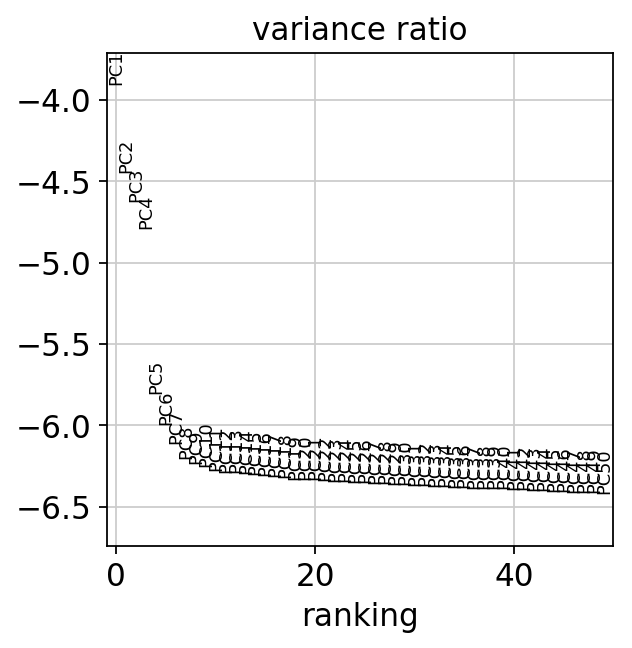

In [9]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

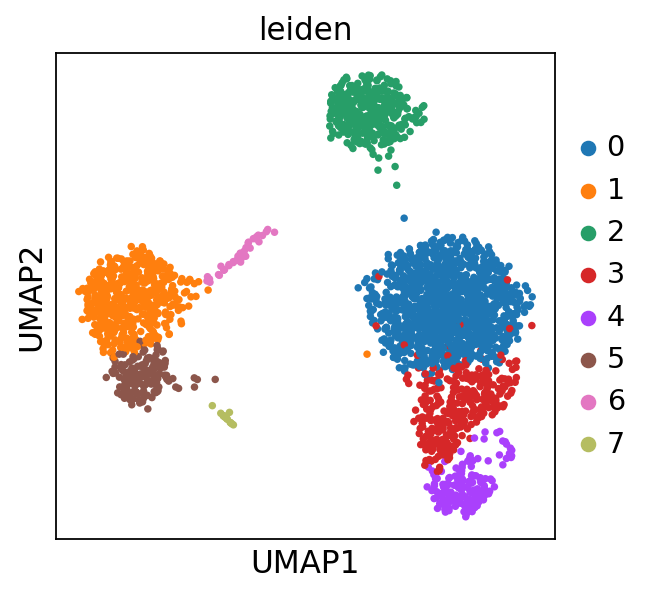

In [11]:
sc.tl.umap(adata) 
sc.tl.leiden(adata)
sc.pl.umap(adata, color="leiden")

In [12]:
adata.write('pbmc/adata_sc_pbmc.h5ad')

In [20]:
adata=sc.read('pbmc/adata_sc_pbmc.h5ad')

In [21]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

In [22]:
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20) #### df con i 20 geni significativi per gruppo

In [15]:
g = gt.Graph(directed=False)

In [17]:
adj=adata.uns['neighbors']['connectivities']
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [18]:
pickle.dump(g,open("pbmc/pbmc_g.pkl",'wb'),2)

In [5]:
g = pickle.load( open( "pbmc/pbmc_g.pkl", "rb" ))

# a) minimize_nested_blockmodel x 10

In [19]:
state10=[]
for i in range(10):
    i=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
    state10.append(i)

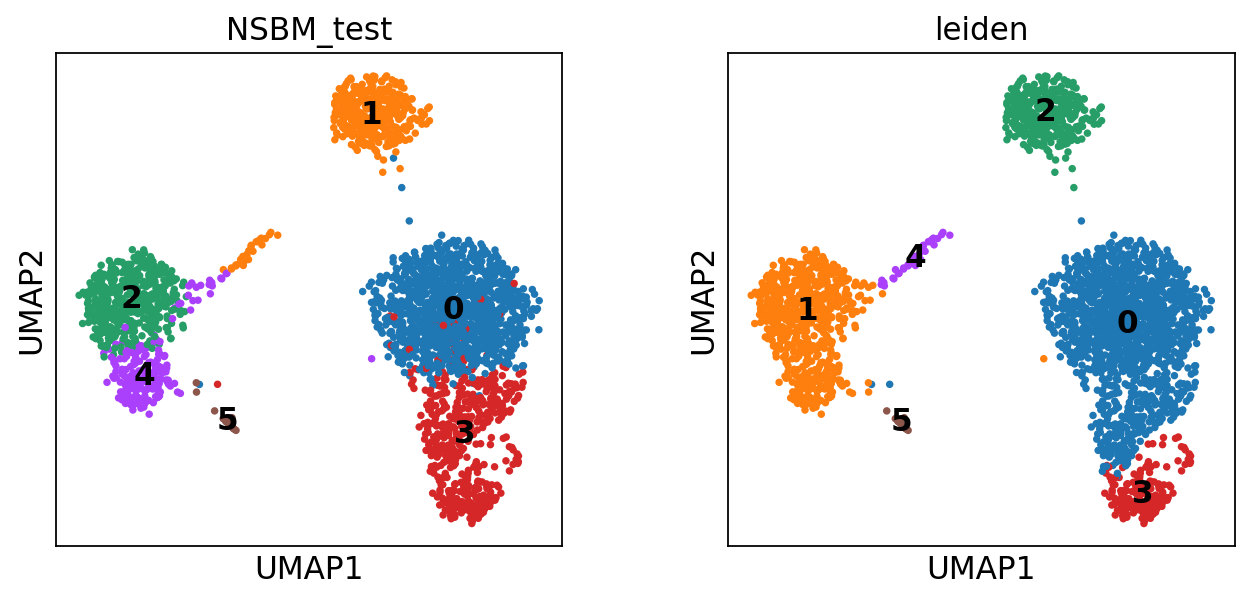

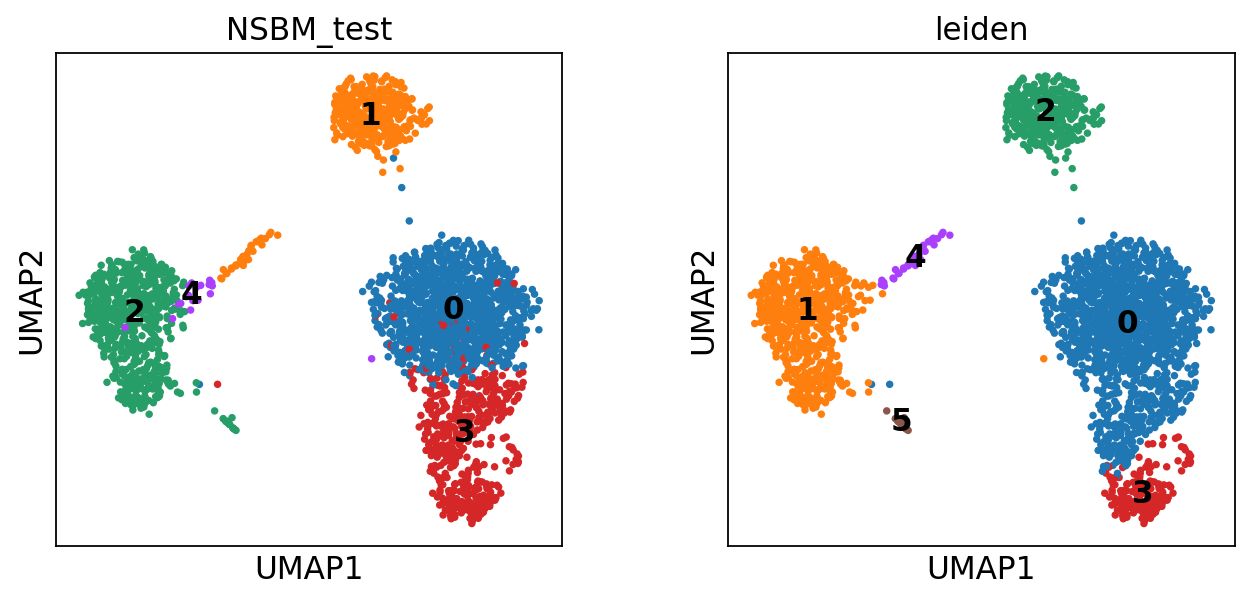

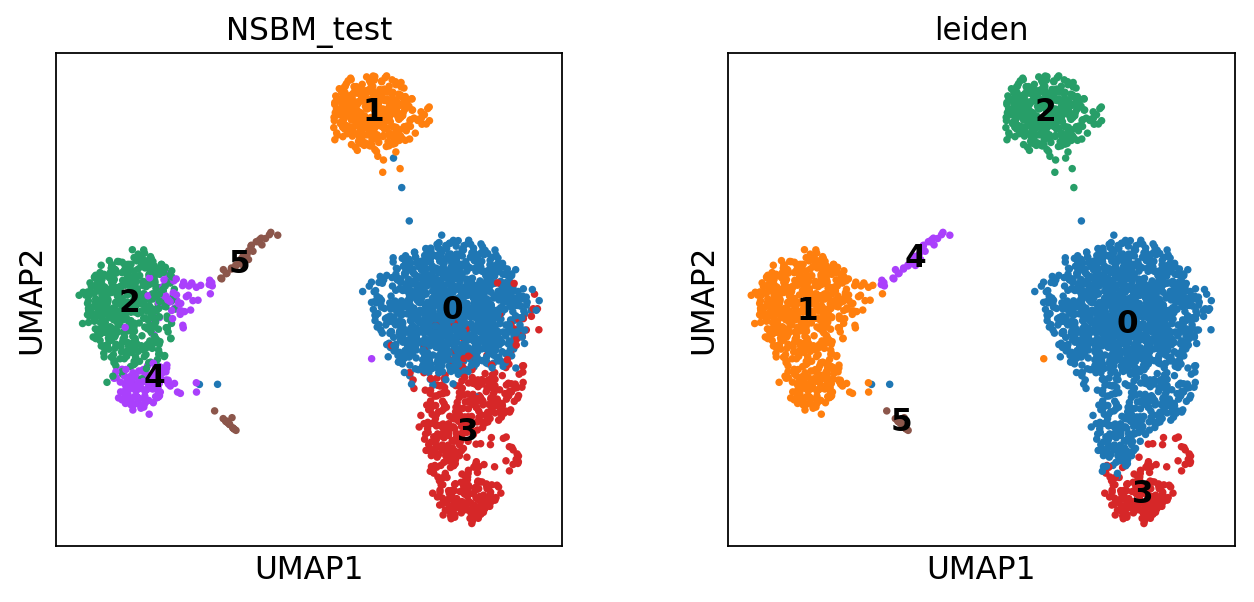

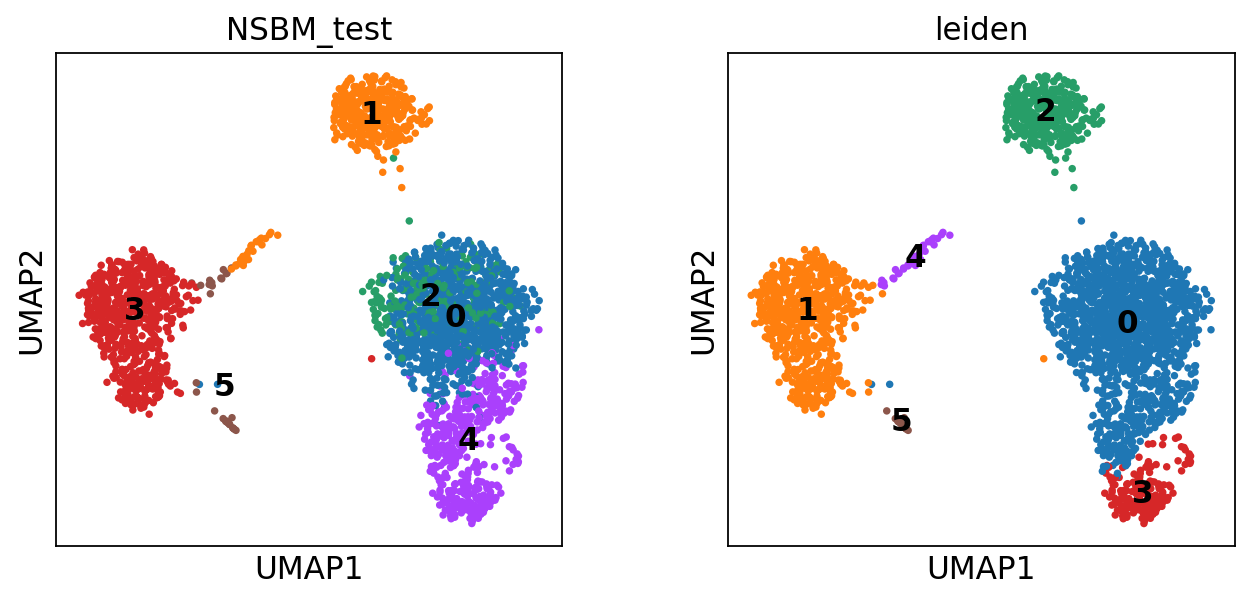

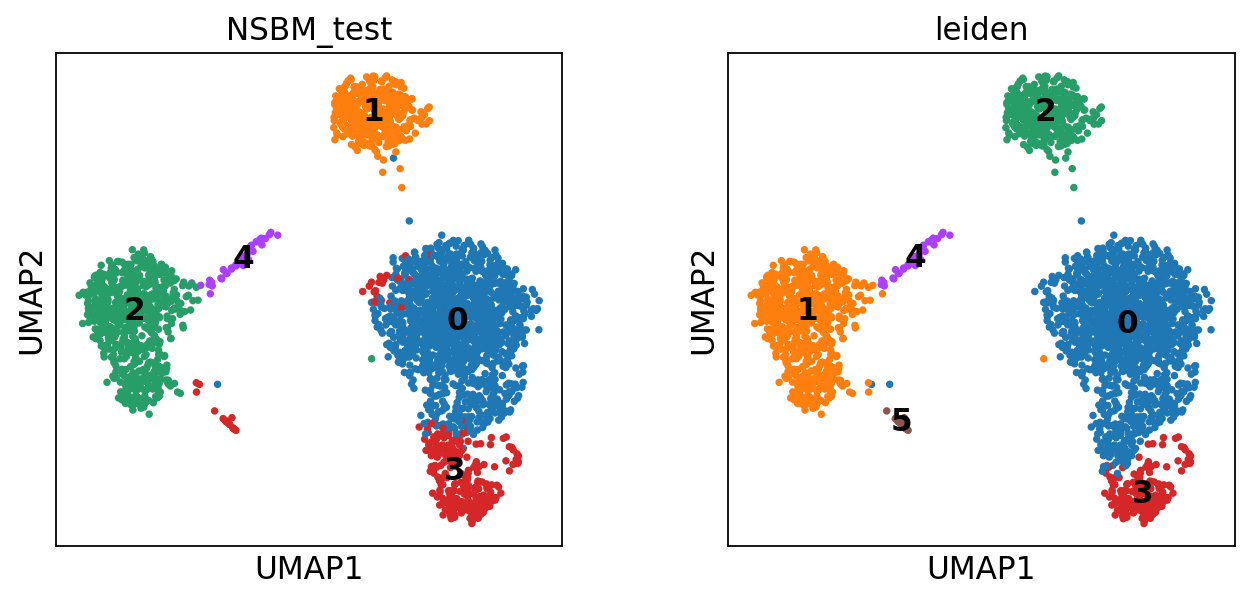

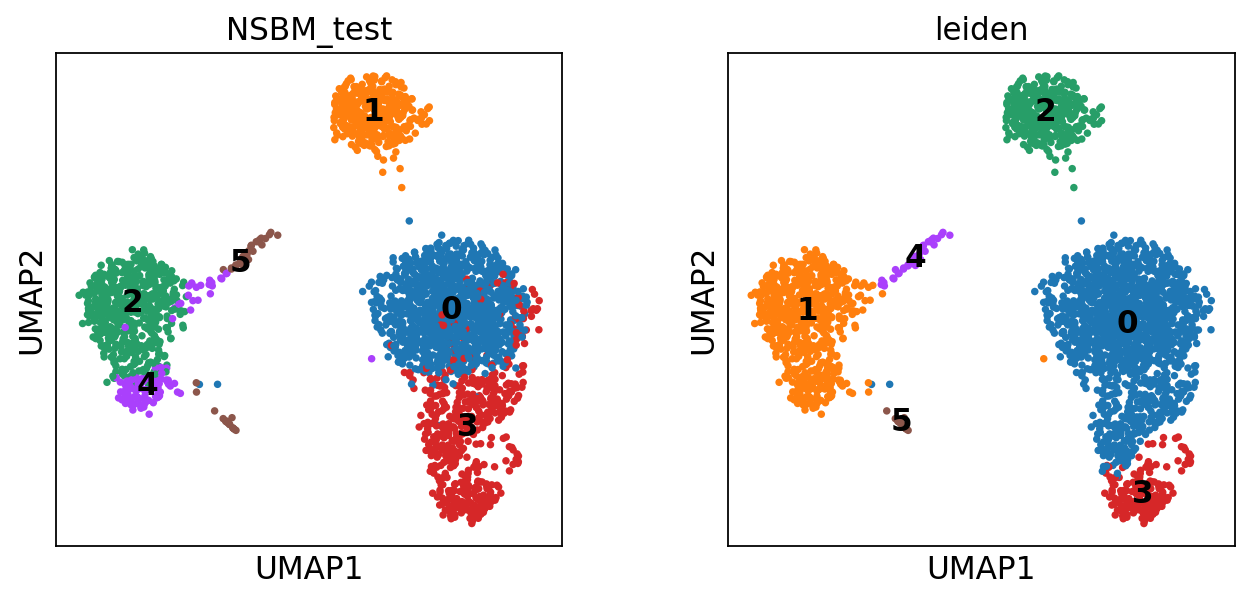

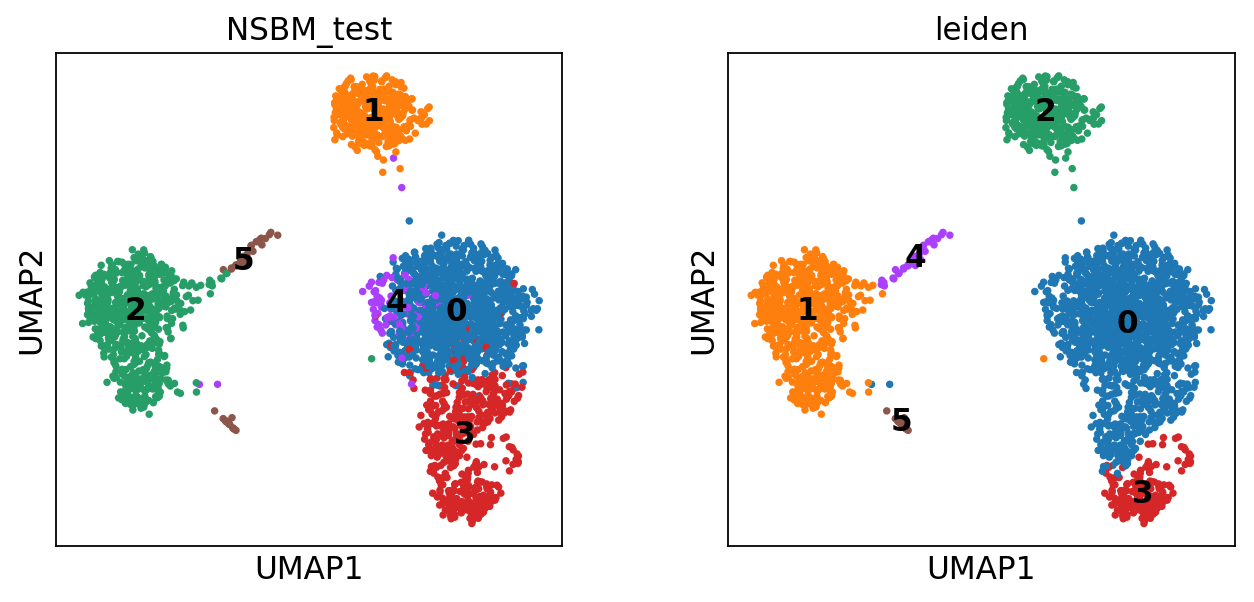

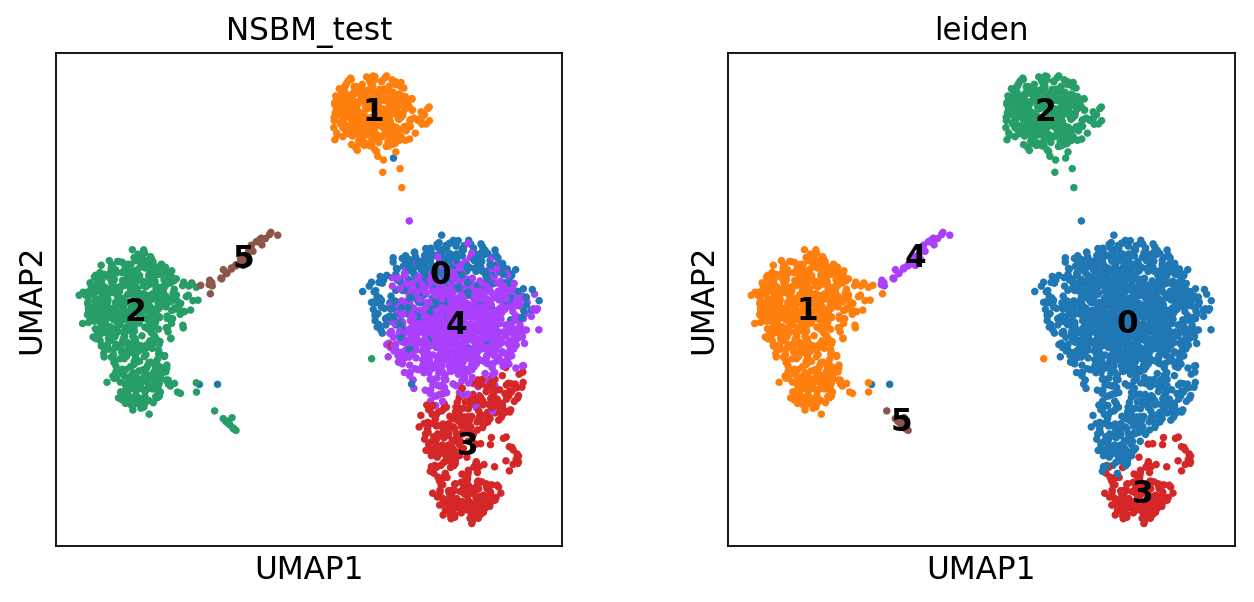

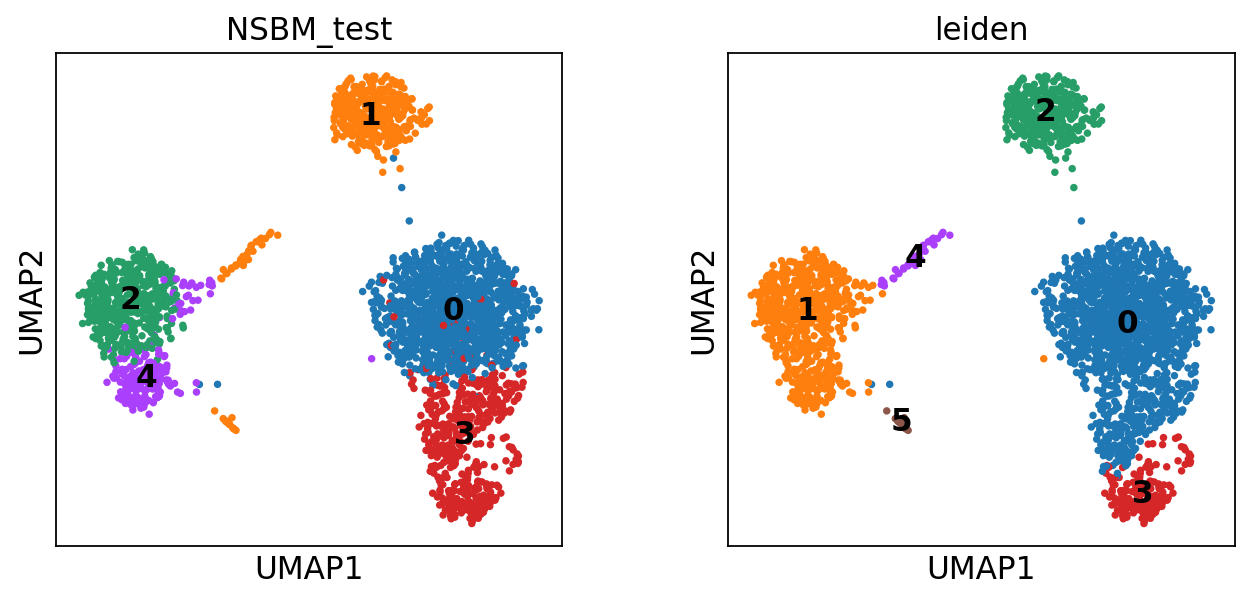

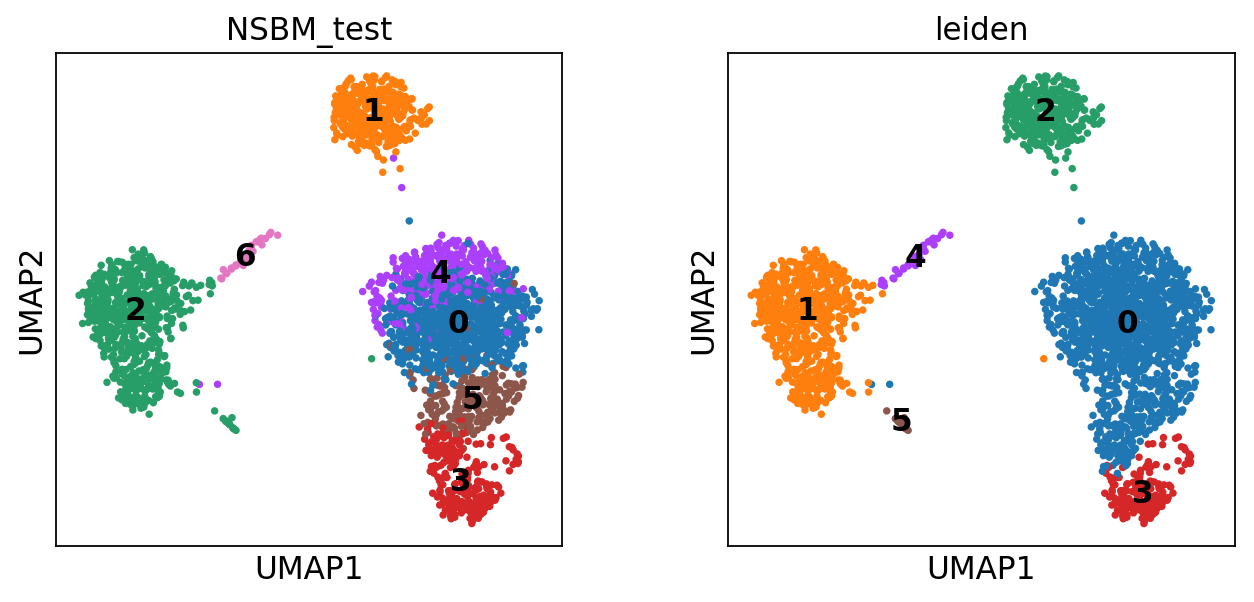

In [24]:
for i in range(10):
    adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state10[i].project_level(2).get_blocks()))
    sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')

In [22]:
ent=[]
for i in range(len(state10)):
    x=state10[i].entropy()
    ent.append(x)

In [23]:
stateX=None
entX=None
for i in range(len(state10)):
    if stateX==None:
        stateX=state10[i]
        entX=ent[i]
    elif ent[i]<entX:
        entX=ent[i]
        stateX=state10[i]
print(stateX,entX)

<NestedBlockState object, with base <BlockState object with 58 blocks (58 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7fbf60cb8610>, at 0x7fbf60874e90>, and 5 levels of sizes [(2638, 58), (58, 18), (18, 6), (6, 2), (2, 1)] at 0x7fbf60cb81d0> 97405.80303154129


In [25]:
pickle.dump(stateX,open("pbmc/pbmc_state_a.pkl",'wb'),2)

In [6]:
state_min=pickle.load( open( "pbmc/pbmc_state_a.pkl", "rb" ))

# B1) mcmc sweep (9:10)

In [107]:
# con entropia minima
bs = state_min.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state_min.copy(bs=bs, sampling=True)

In [108]:
state.mcmc_sweep(d=0.1,niter=10000, c=0.5)

(-162.06487110607307, 27272639, 5634785)

In [109]:
state

<NestedBlockState object, with base <BlockState object with 62 blocks (61 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7f1684dcf610>, at 0x7f168694e290>, and 10 levels of sizes [(2638, 61), (61, 17), (17, 6), (6, 3), (3, 2), (2, 2), (2, 2), (2, 1), (1, 1), (1, 1)] at 0x7f1684e24150>

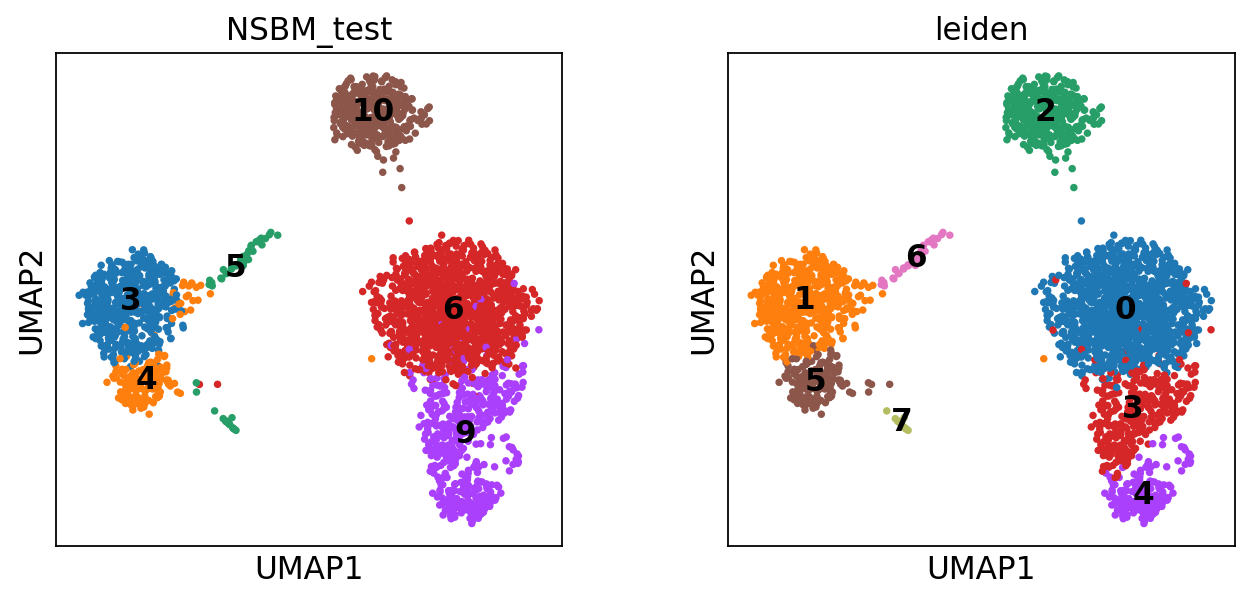

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
3             0  459    0    0    0   11   0   0
4             0   27    0    0    0  135   0   0
5             0    0    0    0    0    2  36  13
6          1119    0    0   21    0    2   0   0
9            24    0    0  285  163    0   0   0
10            0    0  341    0    0    0   0   0


In [110]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

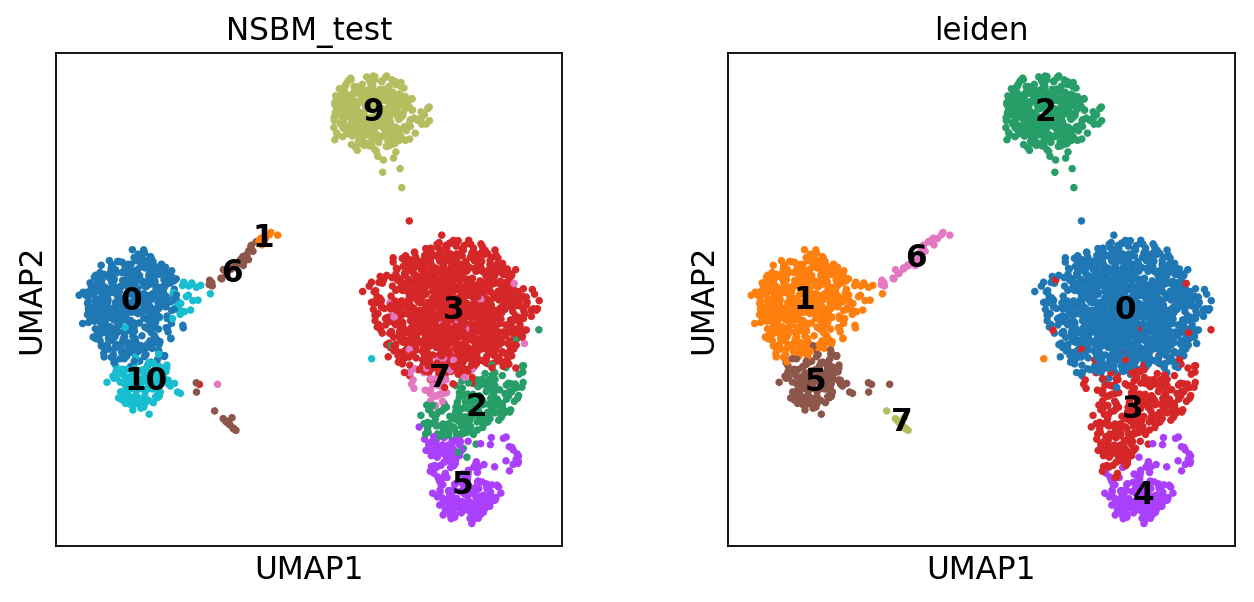

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
0             0  458    0    0    0   20   0   0
1             0    0    0    0    0    0   8   0
2             5    0    0  189    1    0   0   0
3          1121    0    0   21    0    1   0   0
5             0    0    0   60  162    0   0   0
6             0    0    0    0    0    2  28  13
7            17    0    0   36    0    1   0   0
9             0    0  341    0    0    0   0   0
10            0   28    0    0    0  126   0   0


In [72]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [30]:
pickle.dump(state,open("pbmc/pbmc_state_b_sweep.pkl",'wb'),2)

In [31]:
state_sweep=pickle.load( open( "pbmc/pbmc_state_b_sweep.pkl", "rb" ))

# B2) sweep (d=0.08)

In [34]:
# con entropia minima
bs = state_min.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state_min.copy(bs=bs, sampling=True)

state.mcmc_sweep(d=0.08,niter=100000)

(-132.64137281344506, 272758524, 54845373)

In [35]:
state

<NestedBlockState object, with base <BlockState object with 64 blocks (62 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7f5944712e10>, at 0x7f5946b112d0>, and 10 levels of sizes [(2638, 62), (62, 17), (17, 6), (6, 3), (3, 2), (2, 2), (2, 2), (2, 2), (2, 1), (1, 1)] at 0x7f5946b11550>

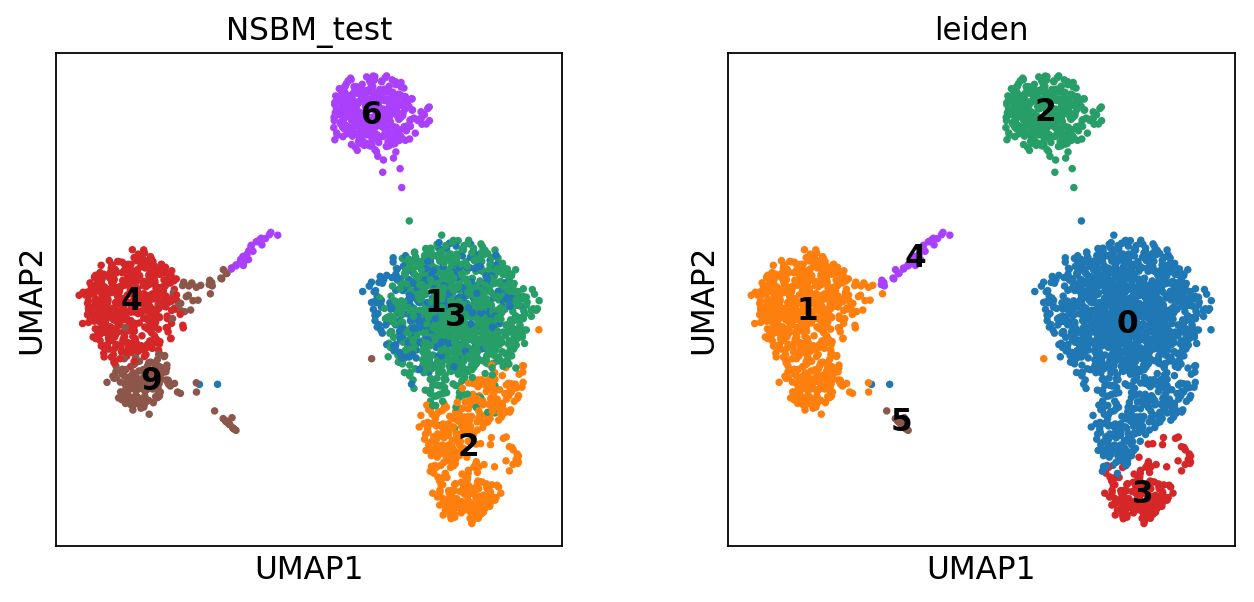

leiden       0    1    2    3   4   5
NSBM_test                            
1          285    0    0    0   0   0
2          233    0    0  167   0   0
3          929    0    0    0   0   0
4            0  469    0    0   0   0
6            0    0  341    0  26   0
9            0  165    0    0  10  13


In [26]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state_sweep08.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [37]:
pickle.dump(state,open("pbmc/pbmc_state_b_sweep08.pkl",'wb'),2)

In [15]:
state_sweep08=pickle.load( open( "pbmc/pbmc_state_b_sweep08.pkl", "rb" ))

# B3) multiflip (d=0.1) (2:20)

In [32]:
# con entropia minima
bs = state_min.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state_min.copy(bs=bs, sampling=True)

state.multiflip_mcmc_sweep(d=0.1,gibbs_sweeps=1000,niter=100.000)

(72.98880091296695, 164484, 3098)

In [33]:
state

<NestedBlockState object, with base <BlockState object with 79 blocks (77 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ffb9b3decd0>, at 0x7ffba02c8c90>, and 10 levels of sizes [(2638, 77), (77, 17), (17, 7), (7, 3), (3, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7ffba018b990>

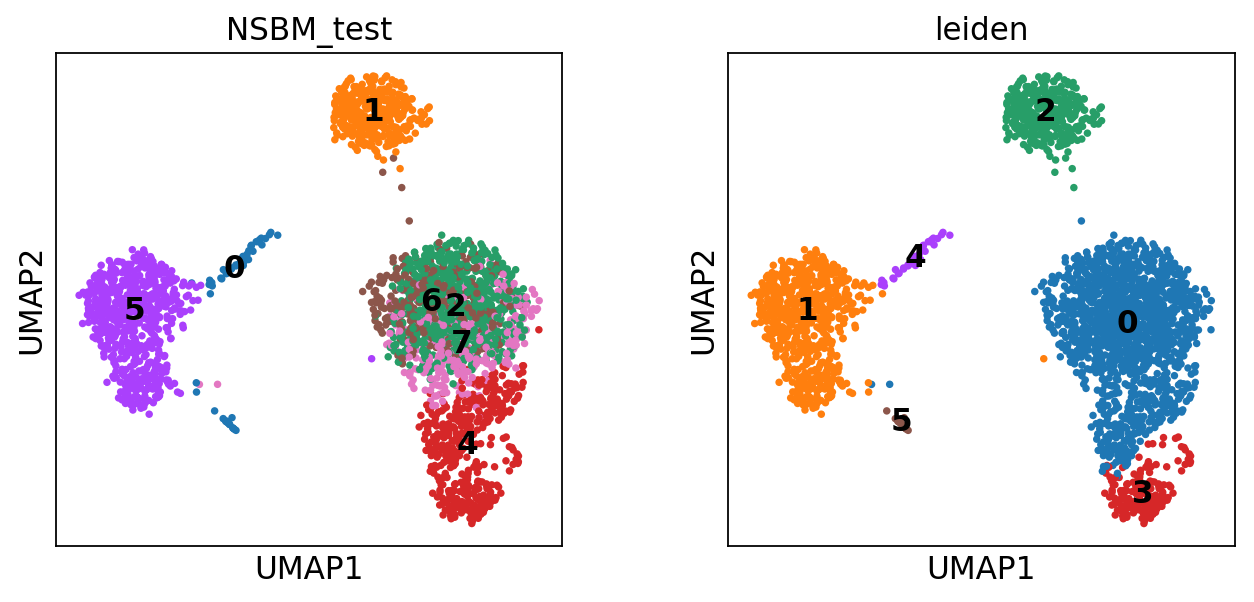

leiden       0    1    2    3   4   5
NSBM_test                            
0            0    4    0    0  36  13
1            0    0  338    0   0   0
2          641    0    0    0   0   0
4          242    0    0  167   0   0
5            0  630    0    0   0   0
6          277    0    3    0   0   0
7          287    0    0    0   0   0


In [34]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [35]:
pickle.dump(state,open("pbmc/pbmc_state_b_multiflip.pkl",'wb'),2)

In [36]:
state_multiflip=pickle.load( open( "pbmc/pbmc_state_b_multiflip.pkl", "rb" ))

# B4) multiflip (d=0.05) (2:30)

In [18]:
# con entropia minima
bs = state_min.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state_min.copy(bs=bs, sampling=True)

state.multiflip_mcmc_sweep(d=0.05,gibbs_sweeps=1000,niter=100.000)

(222.26949688561385, 172018, 3225)

In [19]:
state

<NestedBlockState object, with base <BlockState object with 82 blocks (79 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7f567bb34810>, at 0x7f567d44ddd0>, and 10 levels of sizes [(2638, 79), (79, 21), (21, 6), (6, 2), (2, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f567d44de10>

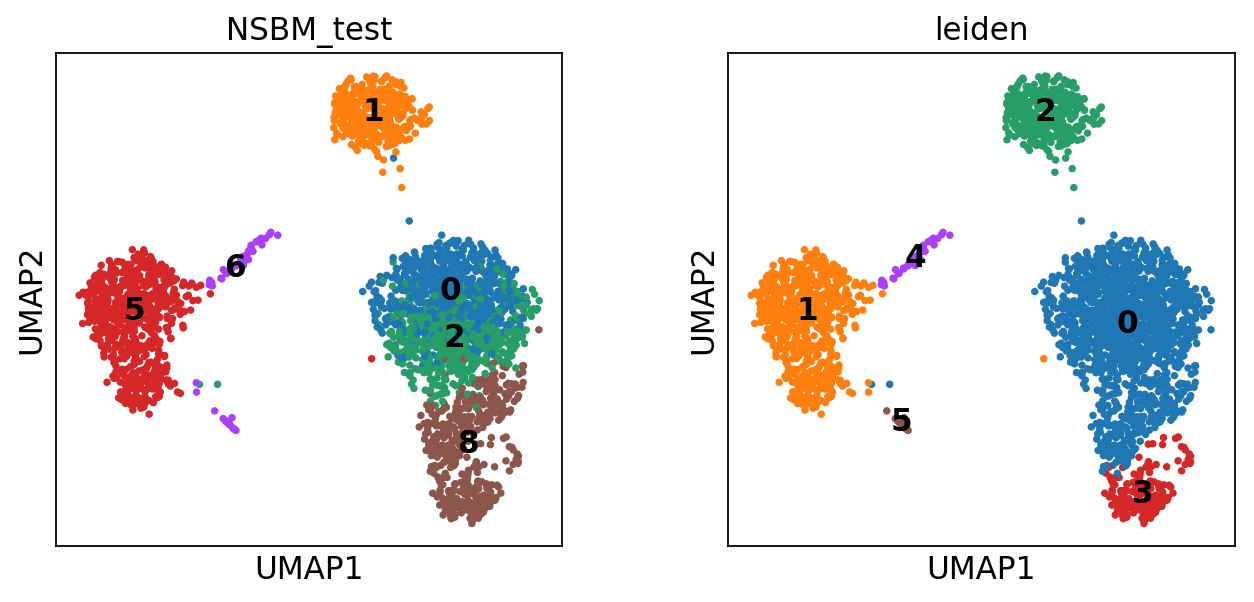

leiden       0    1    2    3   4   5
NSBM_test                            
0          629    0    1    0   0   0
1            0    0  340    0   0   0
2          568    0    0    0   0   0
5            0  631    0    0   0   0
6            0    3    0    0  36  13
8          250    0    0  167   0   0


In [20]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [21]:
pickle.dump(state,open("pbmc/pbmc_state_b_multiflip05.pkl",'wb'),2)

In [22]:
state_multiflip=pickle.load( open( "pbmc/pbmc_state_b_multiflip05.pkl", "rb" ))

# B5) multiflip (d=0.08)

In [21]:
# con entropia minima
bs = state_min.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state_min.copy(bs=bs, sampling=True)

state.multiflip_mcmc_sweep(d=0.08,gibbs_sweeps=1000,niter=100.000)

(168.8073641111162, 164517, 3111)

In [22]:
state

<NestedBlockState object, with base <BlockState object with 84 blocks (82 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7f5944712e10>, at 0x7f59447d9590>, and 10 levels of sizes [(2638, 82), (82, 19), (19, 7), (7, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f59447d9f90>

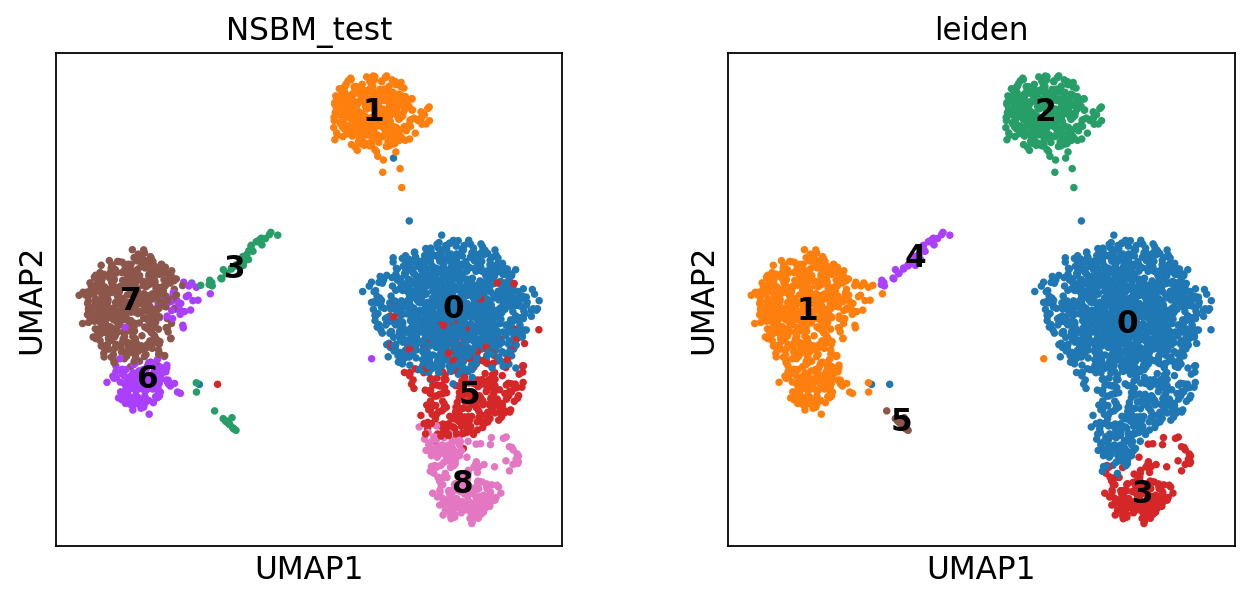

leiden        0    1    2    3   4   5
NSBM_test                             
0          1111    0    1    0   0   0
1             0    0  340    0   0   0
3             0    4    0    0  36  13
5           272    0    0    0   0   0
6             0  167    0    0   0   0
7             0  463    0    0   0   0
8            64    0    0  167   0   0


In [23]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [24]:
pickle.dump(state,open("pbmc/pbmc_state_b_multiflip08.pkl",'wb'),2)

In [26]:
state_multiflip08=pickle.load( open( "pbmc/pbmc_state_b_multiflip08.pkl", "rb" ))

# Multiflip finale

In [7]:
# con entropia minima
bs = state_min.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
state = state_min.copy(bs=bs, sampling=True)

state.multiflip_mcmc_sweep(niter=10000)
pickle.dump(state,open("pbmc/pbmc_state_b_multiflip_final.pkl",'wb'),2)
state

<NestedBlockState object, with base <BlockState object with 97 blocks (94 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7f4eafb46990>, at 0x7f4eab30d950>, and 10 levels of sizes [(2638, 94), (94, 21), (21, 8), (8, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f4eab30d650>

leiden        0    1    2    3    4    5   6   7
NSBM_test                                       
0          1072    0    0   15    0    2   0   0
3             0    0  260    0    0    0   0   0
4             0  460    0    0    0   20   0   0
5             0   24    0    0    0  126   0   0
7             0    0    0    0    0    0  26   0
8             0    0   81    0    0    0   0   0
10           71    0    0  291  163    0   0   0
11            0    2    0    0    0    2  10  13


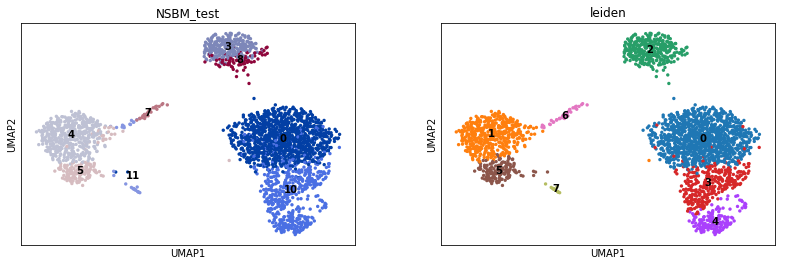

In [12]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

In [13]:
stateM=pickle.load( open( "pbmc/pbmc_state_b_multiflip_final.pkl", "rb" ))

# equilibrate finale

In [14]:
bs = stateM.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estateM = stateM.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_equilibrate(estateM,wait=1000,nbreaks=2,max_niter=1000000,epsilon=0,gibbs=False,multiflip=False,force_niter=None, mcmc_args=dict(niter=10))
b=time.time()
c=b-a
print(c)
pickle.dump(estateM, open('pbmc/pbmc_state_b_equilibrate_final.pkl", "rb" ))','wb'),2)
estateM

549.534961938858


<NestedBlockState object, with base <BlockState object with 88 blocks (86 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7f4eaee99bd0>, at 0x7f4eaf1b5610>, and 10 levels of sizes [(2638, 86), (86, 21), (21, 10), (10, 6), (6, 5), (5, 4), (4, 3), (3, 2), (2, 2), (2, 2)] at 0x7f4eaf1b5990>

In [17]:
estateM=pickle.load(open('pbmc/pbmc_state_b_equilibrate_final.pkl.pkl','rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'pbmc/pbmc_state_b_equilibrate_final.pkl.pkl'

leiden        0    1    2    3    4   5   6   7
NSBM_test                                      
0             0    0    0    0    0   0  36   0
2             0   21    0    0    0   0   0   0
3             0  458    0    0    0  12   0   0
5          1081    0    0   26    0   0   0   0
7             0    6    0    0    0  91   0   0
8            40    0    0    0    0   0   0   0
10           21    0    0  216    0   0   0   0
11            0    0    0   64  163   0   0   0
13            0    1    0    0    0  47   0  13
14            1    0  341    0    0   0   0   0

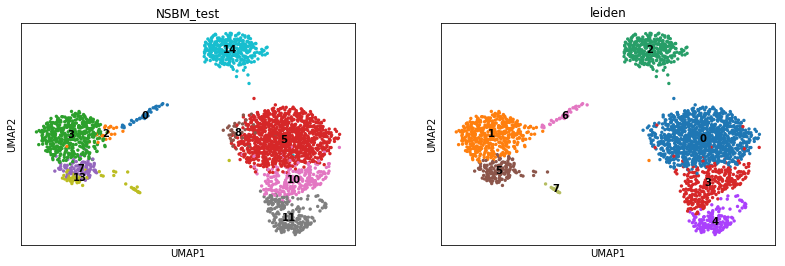

In [25]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden)

# C) equilibrate
### C1) sweep (6:00+21:00=27:00)
##### guardo bene come ho fatto qui equilibrate (devo guardare waits, ed nattempts)

In [ ]:
state = gt.minimize_nested_blockmodel_dl(g, deg_corr=False, B_max=20)
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state.copy(bs=bs, sampling=True)
state_sweep = state.mcmc_sweep(niter=50000, c=0.2, d=0.1)

#bs = state_sweep.get_bs()                   
#bs += [np.zeros(1)] * (10 - len(bs))

#state = state_sweep.copy(bs=bs, sampling=True)

In [115]:
state

<NestedBlockState object, with base <BlockState object with 65 blocks (63 nonempty), for graph <Graph object, undirected, with 2638 vertices and 41952 edges at 0x7f1688e44450>, at 0x7f1678ecf750>, and 10 levels of sizes [(2638, 63), (63, 8), (8, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f16788a0050>

In [117]:
gt.mcmc_equilibrate(state, wait=10, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1
        

def collect_marginals(s):
   global pv
   pv = [sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [118]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, mcmc_args=dict(niter=10, c=0.2, d=0.1),callback=collect_info, verbose=True)
state

niter:     1  count:    0  breaks:  0  min_S: 167743.76  max_S: 167756.39  S: 167756.39  ΔS:      12.6377  moves:  4888 
niter:     2  count:    1  breaks:  0  min_S: 167743.76  max_S: 167756.39  S: 167754.42  ΔS:     -1.97735  moves:  4902 
niter:     3  count:    0  breaks:  0  min_S: 167610.48  max_S: 167756.39  S: 167610.48  ΔS:     -143.934  moves:  5033 
niter:     4  count:    0  breaks:  0  min_S: 167592.80  max_S: 167756.39  S: 167592.80  ΔS:     -17.6786  moves:  4949 
niter:     5  count:    1  breaks:  0  min_S: 167592.80  max_S: 167756.39  S: 167592.96  ΔS:     0.155140  moves:  4987 
niter:     6  count:    0  breaks:  0  min_S: 167587.11  max_S: 167756.39  S: 167587.11  ΔS:     -5.84837  moves:  4937 
niter:     7  count:    1  breaks:  0  min_S: 167587.11  max_S: 167756.39  S: 167607.54  ΔS:      20.4286  moves:  5061 
niter:     8  count:    2  breaks:  0  min_S: 167587.11  max_S: 167756.39  S: 167609.50  ΔS:      1.95698  moves:  4957 
niter:     9  count:    0  break

niter:    69  count:    4  breaks:  0  min_S: 167416.18  max_S: 167756.39  S: 167445.98  ΔS:      25.4130  moves:  4690 
niter:    70  count:    5  breaks:  0  min_S: 167416.18  max_S: 167756.39  S: 167441.64  ΔS:     -4.33183  moves:  4883 
niter:    71  count:    6  breaks:  0  min_S: 167416.18  max_S: 167756.39  S: 167417.57  ΔS:     -24.0728  moves:  4898 
niter:    72  count:    0  breaks:  0  min_S: 167382.79  max_S: 167756.39  S: 167382.79  ΔS:     -34.7850  moves:  4812 
niter:    73  count:    0  breaks:  0  min_S: 167382.14  max_S: 167756.39  S: 167382.14  ΔS:    -0.645783  moves:  4948 
niter:    74  count:    1  breaks:  0  min_S: 167382.14  max_S: 167756.39  S: 167394.72  ΔS:      12.5816  moves:  4896 
niter:    75  count:    0  breaks:  0  min_S: 167350.63  max_S: 167756.39  S: 167350.63  ΔS:     -44.0921  moves:  4893 
niter:    76  count:    0  breaks:  0  min_S: 167343.58  max_S: 167756.39  S: 167343.58  ΔS:     -7.04726  moves:  4795 
niter:    77  count:    0  break

niter:   137  count:    0  breaks:  0  min_S: 167093.02  max_S: 167756.39  S: 167093.02  ΔS:     -35.8224  moves:  4750 
niter:   138  count:    1  breaks:  0  min_S: 167093.02  max_S: 167756.39  S: 167121.18  ΔS:      28.1597  moves:  4879 
niter:   139  count:    2  breaks:  0  min_S: 167093.02  max_S: 167756.39  S: 167107.88  ΔS:     -13.3009  moves:  4866 
niter:   140  count:    0  breaks:  0  min_S: 167072.60  max_S: 167756.39  S: 167072.60  ΔS:     -35.2801  moves:  4812 
niter:   141  count:    1  breaks:  0  min_S: 167072.60  max_S: 167756.39  S: 167086.94  ΔS:      14.3474  moves:  4874 
niter:   142  count:    2  breaks:  0  min_S: 167072.60  max_S: 167756.39  S: 167082.87  ΔS:     -4.07867  moves:  4678 
niter:   143  count:    0  breaks:  0  min_S: 167071.97  max_S: 167756.39  S: 167071.97  ΔS:     -10.8952  moves:  4845 
niter:   144  count:    1  breaks:  0  min_S: 167071.97  max_S: 167756.39  S: 167074.79  ΔS:      2.81925  moves:  4740 
niter:   145  count:    0  break

niter:   205  count:    0  breaks:  0  min_S: 166666.16  max_S: 167756.39  S: 166666.16  ΔS:     -15.3932  moves:  4736 
niter:   206  count:    1  breaks:  0  min_S: 166666.16  max_S: 167756.39  S: 166677.20  ΔS:      11.0383  moves:  4818 
niter:   207  count:    0  breaks:  0  min_S: 166657.95  max_S: 167756.39  S: 166657.95  ΔS:     -19.2480  moves:  4781 
niter:   208  count:    1  breaks:  0  min_S: 166657.95  max_S: 167756.39  S: 166673.44  ΔS:      15.4839  moves:  4659 
niter:   209  count:    2  breaks:  0  min_S: 166657.95  max_S: 167756.39  S: 166696.41  ΔS:      22.9688  moves:  4786 
niter:   210  count:    3  breaks:  0  min_S: 166657.95  max_S: 167756.39  S: 166683.70  ΔS:     -12.7051  moves:  4643 
niter:   211  count:    4  breaks:  0  min_S: 166657.95  max_S: 167756.39  S: 166686.21  ΔS:      2.51187  moves:  4649 
niter:   212  count:    5  breaks:  0  min_S: 166657.95  max_S: 167756.39  S: 166673.41  ΔS:     -12.7997  moves:  4671 
niter:   213  count:    6  break

niter:   273  count:   17  breaks:  0  min_S: 166441.35  max_S: 167756.39  S: 166466.17  ΔS:      2.99088  moves:  4559 
niter:   274  count:   18  breaks:  0  min_S: 166441.35  max_S: 167756.39  S: 166468.26  ΔS:      2.08562  moves:  4529 
niter:   275  count:   19  breaks:  0  min_S: 166441.35  max_S: 167756.39  S: 166470.68  ΔS:      2.42041  moves:  4550 
niter:   276  count:   20  breaks:  0  min_S: 166441.35  max_S: 167756.39  S: 166505.20  ΔS:      34.5200  moves:  4640 
niter:   277  count:   21  breaks:  0  min_S: 166441.35  max_S: 167756.39  S: 166480.03  ΔS:     -25.1699  moves:  4658 
niter:   278  count:   22  breaks:  0  min_S: 166441.35  max_S: 167756.39  S: 166465.01  ΔS:     -15.0198  moves:  4584 
niter:   279  count:   23  breaks:  0  min_S: 166441.35  max_S: 167756.39  S: 166472.57  ΔS:      7.55538  moves:  4569 
niter:   280  count:    0  breaks:  0  min_S: 166439.07  max_S: 167756.39  S: 166439.07  ΔS:     -33.4989  moves:  4611 
niter:   281  count:    1  break

niter:   341  count:    2  breaks:  0  min_S: 166280.41  max_S: 167756.39  S: 166292.40  ΔS:      3.22563  moves:  4631 
niter:   342  count:    3  breaks:  0  min_S: 166280.41  max_S: 167756.39  S: 166301.77  ΔS:      9.36686  moves:  4644 
niter:   343  count:    0  breaks:  0  min_S: 166273.00  max_S: 167756.39  S: 166273.00  ΔS:     -28.7683  moves:  4514 
niter:   344  count:    0  breaks:  0  min_S: 166265.25  max_S: 167756.39  S: 166265.25  ΔS:     -7.74501  moves:  4463 
niter:   345  count:    1  breaks:  0  min_S: 166265.25  max_S: 167756.39  S: 166299.72  ΔS:      34.4669  moves:  4548 
niter:   346  count:    2  breaks:  0  min_S: 166265.25  max_S: 167756.39  S: 166316.21  ΔS:      16.4907  moves:  4568 
niter:   347  count:    3  breaks:  0  min_S: 166265.25  max_S: 167756.39  S: 166302.65  ΔS:     -13.5555  moves:  4519 
niter:   348  count:    4  breaks:  0  min_S: 166265.25  max_S: 167756.39  S: 166284.20  ΔS:     -18.4490  moves:  4554 
niter:   349  count:    5  break

niter:   409  count:    0  breaks:  0  min_S: 166225.40  max_S: 167756.39  S: 166225.40  ΔS:     -10.7974  moves:  4379 
niter:   410  count:    1  breaks:  0  min_S: 166225.40  max_S: 167756.39  S: 166255.09  ΔS:      29.6934  moves:  4420 
niter:   411  count:    2  breaks:  0  min_S: 166225.40  max_S: 167756.39  S: 166249.01  ΔS:     -6.08192  moves:  4553 
niter:   412  count:    3  breaks:  0  min_S: 166225.40  max_S: 167756.39  S: 166228.02  ΔS:     -20.9908  moves:  4561 
niter:   413  count:    4  breaks:  0  min_S: 166225.40  max_S: 167756.39  S: 166250.19  ΔS:      22.1734  moves:  4643 
niter:   414  count:    5  breaks:  0  min_S: 166225.40  max_S: 167756.39  S: 166230.37  ΔS:     -19.8213  moves:  4491 
niter:   415  count:    6  breaks:  0  min_S: 166225.40  max_S: 167756.39  S: 166230.15  ΔS:    -0.225056  moves:  4608 
niter:   416  count:    0  breaks:  0  min_S: 166212.14  max_S: 167756.39  S: 166212.14  ΔS:     -18.0027  moves:  4515 
niter:   417  count:    1  break

niter:   478  count:    4  breaks:  0  min_S: 165966.31  max_S: 167756.39  S: 166025.24  ΔS:      21.8681  moves:  4448 
niter:   479  count:    5  breaks:  0  min_S: 165966.31  max_S: 167756.39  S: 165996.84  ΔS:     -28.4060  moves:  4366 
niter:   480  count:    6  breaks:  0  min_S: 165966.31  max_S: 167756.39  S: 165987.25  ΔS:     -9.58513  moves:  4283 
niter:   481  count:    7  breaks:  0  min_S: 165966.31  max_S: 167756.39  S: 166004.90  ΔS:      17.6421  moves:  4292 
niter:   482  count:    8  breaks:  0  min_S: 165966.31  max_S: 167756.39  S: 166000.90  ΔS:     -3.99798  moves:  4383 
niter:   483  count:    9  breaks:  0  min_S: 165966.31  max_S: 167756.39  S: 165971.87  ΔS:     -29.0286  moves:  4309 
niter:   484  count:   10  breaks:  0  min_S: 165966.31  max_S: 167756.39  S: 165980.19  ΔS:      8.31611  moves:  4263 
niter:   485  count:    0  breaks:  0  min_S: 165922.99  max_S: 167756.39  S: 165922.99  ΔS:     -57.1956  moves:  4263 
niter:   486  count:    0  break

niter:   546  count:    4  breaks:  0  min_S: 165588.04  max_S: 167756.39  S: 165608.03  ΔS:     -1.53729  moves:  4192 
niter:   547  count:    5  breaks:  0  min_S: 165588.04  max_S: 167756.39  S: 165604.66  ΔS:     -3.37766  moves:  4272 
niter:   548  count:    0  breaks:  0  min_S: 165573.01  max_S: 167756.39  S: 165573.01  ΔS:     -31.6493  moves:  4083 
niter:   549  count:    1  breaks:  0  min_S: 165573.01  max_S: 167756.39  S: 165584.88  ΔS:      11.8769  moves:  4241 
niter:   550  count:    2  breaks:  0  min_S: 165573.01  max_S: 167756.39  S: 165577.34  ΔS:     -7.54866  moves:  4256 
niter:   551  count:    0  breaks:  0  min_S: 165558.41  max_S: 167756.39  S: 165558.41  ΔS:     -18.9229  moves:  4116 
niter:   552  count:    0  breaks:  0  min_S: 165552.65  max_S: 167756.39  S: 165552.65  ΔS:     -5.75889  moves:  4137 
niter:   553  count:    1  breaks:  0  min_S: 165552.65  max_S: 167756.39  S: 165580.59  ΔS:      27.9372  moves:  4154 
niter:   554  count:    2  break

niter:   614  count:    1  breaks:  0  min_S: 165281.83  max_S: 167756.39  S: 165315.79  ΔS:      33.9623  moves:  4244 
niter:   615  count:    2  breaks:  0  min_S: 165281.83  max_S: 167756.39  S: 165328.24  ΔS:      12.4533  moves:  4106 
niter:   616  count:    3  breaks:  0  min_S: 165281.83  max_S: 167756.39  S: 165302.67  ΔS:     -25.5696  moves:  4111 
niter:   617  count:    4  breaks:  0  min_S: 165281.83  max_S: 167756.39  S: 165303.92  ΔS:      1.24426  moves:  4178 
niter:   618  count:    5  breaks:  0  min_S: 165281.83  max_S: 167756.39  S: 165296.80  ΔS:     -7.11889  moves:  4258 
niter:   619  count:    6  breaks:  0  min_S: 165281.83  max_S: 167756.39  S: 165291.85  ΔS:     -4.95356  moves:  4112 
niter:   620  count:    7  breaks:  0  min_S: 165281.83  max_S: 167756.39  S: 165303.28  ΔS:      11.4293  moves:  4227 
niter:   621  count:    8  breaks:  0  min_S: 165281.83  max_S: 167756.39  S: 165340.64  ΔS:      37.3653  moves:  4126 
niter:   622  count:    9  break

niter:   683  count:    4  breaks:  0  min_S: 165189.70  max_S: 167756.39  S: 165225.08  ΔS:      6.99710  moves:  4043 
niter:   684  count:    5  breaks:  0  min_S: 165189.70  max_S: 167756.39  S: 165247.99  ΔS:      22.9067  moves:  4184 
niter:   685  count:    6  breaks:  0  min_S: 165189.70  max_S: 167756.39  S: 165211.94  ΔS:     -36.0505  moves:  4159 
niter:   686  count:    7  breaks:  0  min_S: 165189.70  max_S: 167756.39  S: 165219.84  ΔS:      7.89993  moves:  4116 
niter:   687  count:    8  breaks:  0  min_S: 165189.70  max_S: 167756.39  S: 165226.17  ΔS:      6.33200  moves:  4091 
niter:   688  count:    9  breaks:  0  min_S: 165189.70  max_S: 167756.39  S: 165202.56  ΔS:     -23.6097  moves:  4175 
niter:   689  count:   10  breaks:  0  min_S: 165189.70  max_S: 167756.39  S: 165219.47  ΔS:      16.9153  moves:  4059 
niter:   690  count:   11  breaks:  0  min_S: 165189.70  max_S: 167756.39  S: 165220.89  ΔS:      1.41774  moves:  3999 
niter:   691  count:    0  break

niter:   751  count:    7  breaks:  0  min_S: 165142.43  max_S: 167756.39  S: 165185.38  ΔS:    -0.977964  moves:  4042 
niter:   752  count:    8  breaks:  0  min_S: 165142.43  max_S: 167756.39  S: 165167.20  ΔS:     -18.1784  moves:  4121 
niter:   753  count:    9  breaks:  0  min_S: 165142.43  max_S: 167756.39  S: 165158.33  ΔS:     -8.87389  moves:  4159 
niter:   754  count:    0  breaks:  0  min_S: 165128.24  max_S: 167756.39  S: 165128.24  ΔS:     -30.0858  moves:  4189 
niter:   755  count:    1  breaks:  0  min_S: 165128.24  max_S: 167756.39  S: 165181.91  ΔS:      53.6737  moves:  4072 
niter:   756  count:    2  breaks:  0  min_S: 165128.24  max_S: 167756.39  S: 165154.53  ΔS:     -27.3794  moves:  4073 
niter:   757  count:    3  breaks:  0  min_S: 165128.24  max_S: 167756.39  S: 165152.23  ΔS:     -2.30767  moves:  4086 
niter:   758  count:    4  breaks:  0  min_S: 165128.24  max_S: 167756.39  S: 165169.88  ΔS:      17.6484  moves:  4128 
niter:   759  count:    5  break

niter:   819  count:   10  breaks:  0  min_S: 165072.36  max_S: 167756.39  S: 165091.11  ΔS:     -15.9327  moves:  4050 
niter:   820  count:   11  breaks:  0  min_S: 165072.36  max_S: 167756.39  S: 165091.71  ΔS:     0.595742  moves:  4140 
niter:   821  count:   12  breaks:  0  min_S: 165072.36  max_S: 167756.39  S: 165103.56  ΔS:      11.8544  moves:  4200 
niter:   822  count:   13  breaks:  0  min_S: 165072.36  max_S: 167756.39  S: 165121.62  ΔS:      18.0565  moves:  4063 
niter:   823  count:   14  breaks:  0  min_S: 165072.36  max_S: 167756.39  S: 165113.71  ΔS:     -7.90850  moves:  4156 
niter:   824  count:   15  breaks:  0  min_S: 165072.36  max_S: 167756.39  S: 165103.83  ΔS:     -9.88292  moves:  4081 
niter:   825  count:   16  breaks:  0  min_S: 165072.36  max_S: 167756.39  S: 165091.77  ΔS:     -12.0590  moves:  3994 
niter:   826  count:   17  breaks:  0  min_S: 165072.36  max_S: 167756.39  S: 165118.29  ΔS:      26.5223  moves:  4081 
niter:   827  count:   18  break

niter:   887  count:    1  breaks:  0  min_S: 164938.71  max_S: 167756.39  S: 164944.22  ΔS:      5.51726  moves:  4020 
niter:   888  count:    0  breaks:  0  min_S: 164931.90  max_S: 167756.39  S: 164931.90  ΔS:     -12.3192  moves:  4110 
niter:   889  count:    1  breaks:  0  min_S: 164931.90  max_S: 167756.39  S: 164954.28  ΔS:      22.3717  moves:  4123 
niter:   890  count:    0  breaks:  0  min_S: 164931.44  max_S: 167756.39  S: 164931.44  ΔS:     -22.8319  moves:  4099 
niter:   891  count:    1  breaks:  0  min_S: 164931.44  max_S: 167756.39  S: 164940.57  ΔS:      9.12319  moves:  3968 
niter:   892  count:    0  breaks:  0  min_S: 164930.28  max_S: 167756.39  S: 164930.28  ΔS:     -10.2878  moves:  4015 
niter:   893  count:    0  breaks:  0  min_S: 164926.30  max_S: 167756.39  S: 164926.30  ΔS:     -3.97759  moves:  4083 
niter:   894  count:    0  breaks:  0  min_S: 164902.77  max_S: 167756.39  S: 164902.77  ΔS:     -23.5366  moves:  4110 
niter:   895  count:    1  break

niter:   955  count:    0  breaks:  0  min_S: 164881.55  max_S: 167756.39  S: 164881.55  ΔS:     -27.6516  moves:  3986 
niter:   956  count:    1  breaks:  0  min_S: 164881.55  max_S: 167756.39  S: 164888.60  ΔS:      7.04817  moves:  4019 
niter:   957  count:    2  breaks:  0  min_S: 164881.55  max_S: 167756.39  S: 164885.03  ΔS:     -3.56986  moves:  3967 
niter:   958  count:    0  breaks:  0  min_S: 164879.66  max_S: 167756.39  S: 164879.66  ΔS:     -5.37256  moves:  4088 
niter:   959  count:    1  breaks:  0  min_S: 164879.66  max_S: 167756.39  S: 164913.69  ΔS:      34.0297  moves:  3987 
niter:   960  count:    2  breaks:  0  min_S: 164879.66  max_S: 167756.39  S: 164919.15  ΔS:      5.45796  moves:  4013 
niter:   961  count:    3  breaks:  0  min_S: 164879.66  max_S: 167756.39  S: 164899.39  ΔS:     -19.7589  moves:  3983 
niter:   962  count:    4  breaks:  0  min_S: 164879.66  max_S: 167756.39  S: 164911.38  ΔS:      11.9944  moves:  4094 
niter:   963  count:    5  break

niter:  1023  count:    1  breaks:  0  min_S: 164637.09  max_S: 167756.39  S: 164637.91  ΔS:     0.814331  moves:  3993 
niter:  1024  count:    2  breaks:  0  min_S: 164637.09  max_S: 167756.39  S: 164659.39  ΔS:      21.4834  moves:  3917 
niter:  1025  count:    3  breaks:  0  min_S: 164637.09  max_S: 167756.39  S: 164652.16  ΔS:     -7.22740  moves:  3933 
niter:  1026  count:    0  breaks:  0  min_S: 164630.88  max_S: 167756.39  S: 164630.88  ΔS:     -21.2824  moves:  3993 
niter:  1027  count:    0  breaks:  0  min_S: 164628.81  max_S: 167756.39  S: 164628.81  ΔS:     -2.06894  moves:  3994 
niter:  1028  count:    1  breaks:  0  min_S: 164628.81  max_S: 167756.39  S: 164653.06  ΔS:      24.2510  moves:  3925 
niter:  1029  count:    2  breaks:  0  min_S: 164628.81  max_S: 167756.39  S: 164681.17  ΔS:      28.1084  moves:  4044 
niter:  1030  count:    3  breaks:  0  min_S: 164628.81  max_S: 167756.39  S: 164648.49  ΔS:     -32.6854  moves:  3936 
niter:  1031  count:    4  break

niter:  1091  count:    1  breaks:  0  min_S: 164430.00  max_S: 167756.39  S: 164465.82  ΔS:      35.8236  moves:  3975 
niter:  1092  count:    2  breaks:  0  min_S: 164430.00  max_S: 167756.39  S: 164430.64  ΔS:     -35.1837  moves:  3975 
niter:  1093  count:    0  breaks:  0  min_S: 164411.14  max_S: 167756.39  S: 164411.14  ΔS:     -19.5036  moves:  3998 
niter:  1094  count:    1  breaks:  0  min_S: 164411.14  max_S: 167756.39  S: 164439.58  ΔS:      28.4485  moves:  4036 
niter:  1095  count:    2  breaks:  0  min_S: 164411.14  max_S: 167756.39  S: 164436.11  ΔS:     -3.47901  moves:  3980 
niter:  1096  count:    3  breaks:  0  min_S: 164411.14  max_S: 167756.39  S: 164440.80  ΔS:      4.69801  moves:  3991 
niter:  1097  count:    4  breaks:  0  min_S: 164411.14  max_S: 167756.39  S: 164425.33  ΔS:     -15.4736  moves:  3983 
niter:  1098  count:    0  breaks:  0  min_S: 164377.76  max_S: 167756.39  S: 164377.76  ΔS:     -47.5728  moves:  4026 
niter:  1099  count:    0  break

niter:  1159  count:   10  breaks:  0  min_S: 164134.73  max_S: 167756.39  S: 164177.42  ΔS:      13.2147  moves:  3846 
niter:  1160  count:   11  breaks:  0  min_S: 164134.73  max_S: 167756.39  S: 164170.51  ΔS:     -6.91377  moves:  3857 
niter:  1161  count:   12  breaks:  0  min_S: 164134.73  max_S: 167756.39  S: 164175.63  ΔS:      5.11524  moves:  3794 
niter:  1162  count:   13  breaks:  0  min_S: 164134.73  max_S: 167756.39  S: 164168.77  ΔS:     -6.85411  moves:  3802 
niter:  1163  count:    0  breaks:  0  min_S: 164130.99  max_S: 167756.39  S: 164130.99  ΔS:     -37.7784  moves:  3892 
niter:  1164  count:    0  breaks:  0  min_S: 164129.17  max_S: 167756.39  S: 164129.17  ΔS:     -1.81793  moves:  3993 
niter:  1165  count:    1  breaks:  0  min_S: 164129.17  max_S: 167756.39  S: 164141.51  ΔS:      12.3340  moves:  3811 
niter:  1166  count:    2  breaks:  0  min_S: 164129.17  max_S: 167756.39  S: 164149.23  ΔS:      7.72161  moves:  3846 
niter:  1167  count:    3  break

niter:  1227  count:    0  breaks:  0  min_S: 163955.91  max_S: 167756.39  S: 163955.91  ΔS:     -61.1736  moves:  3869 
niter:  1228  count:    0  breaks:  0  min_S: 163953.77  max_S: 167756.39  S: 163953.77  ΔS:     -2.14659  moves:  3882 
niter:  1229  count:    0  breaks:  0  min_S: 163952.07  max_S: 167756.39  S: 163952.07  ΔS:     -1.69481  moves:  3903 
niter:  1230  count:    1  breaks:  0  min_S: 163952.07  max_S: 167756.39  S: 163964.50  ΔS:      12.4251  moves:  3816 
niter:  1231  count:    2  breaks:  0  min_S: 163952.07  max_S: 167756.39  S: 163985.39  ΔS:      20.8923  moves:  3879 
niter:  1232  count:    3  breaks:  0  min_S: 163952.07  max_S: 167756.39  S: 163965.81  ΔS:     -19.5828  moves:  3895 
niter:  1233  count:    4  breaks:  0  min_S: 163952.07  max_S: 167756.39  S: 163976.89  ΔS:      11.0817  moves:  3906 
niter:  1234  count:    5  breaks:  0  min_S: 163952.07  max_S: 167756.39  S: 163978.28  ΔS:      1.38771  moves:  3824 
niter:  1235  count:    0  break

niter:  1295  count:   12  breaks:  0  min_S: 163808.94  max_S: 167756.39  S: 163830.84  ΔS:     -11.3992  moves:  3857 
niter:  1296  count:   13  breaks:  0  min_S: 163808.94  max_S: 167756.39  S: 163818.29  ΔS:     -12.5448  moves:  3848 
niter:  1297  count:    0  breaks:  0  min_S: 163802.75  max_S: 167756.39  S: 163802.75  ΔS:     -15.5461  moves:  3850 
niter:  1298  count:    1  breaks:  0  min_S: 163802.75  max_S: 167756.39  S: 163806.35  ΔS:      3.60401  moves:  3845 
niter:  1299  count:    2  breaks:  0  min_S: 163802.75  max_S: 167756.39  S: 163810.63  ΔS:      4.28105  moves:  3788 
niter:  1300  count:    0  breaks:  0  min_S: 163798.02  max_S: 167756.39  S: 163798.02  ΔS:     -12.6127  moves:  3719 
niter:  1301  count:    1  breaks:  0  min_S: 163798.02  max_S: 167756.39  S: 163812.02  ΔS:      14.0011  moves:  3780 
niter:  1302  count:    0  breaks:  0  min_S: 163795.85  max_S: 167756.39  S: 163795.85  ΔS:     -16.1651  moves:  3782 
niter:  1303  count:    0  break

niter:  1363  count:   16  breaks:  0  min_S: 163743.99  max_S: 167756.39  S: 163796.87  ΔS:    -0.225186  moves:  3875 
niter:  1364  count:   17  breaks:  0  min_S: 163743.99  max_S: 167756.39  S: 163798.23  ΔS:      1.36361  moves:  3866 
niter:  1365  count:   18  breaks:  0  min_S: 163743.99  max_S: 167756.39  S: 163778.34  ΔS:     -19.8951  moves:  3842 
niter:  1366  count:   19  breaks:  0  min_S: 163743.99  max_S: 167756.39  S: 163810.61  ΔS:      32.2736  moves:  3818 
niter:  1367  count:   20  breaks:  0  min_S: 163743.99  max_S: 167756.39  S: 163808.71  ΔS:     -1.89758  moves:  3837 
niter:  1368  count:   21  breaks:  0  min_S: 163743.99  max_S: 167756.39  S: 163800.37  ΔS:     -8.34380  moves:  3818 
niter:  1369  count:   22  breaks:  0  min_S: 163743.99  max_S: 167756.39  S: 163799.93  ΔS:    -0.444266  moves:  3806 
niter:  1370  count:   23  breaks:  0  min_S: 163743.99  max_S: 167756.39  S: 163786.68  ΔS:     -13.2460  moves:  3814 
niter:  1371  count:   24  break

niter:  1431  count:    4  breaks:  0  min_S: 163702.16  max_S: 167756.39  S: 163721.75  ΔS:      7.01183  moves:  3747 
niter:  1432  count:    5  breaks:  0  min_S: 163702.16  max_S: 167756.39  S: 163720.90  ΔS:    -0.842787  moves:  3786 
niter:  1433  count:    6  breaks:  0  min_S: 163702.16  max_S: 167756.39  S: 163739.27  ΔS:      18.3706  moves:  3806 
niter:  1434  count:    7  breaks:  0  min_S: 163702.16  max_S: 167756.39  S: 163738.17  ΔS:     -1.10118  moves:  3867 
niter:  1435  count:    8  breaks:  0  min_S: 163702.16  max_S: 167756.39  S: 163712.74  ΔS:     -25.4362  moves:  3768 
niter:  1436  count:    9  breaks:  0  min_S: 163702.16  max_S: 167756.39  S: 163715.33  ΔS:      2.59263  moves:  3806 
niter:  1437  count:   10  breaks:  0  min_S: 163702.16  max_S: 167756.39  S: 163739.30  ΔS:      23.9664  moves:  3848 
niter:  1438  count:   11  breaks:  0  min_S: 163702.16  max_S: 167756.39  S: 163707.76  ΔS:     -31.5408  moves:  3725 
niter:  1439  count:    0  break

niter:  1499  count:    5  breaks:  0  min_S: 163537.95  max_S: 167756.39  S: 163582.48  ΔS:     -11.3214  moves:  3780 
niter:  1500  count:    6  breaks:  0  min_S: 163537.95  max_S: 167756.39  S: 163567.16  ΔS:     -15.3199  moves:  3806 
niter:  1501  count:    7  breaks:  0  min_S: 163537.95  max_S: 167756.39  S: 163578.13  ΔS:      10.9748  moves:  3696 
niter:  1502  count:    8  breaks:  0  min_S: 163537.95  max_S: 167756.39  S: 163609.04  ΔS:      30.9090  moves:  3907 
niter:  1503  count:    9  breaks:  0  min_S: 163537.95  max_S: 167756.39  S: 163606.39  ΔS:     -2.65547  moves:  3652 
niter:  1504  count:   10  breaks:  0  min_S: 163537.95  max_S: 167756.39  S: 163617.21  ΔS:      10.8203  moves:  3871 
niter:  1505  count:   11  breaks:  0  min_S: 163537.95  max_S: 167756.39  S: 163588.19  ΔS:     -29.0133  moves:  3754 
niter:  1506  count:   12  breaks:  0  min_S: 163537.95  max_S: 167756.39  S: 163598.43  ΔS:      10.2376  moves:  3667 
niter:  1507  count:   13  break

niter:  1567  count:   11  breaks:  0  min_S: 163493.85  max_S: 167756.39  S: 163551.20  ΔS:      13.5512  moves:  3891 
niter:  1568  count:   12  breaks:  0  min_S: 163493.85  max_S: 167756.39  S: 163531.03  ΔS:     -20.1678  moves:  3812 
niter:  1569  count:   13  breaks:  0  min_S: 163493.85  max_S: 167756.39  S: 163530.03  ΔS:    -0.994511  moves:  3828 
niter:  1570  count:   14  breaks:  0  min_S: 163493.85  max_S: 167756.39  S: 163544.96  ΔS:      14.9215  moves:  3786 
niter:  1571  count:   15  breaks:  0  min_S: 163493.85  max_S: 167756.39  S: 163561.75  ΔS:      16.7978  moves:  3715 
niter:  1572  count:   16  breaks:  0  min_S: 163493.85  max_S: 167756.39  S: 163527.47  ΔS:     -34.2822  moves:  3872 
niter:  1573  count:   17  breaks:  0  min_S: 163493.85  max_S: 167756.39  S: 163513.50  ΔS:     -13.9718  moves:  3804 
niter:  1574  count:   18  breaks:  0  min_S: 163493.85  max_S: 167756.39  S: 163529.15  ΔS:      15.6499  moves:  3770 
niter:  1575  count:   19  break

niter:  1635  count:    7  breaks:  0  min_S: 163450.33  max_S: 167756.39  S: 163485.17  ΔS:      6.34615  moves:  3759 
niter:  1636  count:    8  breaks:  0  min_S: 163450.33  max_S: 167756.39  S: 163474.80  ΔS:     -10.3762  moves:  3760 
niter:  1637  count:    9  breaks:  0  min_S: 163450.33  max_S: 167756.39  S: 163465.10  ΔS:     -9.69680  moves:  3718 
niter:  1638  count:   10  breaks:  0  min_S: 163450.33  max_S: 167756.39  S: 163490.42  ΔS:      25.3143  moves:  3696 
niter:  1639  count:   11  breaks:  0  min_S: 163450.33  max_S: 167756.39  S: 163484.94  ΔS:     -5.47383  moves:  3810 
niter:  1640  count:   12  breaks:  0  min_S: 163450.33  max_S: 167756.39  S: 163484.62  ΔS:    -0.320553  moves:  3657 
niter:  1641  count:   13  breaks:  0  min_S: 163450.33  max_S: 167756.39  S: 163489.82  ΔS:      5.19399  moves:  3728 
niter:  1642  count:   14  breaks:  0  min_S: 163450.33  max_S: 167756.39  S: 163473.67  ΔS:     -16.1469  moves:  3796 
niter:  1643  count:   15  break

niter:  1703  count:    3  breaks:  0  min_S: 163402.10  max_S: 167756.39  S: 163425.58  ΔS:      19.9769  moves:  3724 
niter:  1704  count:    4  breaks:  0  min_S: 163402.10  max_S: 167756.39  S: 163431.72  ΔS:      6.13296  moves:  3639 
niter:  1705  count:    5  breaks:  0  min_S: 163402.10  max_S: 167756.39  S: 163414.72  ΔS:     -16.9928  moves:  3752 
niter:  1706  count:    0  breaks:  0  min_S: 163394.74  max_S: 167756.39  S: 163394.74  ΔS:     -19.9857  moves:  3740 
niter:  1707  count:    1  breaks:  0  min_S: 163394.74  max_S: 167756.39  S: 163430.01  ΔS:      35.2742  moves:  3752 
niter:  1708  count:    2  breaks:  0  min_S: 163394.74  max_S: 167756.39  S: 163430.01  ΔS:  -0.00132216  moves:  3805 
niter:  1709  count:    3  breaks:  0  min_S: 163394.74  max_S: 167756.39  S: 163406.16  ΔS:     -23.8464  moves:  3784 
niter:  1710  count:    4  breaks:  0  min_S: 163394.74  max_S: 167756.39  S: 163409.93  ΔS:      3.76650  moves:  3717 
niter:  1711  count:    5  break

niter:  1771  count:    1  breaks:  0  min_S: 163289.36  max_S: 167756.39  S: 163297.70  ΔS:      8.34100  moves:  3802 
niter:  1772  count:    2  breaks:  0  min_S: 163289.36  max_S: 167756.39  S: 163305.13  ΔS:      7.42534  moves:  3758 
niter:  1773  count:    3  breaks:  0  min_S: 163289.36  max_S: 167756.39  S: 163308.08  ΔS:      2.95645  moves:  3722 
niter:  1774  count:    4  breaks:  0  min_S: 163289.36  max_S: 167756.39  S: 163334.57  ΔS:      26.4830  moves:  3716 
niter:  1775  count:    5  breaks:  0  min_S: 163289.36  max_S: 167756.39  S: 163317.14  ΔS:     -17.4231  moves:  3695 
niter:  1776  count:    6  breaks:  0  min_S: 163289.36  max_S: 167756.39  S: 163307.99  ΔS:     -9.15602  moves:  3787 
niter:  1777  count:    7  breaks:  0  min_S: 163289.36  max_S: 167756.39  S: 163327.42  ΔS:      19.4361  moves:  3650 
niter:  1778  count:    8  breaks:  0  min_S: 163289.36  max_S: 167756.39  S: 163321.23  ΔS:     -6.19535  moves:  3800 
niter:  1779  count:    9  break

niter:  1839  count:   27  breaks:  0  min_S: 163272.82  max_S: 167756.39  S: 163303.75  ΔS:     -24.9164  moves:  3698 
niter:  1840  count:   28  breaks:  0  min_S: 163272.82  max_S: 167756.39  S: 163302.53  ΔS:     -1.22576  moves:  3698 
niter:  1841  count:   29  breaks:  0  min_S: 163272.82  max_S: 167756.39  S: 163323.55  ΔS:      21.0285  moves:  3672 
niter:  1842  count:   30  breaks:  0  min_S: 163272.82  max_S: 167756.39  S: 163304.91  ΔS:     -18.6427  moves:  3736 
niter:  1843  count:   31  breaks:  0  min_S: 163272.82  max_S: 167756.39  S: 163340.82  ΔS:      35.9118  moves:  3703 
niter:  1844  count:   32  breaks:  0  min_S: 163272.82  max_S: 167756.39  S: 163321.29  ΔS:     -19.5331  moves:  3722 
niter:  1845  count:   33  breaks:  0  min_S: 163272.82  max_S: 167756.39  S: 163316.58  ΔS:     -4.71144  moves:  3767 
niter:  1846  count:   34  breaks:  0  min_S: 163272.82  max_S: 167756.39  S: 163295.53  ΔS:     -21.0446  moves:  3800 
niter:  1847  count:   35  break

niter:  1907  count:    7  breaks:  0  min_S: 163227.02  max_S: 167756.39  S: 163263.83  ΔS:     -15.7956  moves:  3694 
niter:  1908  count:    8  breaks:  0  min_S: 163227.02  max_S: 167756.39  S: 163263.67  ΔS:    -0.158134  moves:  3640 
niter:  1909  count:    9  breaks:  0  min_S: 163227.02  max_S: 167756.39  S: 163276.86  ΔS:      13.1914  moves:  3782 
niter:  1910  count:   10  breaks:  0  min_S: 163227.02  max_S: 167756.39  S: 163287.43  ΔS:      10.5697  moves:  3728 
niter:  1911  count:   11  breaks:  0  min_S: 163227.02  max_S: 167756.39  S: 163280.58  ΔS:     -6.84790  moves:  3835 
niter:  1912  count:   12  breaks:  0  min_S: 163227.02  max_S: 167756.39  S: 163239.78  ΔS:     -40.7964  moves:  3697 
niter:  1913  count:   13  breaks:  0  min_S: 163227.02  max_S: 167756.39  S: 163252.75  ΔS:      12.9623  moves:  3778 
niter:  1914  count:   14  breaks:  0  min_S: 163227.02  max_S: 167756.39  S: 163260.70  ΔS:      7.95814  moves:  3676 
niter:  1915  count:   15  break

niter:  1975  count:    0  breaks:  0  min_S: 163140.30  max_S: 167756.39  S: 163140.30  ΔS:     -19.5363  moves:  3606 
niter:  1976  count:    1  breaks:  0  min_S: 163140.30  max_S: 167756.39  S: 163163.99  ΔS:      23.6915  moves:  3771 
niter:  1977  count:    2  breaks:  0  min_S: 163140.30  max_S: 167756.39  S: 163202.37  ΔS:      38.3850  moves:  3661 
niter:  1978  count:    3  breaks:  0  min_S: 163140.30  max_S: 167756.39  S: 163176.87  ΔS:     -25.5060  moves:  3685 
niter:  1979  count:    4  breaks:  0  min_S: 163140.30  max_S: 167756.39  S: 163212.31  ΔS:      35.4489  moves:  3642 
niter:  1980  count:    5  breaks:  0  min_S: 163140.30  max_S: 167756.39  S: 163203.51  ΔS:     -8.80022  moves:  3630 
niter:  1981  count:    6  breaks:  0  min_S: 163140.30  max_S: 167756.39  S: 163156.89  ΔS:     -46.6241  moves:  3622 
niter:  1982  count:    7  breaks:  0  min_S: 163140.30  max_S: 167756.39  S: 163149.30  ΔS:     -7.59248  moves:  3713 
niter:  1983  count:    8  break

niter:  2043  count:   19  breaks:  0  min_S: 163040.76  max_S: 167756.39  S: 163057.16  ΔS:     -8.54572  moves:  3648 
niter:  2044  count:   20  breaks:  0  min_S: 163040.76  max_S: 167756.39  S: 163057.17  ΔS:   0.00831963  moves:  3626 
niter:  2045  count:   21  breaks:  0  min_S: 163040.76  max_S: 167756.39  S: 163046.89  ΔS:     -10.2759  moves:  3676 
niter:  2046  count:    0  breaks:  0  min_S: 163035.32  max_S: 167756.39  S: 163035.32  ΔS:     -11.5708  moves:  3680 
niter:  2047  count:    1  breaks:  0  min_S: 163035.32  max_S: 167756.39  S: 163068.80  ΔS:      33.4807  moves:  3676 
niter:  2048  count:    2  breaks:  0  min_S: 163035.32  max_S: 167756.39  S: 163050.89  ΔS:     -17.9065  moves:  3741 
niter:  2049  count:    0  breaks:  0  min_S: 163028.28  max_S: 167756.39  S: 163028.28  ΔS:     -22.6100  moves:  3736 
niter:  2050  count:    1  breaks:  0  min_S: 163028.28  max_S: 167756.39  S: 163053.19  ΔS:      24.9081  moves:  3508 
niter:  2051  count:    2  break

niter:  2111  count:   42  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163050.26  ΔS:     -3.42778  moves:  3617 
niter:  2112  count:   43  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163045.97  ΔS:     -4.28679  moves:  3622 
niter:  2113  count:   44  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163050.04  ΔS:      4.06694  moves:  3541 
niter:  2114  count:   45  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163032.37  ΔS:     -17.6684  moves:  3739 
niter:  2115  count:   46  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163030.10  ΔS:     -2.27083  moves:  3796 
niter:  2116  count:   47  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163015.86  ΔS:     -14.2413  moves:  3697 
niter:  2117  count:   48  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163036.55  ΔS:      20.6955  moves:  3707 
niter:  2118  count:   49  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163052.30  ΔS:      15.7507  moves:  3598 
niter:  2119  count:   50  break

niter:  2180  count:  111  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163013.82  ΔS:    -0.155176  moves:  3612 
niter:  2181  count:  112  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163033.69  ΔS:      19.8720  moves:  3563 
niter:  2182  count:  113  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163039.18  ΔS:      5.48268  moves:  3769 
niter:  2183  count:  114  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163039.49  ΔS:     0.310115  moves:  3596 
niter:  2184  count:  115  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163032.58  ΔS:     -6.90295  moves:  3742 
niter:  2185  count:  116  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163028.72  ΔS:     -3.85945  moves:  3682 
niter:  2186  count:  117  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163056.55  ΔS:      27.8228  moves:  3711 
niter:  2187  count:  118  breaks:  0  min_S: 163009.47  max_S: 167756.39  S: 163036.82  ΔS:     -19.7298  moves:  3715 
niter:  2188  count:    0  break

niter:  2248  count:    8  breaks:  0  min_S: 162977.97  max_S: 167756.39  S: 163033.53  ΔS:     -3.46591  moves:  3679 
niter:  2249  count:    9  breaks:  0  min_S: 162977.97  max_S: 167756.39  S: 163045.87  ΔS:      12.3383  moves:  3723 
niter:  2250  count:   10  breaks:  0  min_S: 162977.97  max_S: 167756.39  S: 163027.56  ΔS:     -18.3158  moves:  3651 
niter:  2251  count:   11  breaks:  0  min_S: 162977.97  max_S: 167756.39  S: 163032.52  ΔS:      4.96739  moves:  3645 
niter:  2252  count:   12  breaks:  0  min_S: 162977.97  max_S: 167756.39  S: 162992.98  ΔS:     -39.5397  moves:  3662 
niter:  2253  count:   13  breaks:  0  min_S: 162977.97  max_S: 167756.39  S: 163003.01  ΔS:      10.0294  moves:  3701 
niter:  2254  count:   14  breaks:  0  min_S: 162977.97  max_S: 167756.39  S: 163003.09  ΔS:    0.0812320  moves:  3702 
niter:  2255  count:   15  breaks:  0  min_S: 162977.97  max_S: 167756.39  S: 162999.32  ΔS:     -3.77834  moves:  3626 
niter:  2256  count:   16  break

niter:  2316  count:    0  breaks:  0  min_S: 162907.95  max_S: 167756.39  S: 162907.95  ΔS:     -3.95019  moves:  3548 
niter:  2317  count:    0  breaks:  0  min_S: 162891.16  max_S: 167756.39  S: 162891.16  ΔS:     -16.7934  moves:  3575 
niter:  2318  count:    0  breaks:  0  min_S: 162885.75  max_S: 167756.39  S: 162885.75  ΔS:     -5.40756  moves:  3498 
niter:  2319  count:    0  breaks:  0  min_S: 162875.32  max_S: 167756.39  S: 162875.32  ΔS:     -10.4307  moves:  3529 
niter:  2320  count:    1  breaks:  0  min_S: 162875.32  max_S: 167756.39  S: 162887.99  ΔS:      12.6722  moves:  3545 
niter:  2321  count:    0  breaks:  0  min_S: 162864.82  max_S: 167756.39  S: 162864.82  ΔS:     -23.1719  moves:  3581 
niter:  2322  count:    1  breaks:  0  min_S: 162864.82  max_S: 167756.39  S: 162876.54  ΔS:      11.7202  moves:  3525 
niter:  2323  count:    2  breaks:  0  min_S: 162864.82  max_S: 167756.39  S: 162890.23  ΔS:      13.6904  moves:  3636 
niter:  2324  count:    3  break

niter:  2384  count:    7  breaks:  0  min_S: 162851.85  max_S: 167756.39  S: 162867.57  ΔS:      15.7087  moves:  3592 
niter:  2385  count:    8  breaks:  0  min_S: 162851.85  max_S: 167756.39  S: 162879.38  ΔS:      11.8111  moves:  3481 
niter:  2386  count:    0  breaks:  0  min_S: 162851.42  max_S: 167756.39  S: 162851.42  ΔS:     -27.9601  moves:  3461 
niter:  2387  count:    0  breaks:  0  min_S: 162847.17  max_S: 167756.39  S: 162847.17  ΔS:     -4.25001  moves:  3392 
niter:  2388  count:    0  breaks:  0  min_S: 162838.72  max_S: 167756.39  S: 162838.72  ΔS:     -8.44849  moves:  3548 
niter:  2389  count:    1  breaks:  0  min_S: 162838.72  max_S: 167756.39  S: 162857.39  ΔS:      18.6675  moves:  3511 
niter:  2390  count:    2  breaks:  0  min_S: 162838.72  max_S: 167756.39  S: 162850.55  ΔS:     -6.84147  moves:  3512 
niter:  2391  count:    3  breaks:  0  min_S: 162838.72  max_S: 167756.39  S: 162858.95  ΔS:      8.40334  moves:  3566 
niter:  2392  count:    4  break

niter:  2452  count:    0  breaks:  0  min_S: 162783.00  max_S: 167756.39  S: 162783.00  ΔS:     -2.10244  moves:  3586 
niter:  2453  count:    1  breaks:  0  min_S: 162783.00  max_S: 167756.39  S: 162812.14  ΔS:      29.1386  moves:  3624 
niter:  2454  count:    2  breaks:  0  min_S: 162783.00  max_S: 167756.39  S: 162807.44  ΔS:     -4.69386  moves:  3585 
niter:  2455  count:    3  breaks:  0  min_S: 162783.00  max_S: 167756.39  S: 162803.83  ΔS:     -3.61433  moves:  3592 
niter:  2456  count:    4  breaks:  0  min_S: 162783.00  max_S: 167756.39  S: 162824.49  ΔS:      20.6572  moves:  3630 
niter:  2457  count:    5  breaks:  0  min_S: 162783.00  max_S: 167756.39  S: 162803.93  ΔS:     -20.5556  moves:  3595 
niter:  2458  count:    6  breaks:  0  min_S: 162783.00  max_S: 167756.39  S: 162824.04  ΔS:      20.1061  moves:  3512 
niter:  2459  count:    7  breaks:  0  min_S: 162783.00  max_S: 167756.39  S: 162812.65  ΔS:     -11.3908  moves:  3537 
niter:  2460  count:    8  break

niter:  2520  count:   42  breaks:  0  min_S: 162744.38  max_S: 167756.39  S: 162790.38  ΔS:      10.4216  moves:  3522 
niter:  2521  count:   43  breaks:  0  min_S: 162744.38  max_S: 167756.39  S: 162793.17  ΔS:      2.78776  moves:  3515 
niter:  2522  count:   44  breaks:  0  min_S: 162744.38  max_S: 167756.39  S: 162792.34  ΔS:    -0.829112  moves:  3418 
niter:  2523  count:   45  breaks:  0  min_S: 162744.38  max_S: 167756.39  S: 162797.99  ΔS:      5.65498  moves:  3456 
niter:  2524  count:   46  breaks:  0  min_S: 162744.38  max_S: 167756.39  S: 162791.74  ΔS:     -6.25142  moves:  3470 
niter:  2525  count:   47  breaks:  0  min_S: 162744.38  max_S: 167756.39  S: 162790.49  ΔS:     -1.25094  moves:  3640 
niter:  2526  count:   48  breaks:  0  min_S: 162744.38  max_S: 167756.39  S: 162776.02  ΔS:     -14.4650  moves:  3609 
niter:  2527  count:   49  breaks:  0  min_S: 162744.38  max_S: 167756.39  S: 162763.11  ΔS:     -12.9193  moves:  3478 
niter:  2528  count:   50  break

niter:  2588  count:   59  breaks:  0  min_S: 162738.29  max_S: 167756.39  S: 162785.91  ΔS:     -1.80737  moves:  3559 
niter:  2589  count:   60  breaks:  0  min_S: 162738.29  max_S: 167756.39  S: 162794.82  ΔS:      8.91894  moves:  3587 
niter:  2590  count:   61  breaks:  0  min_S: 162738.29  max_S: 167756.39  S: 162777.00  ΔS:     -17.8196  moves:  3556 
niter:  2591  count:   62  breaks:  0  min_S: 162738.29  max_S: 167756.39  S: 162757.00  ΔS:     -20.0046  moves:  3455 
niter:  2592  count:   63  breaks:  0  min_S: 162738.29  max_S: 167756.39  S: 162741.90  ΔS:     -15.0996  moves:  3629 
niter:  2593  count:   64  breaks:  0  min_S: 162738.29  max_S: 167756.39  S: 162741.68  ΔS:    -0.224962  moves:  3509 
niter:  2594  count:   65  breaks:  0  min_S: 162738.29  max_S: 167756.39  S: 162747.27  ΔS:      5.58989  moves:  3585 
niter:  2595  count:   66  breaks:  0  min_S: 162738.29  max_S: 167756.39  S: 162743.47  ΔS:     -3.80006  moves:  3540 
niter:  2596  count:    0  break

niter:  2656  count:   42  breaks:  0  min_S: 162700.62  max_S: 167756.39  S: 162758.33  ΔS:     -1.01664  moves:  3537 
niter:  2657  count:   43  breaks:  0  min_S: 162700.62  max_S: 167756.39  S: 162747.79  ΔS:     -10.5377  moves:  3589 
niter:  2658  count:   44  breaks:  0  min_S: 162700.62  max_S: 167756.39  S: 162757.81  ΔS:      10.0167  moves:  3507 
niter:  2659  count:   45  breaks:  0  min_S: 162700.62  max_S: 167756.39  S: 162724.20  ΔS:     -33.6060  moves:  3524 
niter:  2660  count:   46  breaks:  0  min_S: 162700.62  max_S: 167756.39  S: 162712.47  ΔS:     -11.7280  moves:  3608 
niter:  2661  count:   47  breaks:  0  min_S: 162700.62  max_S: 167756.39  S: 162704.18  ΔS:     -8.29306  moves:  3659 
niter:  2662  count:    0  breaks:  0  min_S: 162688.47  max_S: 167756.39  S: 162688.47  ΔS:     -15.7084  moves:  3522 
niter:  2663  count:    1  breaks:  0  min_S: 162688.47  max_S: 167756.39  S: 162695.79  ΔS:      7.32401  moves:  3547 
niter:  2664  count:    2  break

niter:  2724  count:   25  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162741.46  ΔS:      4.16350  moves:  3564 
niter:  2725  count:   26  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162729.58  ΔS:     -11.8843  moves:  3653 
niter:  2726  count:   27  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162733.08  ΔS:      3.50186  moves:  3513 
niter:  2727  count:   28  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162720.28  ΔS:     -12.7934  moves:  3527 
niter:  2728  count:   29  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162750.04  ΔS:      29.7514  moves:  3422 
niter:  2729  count:   30  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162723.30  ΔS:     -26.7324  moves:  3575 
niter:  2730  count:   31  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162730.50  ΔS:      7.19838  moves:  3538 
niter:  2731  count:   32  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162721.73  ΔS:     -8.77210  moves:  3548 
niter:  2732  count:   33  break

niter:  2792  count:   93  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162717.54  ΔS:      33.8947  moves:  3535 
niter:  2793  count:   94  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162724.46  ΔS:      6.92293  moves:  3554 
niter:  2794  count:   95  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162729.25  ΔS:      4.78481  moves:  3457 
niter:  2795  count:   96  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162714.49  ΔS:     -14.7637  moves:  3612 
niter:  2796  count:   97  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162722.60  ΔS:      8.11562  moves:  3546 
niter:  2797  count:   98  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162710.43  ΔS:     -12.1744  moves:  3569 
niter:  2798  count:   99  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162708.64  ΔS:     -1.78892  moves:  3524 
niter:  2799  count:  100  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162736.08  ΔS:      27.4406  moves:  3547 
niter:  2800  count:  101  break

niter:  2860  count:  161  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162771.97  ΔS:      44.2145  moves:  3516 
niter:  2861  count:  162  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162724.38  ΔS:     -47.5991  moves:  3498 
niter:  2862  count:  163  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162754.69  ΔS:      30.3152  moves:  3532 
niter:  2863  count:  164  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162739.66  ΔS:     -15.0340  moves:  3628 
niter:  2864  count:  165  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162718.59  ΔS:     -21.0627  moves:  3537 
niter:  2865  count:  166  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162696.55  ΔS:     -22.0408  moves:  3541 
niter:  2866  count:  167  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162718.42  ΔS:      21.8715  moves:  3519 
niter:  2867  count:  168  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162716.79  ΔS:     -1.63056  moves:  3515 
niter:  2868  count:  169  break

niter:  2928  count:  229  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162702.69  ΔS:      5.70046  moves:  3510 
niter:  2929  count:  230  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162719.58  ΔS:      16.8873  moves:  3548 
niter:  2930  count:  231  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162723.65  ΔS:      4.07488  moves:  3534 
niter:  2931  count:  232  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162720.50  ΔS:     -3.15384  moves:  3663 
niter:  2932  count:  233  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162736.93  ΔS:      16.4282  moves:  3639 
niter:  2933  count:  234  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162734.27  ΔS:     -2.65633  moves:  3448 
niter:  2934  count:  235  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162733.34  ΔS:    -0.931848  moves:  3564 
niter:  2935  count:  236  breaks:  0  min_S: 162674.61  max_S: 167756.39  S: 162734.68  ΔS:      1.34136  moves:  3594 
niter:  2936  count:  237  break

niter:  2996  count:   14  breaks:  0  min_S: 162636.37  max_S: 167756.39  S: 162686.76  ΔS:     -10.8647  moves:  3584 
niter:  2997  count:   15  breaks:  0  min_S: 162636.37  max_S: 167756.39  S: 162705.41  ΔS:      18.6544  moves:  3494 
niter:  2998  count:   16  breaks:  0  min_S: 162636.37  max_S: 167756.39  S: 162692.82  ΔS:     -12.5869  moves:  3564 
niter:  2999  count:   17  breaks:  0  min_S: 162636.37  max_S: 167756.39  S: 162696.21  ΔS:      3.38311  moves:  3550 
niter:  3000  count:   18  breaks:  0  min_S: 162636.37  max_S: 167756.39  S: 162653.02  ΔS:     -43.1884  moves:  3577 
niter:  3001  count:   19  breaks:  0  min_S: 162636.37  max_S: 167756.39  S: 162660.24  ΔS:      7.22274  moves:  3541 
niter:  3002  count:   20  breaks:  0  min_S: 162636.37  max_S: 167756.39  S: 162676.07  ΔS:      15.8254  moves:  3565 
niter:  3003  count:   21  breaks:  0  min_S: 162636.37  max_S: 167756.39  S: 162675.42  ΔS:    -0.644319  moves:  3571 
niter:  3004  count:   22  break

niter:  3064  count:    4  breaks:  0  min_S: 162589.66  max_S: 167756.39  S: 162644.91  ΔS:      27.5218  moves:  3521 
niter:  3065  count:    5  breaks:  0  min_S: 162589.66  max_S: 167756.39  S: 162629.98  ΔS:     -14.9258  moves:  3566 
niter:  3066  count:    6  breaks:  0  min_S: 162589.66  max_S: 167756.39  S: 162626.28  ΔS:     -3.70018  moves:  3471 
niter:  3067  count:    7  breaks:  0  min_S: 162589.66  max_S: 167756.39  S: 162632.46  ΔS:      6.18225  moves:  3443 
niter:  3068  count:    8  breaks:  0  min_S: 162589.66  max_S: 167756.39  S: 162621.55  ΔS:     -10.9178  moves:  3553 
niter:  3069  count:    9  breaks:  0  min_S: 162589.66  max_S: 167756.39  S: 162631.12  ΔS:      9.57780  moves:  3473 
niter:  3070  count:   10  breaks:  0  min_S: 162589.66  max_S: 167756.39  S: 162631.69  ΔS:     0.568309  moves:  3450 
niter:  3071  count:   11  breaks:  0  min_S: 162589.66  max_S: 167756.39  S: 162640.89  ΔS:      9.19808  moves:  3469 
niter:  3072  count:   12  break

niter:  3132  count:   11  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162611.98  ΔS:     -20.7860  moves:  3529 
niter:  3133  count:   12  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162655.04  ΔS:      43.0617  moves:  3437 
niter:  3134  count:   13  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162629.86  ΔS:     -25.1767  moves:  3479 
niter:  3135  count:   14  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162618.07  ΔS:     -11.7918  moves:  3378 
niter:  3136  count:   15  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162630.07  ΔS:      12.0002  moves:  3467 
niter:  3137  count:   16  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162637.27  ΔS:      7.19752  moves:  3446 
niter:  3138  count:   17  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162629.23  ΔS:     -8.03717  moves:  3493 
niter:  3139  count:   18  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162658.86  ΔS:      29.6275  moves:  3539 
niter:  3140  count:   19  break

niter:  3200  count:   79  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162616.30  ΔS:     -22.0258  moves:  3499 
niter:  3201  count:   80  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162633.29  ΔS:      16.9855  moves:  3568 
niter:  3202  count:   81  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162624.04  ΔS:     -9.25304  moves:  3534 
niter:  3203  count:   82  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162640.25  ΔS:      16.2097  moves:  3439 
niter:  3204  count:   83  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162636.73  ΔS:     -3.51885  moves:  3432 
niter:  3205  count:   84  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162646.68  ΔS:      9.95600  moves:  3651 
niter:  3206  count:   85  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162660.61  ΔS:      13.9236  moves:  3409 
niter:  3207  count:   86  breaks:  0  min_S: 162585.31  max_S: 167756.39  S: 162650.70  ΔS:     -9.90559  moves:  3404 
niter:  3208  count:   87  break

niter:  3268  count:   29  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162560.39  ΔS:      21.0409  moves:  3387 
niter:  3269  count:   30  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162598.52  ΔS:      38.1218  moves:  3514 
niter:  3270  count:   31  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162581.16  ΔS:     -17.3572  moves:  3521 
niter:  3271  count:   32  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162568.44  ΔS:     -12.7187  moves:  3460 
niter:  3272  count:   33  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162589.80  ΔS:      21.3561  moves:  3513 
niter:  3273  count:   34  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162578.28  ΔS:     -11.5166  moves:  3450 
niter:  3274  count:   35  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162560.22  ΔS:     -18.0571  moves:  3490 
niter:  3275  count:   36  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162557.13  ΔS:     -3.09237  moves:  3446 
niter:  3276  count:   37  break

niter:  3336  count:   97  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162540.70  ΔS:     -3.85733  moves:  3477 
niter:  3337  count:   98  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162550.83  ΔS:      10.1246  moves:  3509 
niter:  3338  count:   99  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162563.12  ΔS:      12.2936  moves:  3458 
niter:  3339  count:  100  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162562.69  ΔS:    -0.433383  moves:  3510 
niter:  3340  count:  101  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162574.44  ΔS:      11.7557  moves:  3543 
niter:  3341  count:  102  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162574.75  ΔS:     0.304486  moves:  3538 
niter:  3342  count:  103  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162555.83  ΔS:     -18.9141  moves:  3532 
niter:  3343  count:  104  breaks:  0  min_S: 162528.27  max_S: 167756.39  S: 162559.06  ΔS:      3.23073  moves:  3525 
niter:  3344  count:  105  break

niter:  3404  count:   10  breaks:  0  min_S: 162470.28  max_S: 167756.39  S: 162499.75  ΔS:     -6.71710  moves:  3451 
niter:  3405  count:   11  breaks:  0  min_S: 162470.28  max_S: 167756.39  S: 162513.97  ΔS:      14.2244  moves:  3410 
niter:  3406  count:   12  breaks:  0  min_S: 162470.28  max_S: 167756.39  S: 162526.85  ΔS:      12.8764  moves:  3414 
niter:  3407  count:   13  breaks:  0  min_S: 162470.28  max_S: 167756.39  S: 162537.74  ΔS:      10.8887  moves:  3402 
niter:  3408  count:   14  breaks:  0  min_S: 162470.28  max_S: 167756.39  S: 162521.85  ΔS:     -15.8834  moves:  3574 
niter:  3409  count:   15  breaks:  0  min_S: 162470.28  max_S: 167756.39  S: 162538.39  ΔS:      16.5385  moves:  3449 
niter:  3410  count:   16  breaks:  0  min_S: 162470.28  max_S: 167756.39  S: 162500.47  ΔS:     -37.9236  moves:  3393 
niter:  3411  count:   17  breaks:  0  min_S: 162470.28  max_S: 167756.39  S: 162496.58  ΔS:     -3.88895  moves:  3484 
niter:  3412  count:   18  break

niter:  3472  count:   19  breaks:  0  min_S: 162463.73  max_S: 167756.39  S: 162474.09  ΔS:     -5.96236  moves:  3524 
niter:  3473  count:   20  breaks:  0  min_S: 162463.73  max_S: 167756.39  S: 162477.51  ΔS:      3.41872  moves:  3482 
niter:  3474  count:    0  breaks:  0  min_S: 162458.65  max_S: 167756.39  S: 162458.65  ΔS:     -18.8597  moves:  3520 
niter:  3475  count:    1  breaks:  0  min_S: 162458.65  max_S: 167756.39  S: 162493.35  ΔS:      34.7023  moves:  3373 
niter:  3476  count:    2  breaks:  0  min_S: 162458.65  max_S: 167756.39  S: 162498.73  ΔS:      5.37527  moves:  3354 
niter:  3477  count:    3  breaks:  0  min_S: 162458.65  max_S: 167756.39  S: 162477.88  ΔS:     -20.8421  moves:  3425 
niter:  3478  count:    4  breaks:  0  min_S: 162458.65  max_S: 167756.39  S: 162486.68  ΔS:      8.80029  moves:  3469 
niter:  3479  count:    5  breaks:  0  min_S: 162458.65  max_S: 167756.39  S: 162505.91  ΔS:      19.2246  moves:  3439 
niter:  3480  count:    6  break

niter:  3540  count:   30  breaks:  0  min_S: 162451.79  max_S: 167756.39  S: 162486.00  ΔS:      13.6033  moves:  3424 
niter:  3541  count:   31  breaks:  0  min_S: 162451.79  max_S: 167756.39  S: 162464.48  ΔS:     -21.5167  moves:  3568 
niter:  3542  count:   32  breaks:  0  min_S: 162451.79  max_S: 167756.39  S: 162478.45  ΔS:      13.9716  moves:  3520 
niter:  3543  count:   33  breaks:  0  min_S: 162451.79  max_S: 167756.39  S: 162477.19  ΔS:     -1.26535  moves:  3522 
niter:  3544  count:   34  breaks:  0  min_S: 162451.79  max_S: 167756.39  S: 162477.48  ΔS:     0.293890  moves:  3441 
niter:  3545  count:   35  breaks:  0  min_S: 162451.79  max_S: 167756.39  S: 162491.07  ΔS:      13.5899  moves:  3451 
niter:  3546  count:   36  breaks:  0  min_S: 162451.79  max_S: 167756.39  S: 162494.40  ΔS:      3.33022  moves:  3397 
niter:  3547  count:   37  breaks:  0  min_S: 162451.79  max_S: 167756.39  S: 162457.53  ΔS:     -36.8743  moves:  3568 
niter:  3548  count:   38  break

niter:  3608  count:   13  breaks:  0  min_S: 162395.09  max_S: 167756.39  S: 162447.49  ΔS:      7.18948  moves:  3442 
niter:  3609  count:   14  breaks:  0  min_S: 162395.09  max_S: 167756.39  S: 162457.51  ΔS:      10.0248  moves:  3515 
niter:  3610  count:   15  breaks:  0  min_S: 162395.09  max_S: 167756.39  S: 162436.24  ΔS:     -21.2666  moves:  3454 
niter:  3611  count:   16  breaks:  0  min_S: 162395.09  max_S: 167756.39  S: 162417.83  ΔS:     -18.4145  moves:  3523 
niter:  3612  count:   17  breaks:  0  min_S: 162395.09  max_S: 167756.39  S: 162400.59  ΔS:     -17.2425  moves:  3420 
niter:  3613  count:   18  breaks:  0  min_S: 162395.09  max_S: 167756.39  S: 162427.73  ΔS:      27.1437  moves:  3416 
niter:  3614  count:   19  breaks:  0  min_S: 162395.09  max_S: 167756.39  S: 162432.61  ΔS:      4.87392  moves:  3502 
niter:  3615  count:   20  breaks:  0  min_S: 162395.09  max_S: 167756.39  S: 162423.37  ΔS:     -9.23487  moves:  3453 
niter:  3616  count:   21  break

niter:  3676  count:   13  breaks:  0  min_S: 162382.45  max_S: 167756.39  S: 162406.78  ΔS:      8.33374  moves:  3620 
niter:  3677  count:   14  breaks:  0  min_S: 162382.45  max_S: 167756.39  S: 162393.96  ΔS:     -12.8145  moves:  3480 
niter:  3678  count:   15  breaks:  0  min_S: 162382.45  max_S: 167756.39  S: 162393.21  ΔS:    -0.756523  moves:  3535 
niter:  3679  count:   16  breaks:  0  min_S: 162382.45  max_S: 167756.39  S: 162387.59  ΔS:     -5.61687  moves:  3534 
niter:  3680  count:   17  breaks:  0  min_S: 162382.45  max_S: 167756.39  S: 162421.88  ΔS:      34.2948  moves:  3396 
niter:  3681  count:   18  breaks:  0  min_S: 162382.45  max_S: 167756.39  S: 162400.27  ΔS:     -21.6103  moves:  3466 
niter:  3682  count:   19  breaks:  0  min_S: 162382.45  max_S: 167756.39  S: 162409.91  ΔS:      9.63778  moves:  3410 
niter:  3683  count:   20  breaks:  0  min_S: 162382.45  max_S: 167756.39  S: 162404.38  ΔS:     -5.53318  moves:  3504 
niter:  3684  count:   21  break

niter:  3744  count:   49  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162422.66  ΔS:     0.263347  moves:  3528 
niter:  3745  count:   50  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162402.38  ΔS:     -20.2787  moves:  3455 
niter:  3746  count:   51  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162458.23  ΔS:      55.8463  moves:  3535 
niter:  3747  count:   52  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162451.94  ΔS:     -6.28550  moves:  3551 
niter:  3748  count:   53  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162423.81  ΔS:     -28.1278  moves:  3577 
niter:  3749  count:   54  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162399.08  ΔS:     -24.7358  moves:  3451 
niter:  3750  count:   55  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162406.54  ΔS:      7.46406  moves:  3545 
niter:  3751  count:   56  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162436.89  ΔS:      30.3442  moves:  3515 
niter:  3752  count:   57  break

niter:  3812  count:  117  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162418.35  ΔS:     -1.60836  moves:  3480 
niter:  3813  count:  118  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162404.47  ΔS:     -13.8881  moves:  3523 
niter:  3814  count:  119  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162401.84  ΔS:     -2.62404  moves:  3596 
niter:  3815  count:  120  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162407.74  ΔS:      5.90251  moves:  3507 
niter:  3816  count:  121  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162406.82  ΔS:    -0.926667  moves:  3488 
niter:  3817  count:  122  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162391.41  ΔS:     -15.4093  moves:  3519 
niter:  3818  count:  123  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162407.88  ΔS:      16.4727  moves:  3491 
niter:  3819  count:  124  breaks:  0  min_S: 162366.02  max_S: 167756.39  S: 162418.21  ΔS:      10.3331  moves:  3499 
niter:  3820  count:  125  break

niter:  3880  count:   11  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162413.78  ΔS:      12.7904  moves:  3497 
niter:  3881  count:   12  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162422.50  ΔS:      8.72262  moves:  3436 
niter:  3882  count:   13  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162437.21  ΔS:      14.7017  moves:  3473 
niter:  3883  count:   14  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162424.95  ΔS:     -12.2557  moves:  3559 
niter:  3884  count:   15  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162435.42  ΔS:      10.4695  moves:  3356 
niter:  3885  count:   16  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162415.64  ΔS:     -19.7772  moves:  3457 
niter:  3886  count:   17  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162429.91  ΔS:      14.2643  moves:  3426 
niter:  3887  count:   18  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162412.82  ΔS:     -17.0868  moves:  3402 
niter:  3888  count:   19  break

niter:  3948  count:   79  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162378.92  ΔS:     -2.95610  moves:  3469 
niter:  3949  count:   80  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162381.92  ΔS:      2.99982  moves:  3449 
niter:  3950  count:   81  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162375.20  ΔS:     -6.72260  moves:  3470 
niter:  3951  count:   82  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162404.08  ΔS:      28.8796  moves:  3528 
niter:  3952  count:   83  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162383.11  ΔS:     -20.9686  moves:  3436 
niter:  3953  count:   84  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162386.19  ΔS:      3.08542  moves:  3479 
niter:  3954  count:   85  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162384.48  ΔS:     -1.71084  moves:  3515 
niter:  3955  count:   86  breaks:  0  min_S: 162357.04  max_S: 167756.39  S: 162384.82  ΔS:     0.331302  moves:  3465 
niter:  3956  count:   87  break

niter:  4016  count:   22  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162389.29  ΔS:      12.0066  moves:  3433 
niter:  4017  count:   23  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162425.87  ΔS:      36.5825  moves:  3529 
niter:  4018  count:   24  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162410.69  ΔS:     -15.1842  moves:  3451 
niter:  4019  count:   25  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162377.77  ΔS:     -32.9172  moves:  3444 
niter:  4020  count:   26  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162394.26  ΔS:      16.4876  moves:  3538 
niter:  4021  count:   27  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162400.66  ΔS:      6.39644  moves:  3428 
niter:  4022  count:   28  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162375.19  ΔS:     -25.4707  moves:  3573 
niter:  4023  count:   29  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162371.69  ΔS:     -3.49583  moves:  3544 
niter:  4024  count:   30  break

niter:  4084  count:   90  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162347.96  ΔS:     -2.32518  moves:  3422 
niter:  4085  count:   91  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162360.70  ΔS:      12.7422  moves:  3485 
niter:  4086  count:   92  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162370.81  ΔS:      10.1056  moves:  3489 
niter:  4087  count:   93  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162373.67  ΔS:      2.86321  moves:  3455 
niter:  4088  count:   94  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162355.45  ΔS:     -18.2172  moves:  3520 
niter:  4089  count:   95  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162353.55  ΔS:     -1.90084  moves:  3534 
niter:  4090  count:   96  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162348.29  ΔS:     -5.26301  moves:  3441 
niter:  4091  count:   97  breaks:  0  min_S: 162343.50  max_S: 167756.39  S: 162356.05  ΔS:      7.76092  moves:  3469 
niter:  4092  count:   98  break

niter:  4152  count:    9  breaks:  0  min_S: 162330.12  max_S: 167756.39  S: 162337.81  ΔS:     -16.6650  moves:  3468 
niter:  4153  count:   10  breaks:  0  min_S: 162330.12  max_S: 167756.39  S: 162341.17  ΔS:      3.36584  moves:  3471 
niter:  4154  count:    0  breaks:  0  min_S: 162326.90  max_S: 167756.39  S: 162326.90  ΔS:     -14.2748  moves:  3447 
niter:  4155  count:    1  breaks:  0  min_S: 162326.90  max_S: 167756.39  S: 162330.80  ΔS:      3.90730  moves:  3396 
niter:  4156  count:    2  breaks:  0  min_S: 162326.90  max_S: 167756.39  S: 162338.06  ΔS:      7.25993  moves:  3557 
niter:  4157  count:    3  breaks:  0  min_S: 162326.90  max_S: 167756.39  S: 162358.08  ΔS:      20.0171  moves:  3374 
niter:  4158  count:    4  breaks:  0  min_S: 162326.90  max_S: 167756.39  S: 162372.87  ΔS:      14.7886  moves:  3506 
niter:  4159  count:    5  breaks:  0  min_S: 162326.90  max_S: 167756.39  S: 162363.02  ΔS:     -9.84591  moves:  3537 
niter:  4160  count:    6  break

niter:  4220  count:    3  breaks:  0  min_S: 162318.09  max_S: 167756.39  S: 162351.55  ΔS:      28.4531  moves:  3418 
niter:  4221  count:    4  breaks:  0  min_S: 162318.09  max_S: 167756.39  S: 162340.10  ΔS:     -11.4481  moves:  3411 
niter:  4222  count:    5  breaks:  0  min_S: 162318.09  max_S: 167756.39  S: 162343.83  ΔS:      3.72940  moves:  3496 
niter:  4223  count:    6  breaks:  0  min_S: 162318.09  max_S: 167756.39  S: 162334.98  ΔS:     -8.85534  moves:  3446 
niter:  4224  count:    7  breaks:  0  min_S: 162318.09  max_S: 167756.39  S: 162328.65  ΔS:     -6.32233  moves:  3444 
niter:  4225  count:    8  breaks:  0  min_S: 162318.09  max_S: 167756.39  S: 162343.72  ΔS:      15.0710  moves:  3529 
niter:  4226  count:    9  breaks:  0  min_S: 162318.09  max_S: 167756.39  S: 162358.82  ΔS:      15.0954  moves:  3505 
niter:  4227  count:   10  breaks:  0  min_S: 162318.09  max_S: 167756.39  S: 162360.11  ΔS:      1.29271  moves:  3517 
niter:  4228  count:   11  break

niter:  4288  count:    7  breaks:  0  min_S: 162307.83  max_S: 167756.39  S: 162345.71  ΔS:     -8.93629  moves:  3406 
niter:  4289  count:    8  breaks:  0  min_S: 162307.83  max_S: 167756.39  S: 162344.26  ΔS:     -1.45781  moves:  3481 
niter:  4290  count:    9  breaks:  0  min_S: 162307.83  max_S: 167756.39  S: 162328.42  ΔS:     -15.8382  moves:  3460 
niter:  4291  count:   10  breaks:  0  min_S: 162307.83  max_S: 167756.39  S: 162319.24  ΔS:     -9.17604  moves:  3489 
niter:  4292  count:   11  breaks:  0  min_S: 162307.83  max_S: 167756.39  S: 162350.94  ΔS:      31.6956  moves:  3456 
niter:  4293  count:   12  breaks:  0  min_S: 162307.83  max_S: 167756.39  S: 162323.35  ΔS:     -27.5915  moves:  3502 
niter:  4294  count:   13  breaks:  0  min_S: 162307.83  max_S: 167756.39  S: 162321.87  ΔS:     -1.48090  moves:  3596 
niter:  4295  count:   14  breaks:  0  min_S: 162307.83  max_S: 167756.39  S: 162319.73  ΔS:     -2.13138  moves:  3431 
niter:  4296  count:   15  break

niter:  4356  count:   29  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162366.73  ΔS:      44.0202  moves:  3453 
niter:  4357  count:   30  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162320.20  ΔS:     -46.5286  moves:  3322 
niter:  4358  count:   31  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162332.99  ΔS:      12.7878  moves:  3422 
niter:  4359  count:   32  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162322.33  ΔS:     -10.6627  moves:  3374 
niter:  4360  count:   33  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162318.09  ΔS:     -4.23419  moves:  3392 
niter:  4361  count:   34  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162318.56  ΔS:     0.463308  moves:  3401 
niter:  4362  count:   35  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162328.67  ΔS:      10.1188  moves:  3436 
niter:  4363  count:   36  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162325.01  ΔS:     -3.66483  moves:  3466 
niter:  4364  count:   37  break

niter:  4424  count:   97  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162356.47  ΔS:      22.5134  moves:  3466 
niter:  4425  count:   98  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162362.51  ΔS:      6.04592  moves:  3415 
niter:  4426  count:   99  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162345.34  ΔS:     -17.1700  moves:  3467 
niter:  4427  count:  100  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162346.98  ΔS:      1.64043  moves:  3491 
niter:  4428  count:  101  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162352.13  ΔS:      5.15203  moves:  3472 
niter:  4429  count:  102  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162309.84  ΔS:     -42.2938  moves:  3555 
niter:  4430  count:  103  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162306.19  ΔS:     -3.64863  moves:  3457 
niter:  4431  count:  104  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162333.40  ΔS:      27.2131  moves:  3543 
niter:  4432  count:  105  break

niter:  4492  count:  165  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162349.58  ΔS:      16.1155  moves:  3380 
niter:  4493  count:  166  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162348.59  ΔS:    -0.993080  moves:  3396 
niter:  4494  count:  167  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162341.62  ΔS:     -6.96644  moves:  3522 
niter:  4495  count:  168  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162343.15  ΔS:      1.52709  moves:  3487 
niter:  4496  count:  169  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162322.12  ΔS:     -21.0284  moves:  3457 
niter:  4497  count:  170  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162343.93  ΔS:      21.8039  moves:  3549 
niter:  4498  count:  171  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162355.89  ΔS:      11.9683  moves:  3415 
niter:  4499  count:  172  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162329.84  ΔS:     -26.0505  moves:  3513 
niter:  4500  count:  173  break

niter:  4561  count:  234  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162354.49  ΔS:      10.2902  moves:  3391 
niter:  4562  count:  235  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162348.18  ΔS:     -6.31526  moves:  3524 
niter:  4563  count:  236  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162368.43  ΔS:      20.2544  moves:  3398 
niter:  4564  count:  237  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162350.64  ΔS:     -17.7912  moves:  3454 
niter:  4565  count:  238  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162336.07  ΔS:     -14.5643  moves:  3465 
niter:  4566  count:  239  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162354.20  ΔS:      18.1210  moves:  3435 
niter:  4567  count:  240  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162346.82  ΔS:     -7.37855  moves:  3409 
niter:  4568  count:  241  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162364.29  ΔS:      17.4766  moves:  3417 
niter:  4569  count:  242  break

niter:  4630  count:  303  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162310.64  ΔS:     -10.7849  moves:  3541 
niter:  4631  count:  304  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162326.92  ΔS:      16.2823  moves:  3419 
niter:  4632  count:  305  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162381.37  ΔS:      54.4474  moves:  3562 
niter:  4633  count:  306  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162380.86  ΔS:    -0.503052  moves:  3487 
niter:  4634  count:  307  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162369.79  ΔS:     -11.0710  moves:  3513 
niter:  4635  count:  308  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162347.08  ΔS:     -22.7144  moves:  3480 
niter:  4636  count:  309  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162359.19  ΔS:      12.1100  moves:  3463 
niter:  4637  count:  310  breaks:  0  min_S: 162283.83  max_S: 167756.39  S: 162344.17  ΔS:     -15.0178  moves:  3526 
niter:  4638  count:  311  break

niter:  4698  count:    1  breaks:  0  min_S: 162264.69  max_S: 167756.39  S: 162281.60  ΔS:      16.9083  moves:  3451 
niter:  4699  count:    2  breaks:  0  min_S: 162264.69  max_S: 167756.39  S: 162290.07  ΔS:      8.46495  moves:  3490 
niter:  4700  count:    3  breaks:  0  min_S: 162264.69  max_S: 167756.39  S: 162308.14  ΔS:      18.0700  moves:  3429 
niter:  4701  count:    4  breaks:  0  min_S: 162264.69  max_S: 167756.39  S: 162299.94  ΔS:     -8.19430  moves:  3488 
niter:  4702  count:    5  breaks:  0  min_S: 162264.69  max_S: 167756.39  S: 162302.68  ΔS:      2.73459  moves:  3506 
niter:  4703  count:    6  breaks:  0  min_S: 162264.69  max_S: 167756.39  S: 162301.13  ΔS:     -1.54317  moves:  3507 
niter:  4704  count:    7  breaks:  0  min_S: 162264.69  max_S: 167756.39  S: 162287.54  ΔS:     -13.5928  moves:  3507 
niter:  4705  count:    8  breaks:  0  min_S: 162264.69  max_S: 167756.39  S: 162285.11  ΔS:     -2.43083  moves:  3490 
niter:  4706  count:    9  break

niter:  4767  count:   33  breaks:  0  min_S: 162261.53  max_S: 167756.39  S: 162292.08  ΔS:      18.0411  moves:  3544 
niter:  4768  count:   34  breaks:  0  min_S: 162261.53  max_S: 167756.39  S: 162322.43  ΔS:      30.3522  moves:  3379 
niter:  4769  count:   35  breaks:  0  min_S: 162261.53  max_S: 167756.39  S: 162299.89  ΔS:     -22.5376  moves:  3442 
niter:  4770  count:   36  breaks:  0  min_S: 162261.53  max_S: 167756.39  S: 162308.51  ΔS:      8.61690  moves:  3425 
niter:  4771  count:   37  breaks:  0  min_S: 162261.53  max_S: 167756.39  S: 162274.41  ΔS:     -34.0962  moves:  3436 
niter:  4772  count:   38  breaks:  0  min_S: 162261.53  max_S: 167756.39  S: 162274.43  ΔS:    0.0170057  moves:  3473 
niter:  4773  count:   39  breaks:  0  min_S: 162261.53  max_S: 167756.39  S: 162286.29  ΔS:      11.8590  moves:  3470 
niter:  4774  count:   40  breaks:  0  min_S: 162261.53  max_S: 167756.39  S: 162279.13  ΔS:     -7.16107  moves:  3546 
niter:  4775  count:   41  break

niter:  4836  count:   21  breaks:  0  min_S: 162209.69  max_S: 167756.39  S: 162275.04  ΔS:      16.3505  moves:  3419 
niter:  4837  count:   22  breaks:  0  min_S: 162209.69  max_S: 167756.39  S: 162288.26  ΔS:      13.2190  moves:  3387 
niter:  4838  count:   23  breaks:  0  min_S: 162209.69  max_S: 167756.39  S: 162269.25  ΔS:     -19.0039  moves:  3527 
niter:  4839  count:   24  breaks:  0  min_S: 162209.69  max_S: 167756.39  S: 162254.35  ΔS:     -14.9056  moves:  3525 
niter:  4840  count:   25  breaks:  0  min_S: 162209.69  max_S: 167756.39  S: 162257.67  ΔS:      3.32628  moves:  3474 
niter:  4841  count:   26  breaks:  0  min_S: 162209.69  max_S: 167756.39  S: 162255.25  ΔS:     -2.42610  moves:  3352 
niter:  4842  count:   27  breaks:  0  min_S: 162209.69  max_S: 167756.39  S: 162254.91  ΔS:    -0.333622  moves:  3365 
niter:  4843  count:   28  breaks:  0  min_S: 162209.69  max_S: 167756.39  S: 162283.77  ΔS:      28.8531  moves:  3398 
niter:  4844  count:   29  break

niter:  4904  count:   17  breaks:  0  min_S: 162206.00  max_S: 167756.39  S: 162254.43  ΔS:      2.64267  moves:  3370 
niter:  4905  count:   18  breaks:  0  min_S: 162206.00  max_S: 167756.39  S: 162262.14  ΔS:      7.71258  moves:  3466 
niter:  4906  count:   19  breaks:  0  min_S: 162206.00  max_S: 167756.39  S: 162260.86  ΔS:     -1.28298  moves:  3413 
niter:  4907  count:   20  breaks:  0  min_S: 162206.00  max_S: 167756.39  S: 162263.80  ΔS:      2.94461  moves:  3441 
niter:  4908  count:   21  breaks:  0  min_S: 162206.00  max_S: 167756.39  S: 162247.19  ΔS:     -16.6095  moves:  3503 
niter:  4909  count:   22  breaks:  0  min_S: 162206.00  max_S: 167756.39  S: 162227.82  ΔS:     -19.3727  moves:  3512 
niter:  4910  count:   23  breaks:  0  min_S: 162206.00  max_S: 167756.39  S: 162239.85  ΔS:      12.0256  moves:  3491 
niter:  4911  count:   24  breaks:  0  min_S: 162206.00  max_S: 167756.39  S: 162232.61  ΔS:     -7.23967  moves:  3333 
niter:  4912  count:   25  break

niter:  4972  count:    1  breaks:  0  min_S: 162196.96  max_S: 167756.39  S: 162225.46  ΔS:      28.4999  moves:  3421 
niter:  4973  count:    2  breaks:  0  min_S: 162196.96  max_S: 167756.39  S: 162218.15  ΔS:     -7.31403  moves:  3472 
niter:  4974  count:    3  breaks:  0  min_S: 162196.96  max_S: 167756.39  S: 162203.94  ΔS:     -14.2009  moves:  3433 
niter:  4975  count:    0  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162190.41  ΔS:     -13.5336  moves:  3467 
niter:  4976  count:    1  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162208.70  ΔS:      18.2922  moves:  3447 
niter:  4977  count:    2  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162226.36  ΔS:      17.6561  moves:  3344 
niter:  4978  count:    3  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162218.93  ΔS:     -7.43314  moves:  3500 
niter:  4979  count:    4  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162207.71  ΔS:     -11.2203  moves:  3434 
niter:  4980  count:    5  break

niter:  5041  count:   66  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162263.44  ΔS:      35.4318  moves:  3500 
niter:  5042  count:   67  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162237.74  ΔS:     -25.7057  moves:  3373 
niter:  5043  count:   68  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162247.45  ΔS:      9.71183  moves:  3431 
niter:  5044  count:   69  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162246.97  ΔS:    -0.475043  moves:  3454 
niter:  5045  count:   70  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162243.58  ΔS:     -3.39381  moves:  3478 
niter:  5046  count:   71  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162225.44  ΔS:     -18.1427  moves:  3418 
niter:  5047  count:   72  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162242.04  ΔS:      16.6030  moves:  3432 
niter:  5048  count:   73  breaks:  0  min_S: 162190.41  max_S: 167756.39  S: 162240.04  ΔS:     -2.00150  moves:  3434 
niter:  5049  count:   74  break

KeyboardInterrupt: 

In [ ]:
pickle.dump(state,open("pbmc/pbmc_state_c_sweep_eb.pkl",'wb'),2)
pickle.dump(h,open("pbmc/h_c_sweep_eb.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pv_c_sweep_eb.pkl",'wb'),2)

In [ ]:
e_state_sweepb=pickle.load( open( "pbmc/pbmc_state_c_sweep_eb.pkl", "rb" ))
h_state_sweepb=pickle.load( open("pbmc/h_c_sweep_eb.pkl", "rb" ))
pv_state_sweepb=pickle.load( open( "pbmc/pv_c_sweep_eb.pkl", "rb" ))

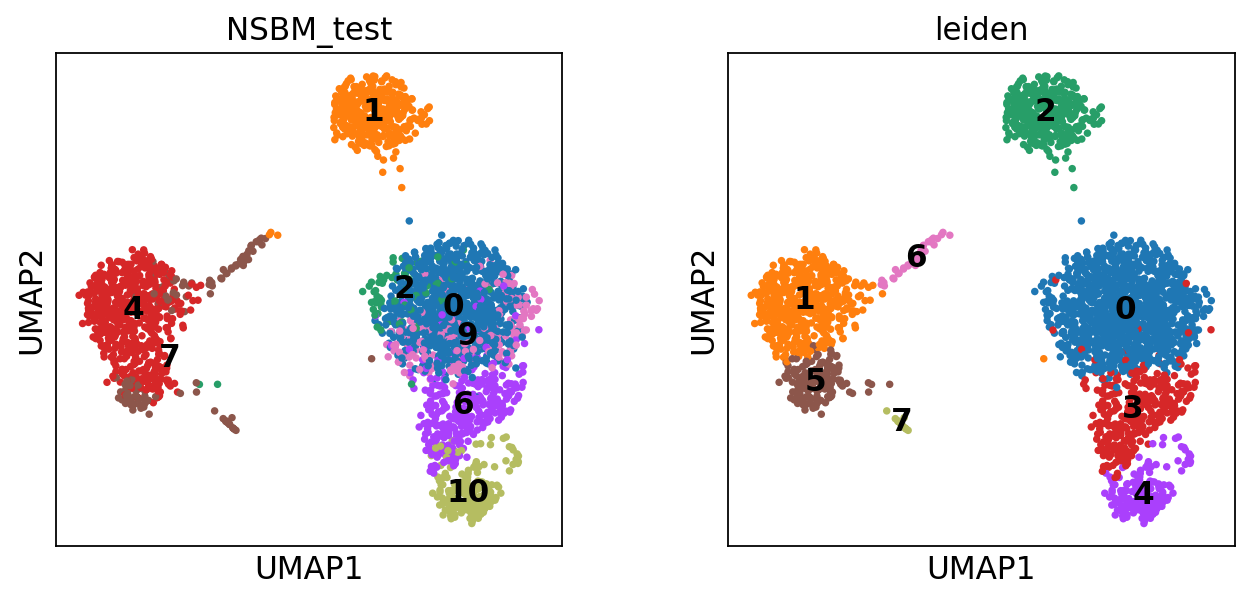

leiden       0    1    2    3    4   5   6   7
NSBM_test                                     
0          843    0    0   11    0   0   0   0
1            0    0  341    0    0   0   3   0
2           74    0    0    3    0   2   0   0
4            0  455    0    0    0  98   0   0
6           37    0    0  270    2   0   0   0
7            0   31    0    0    0  50  33  13
9          189    0    0    5    0   0   0   0
10           0    0    0   17  161   0   0   0


In [116]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(1).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

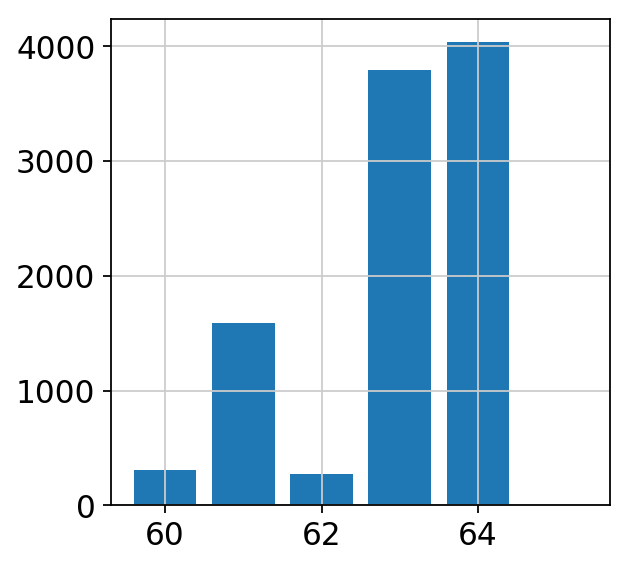

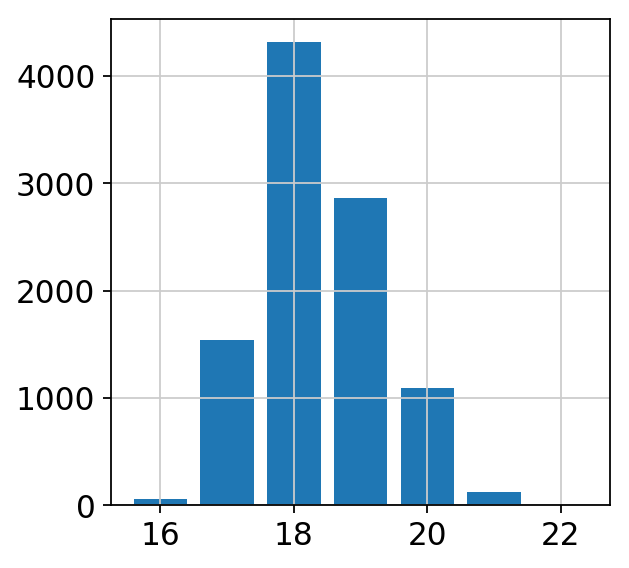

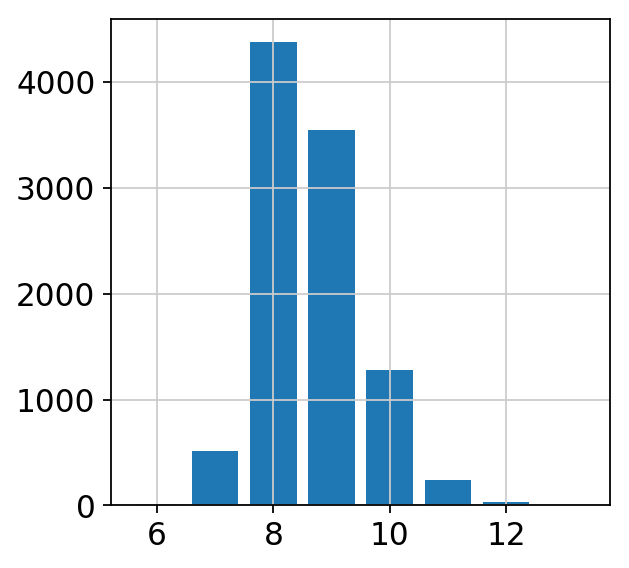

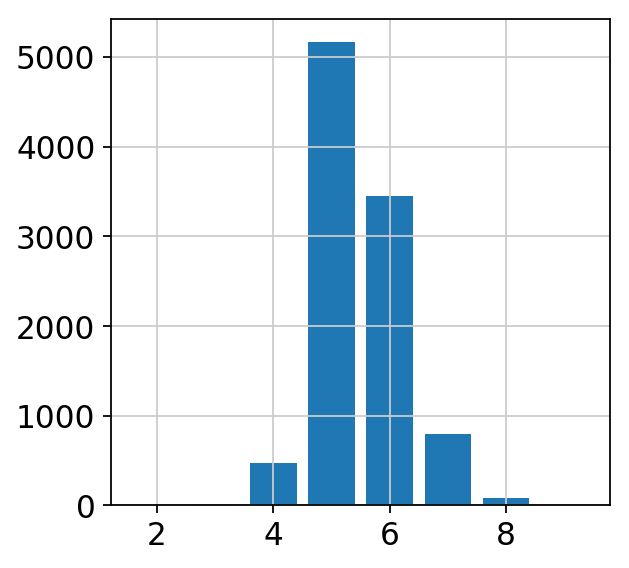

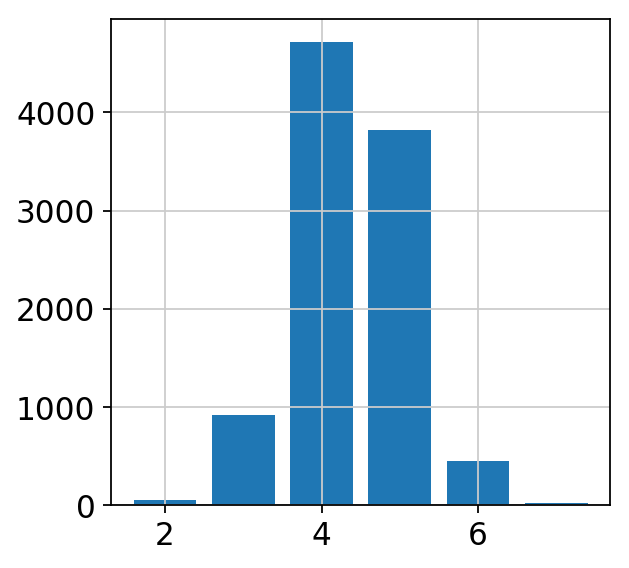

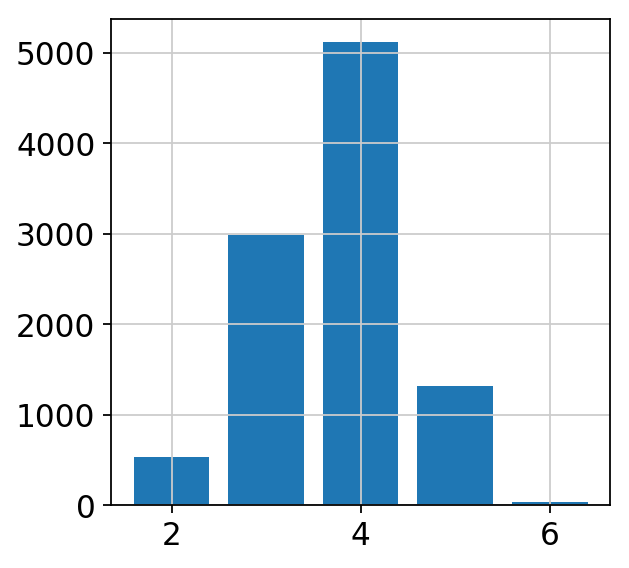

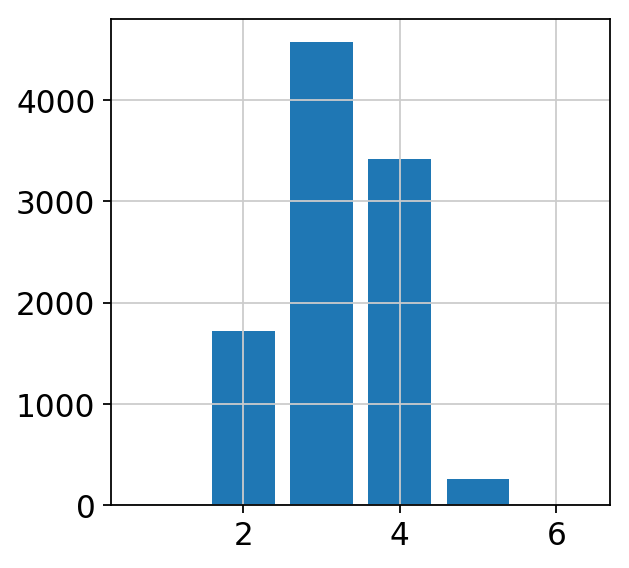

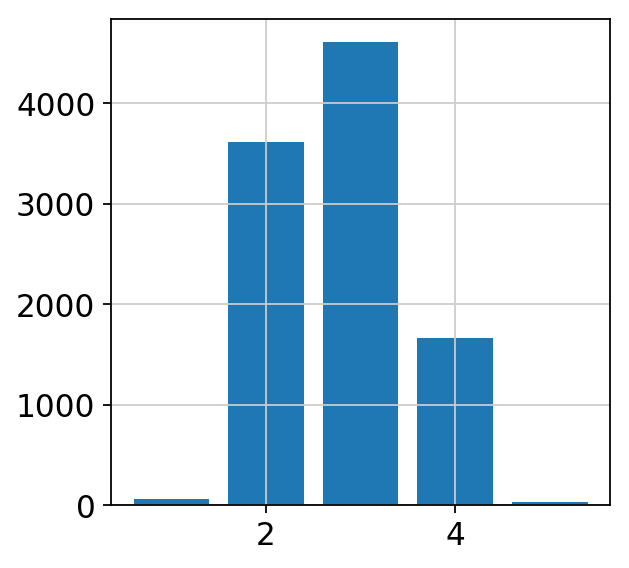

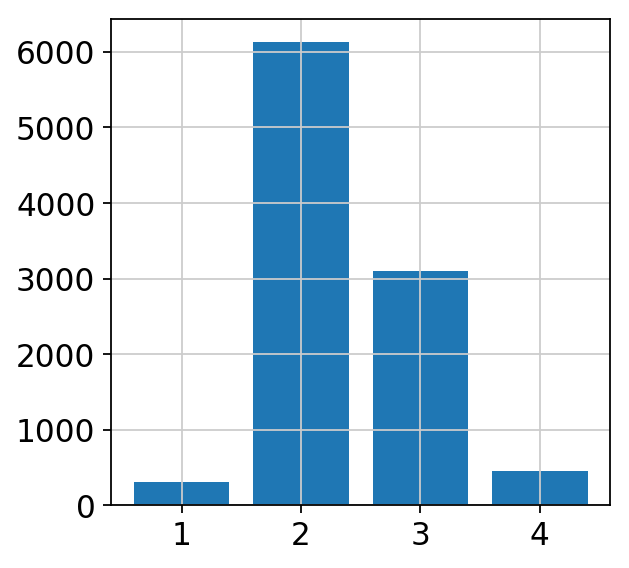

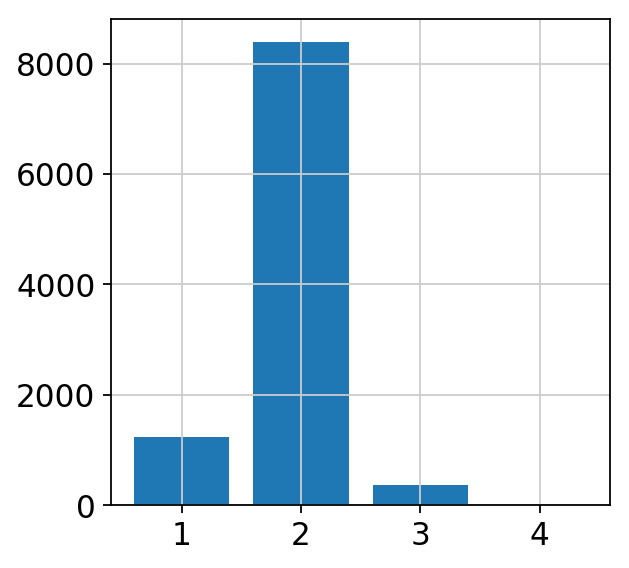

In [42]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

In [43]:
pickle.dump(state,open("pbmc/pbmc_state_c_sweep_e.pkl",'wb'),2)
pickle.dump(h,open("pbmc/h_c_sweep_e.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pv_c_sweep_e.pkl",'wb'),2)

In [20]:
e_state_sweep=pickle.load( open( "pbmc/pbmc_state_c_sweep_e.pkl", "rb" ))
h_state_sweep=pickle.load( open("pbmc/h_c_sweep_e.pkl", "rb" ))
pv_state_sweep=pickle.load( open( "pbmc/pv_c_sweep_e.pkl", "rb" ))

### C2) sweep (d=0.08)

In [39]:
bs = state_sweep08.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep08.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1
        

def collect_marginals(s):
   global pv
   pv = [sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [41]:
bs = state_sweep08.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_sweep08.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),callback=collect_info)
state

<NestedBlockState object, with base <BlockState object with 74 blocks (72 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7f594461d410>, at 0x7f59445b27d0>, and 10 levels of sizes [(2638, 72), (72, 18), (18, 8), (8, 7), (7, 5), (5, 4), (4, 3), (3, 2), (2, 2), (2, 2)] at 0x7f59445b2090>

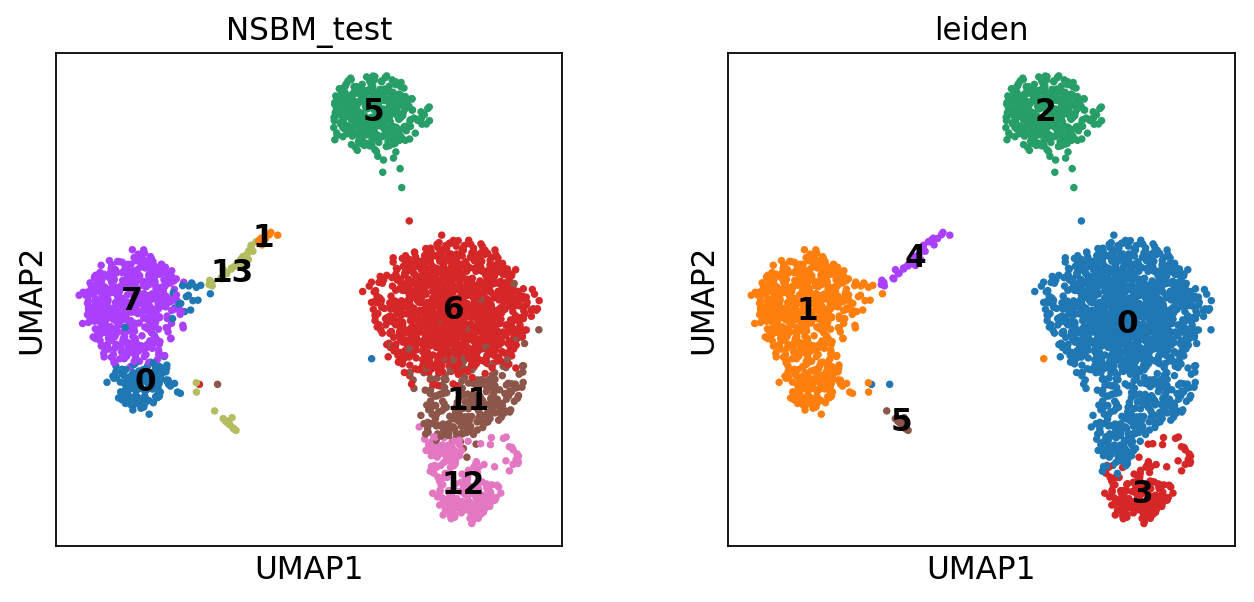

leiden        0    1    2    3   4   5
NSBM_test                             
0             0  151    0    0   0   0
1             0    0    0    0   8   0
5             0    0  341    0   0   0
6          1139    0    0    0   0   0
7             0  481    0    0   0   0
11          251    0    0    2   0   0
12           57    0    0  165   0   0
13            0    2    0    0  28  13


In [42]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

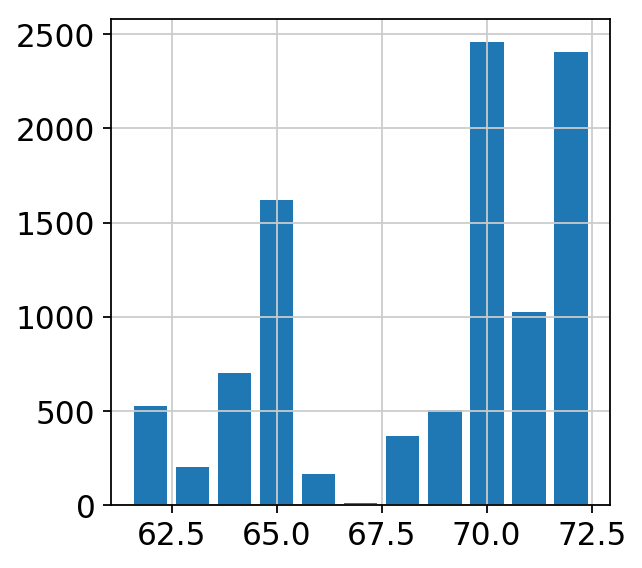

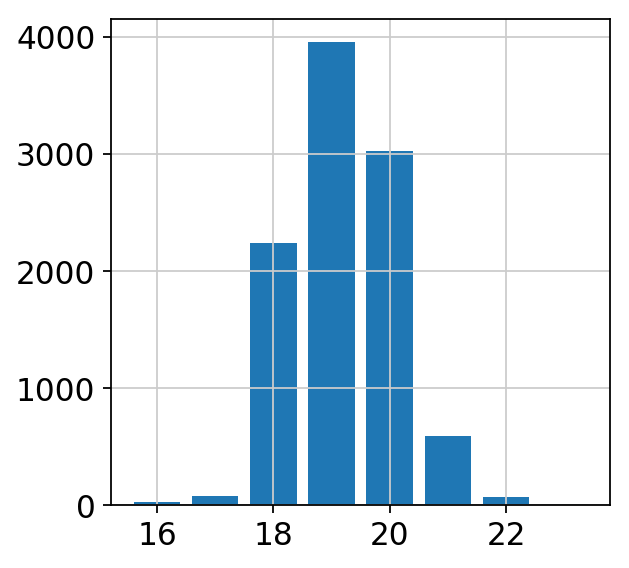

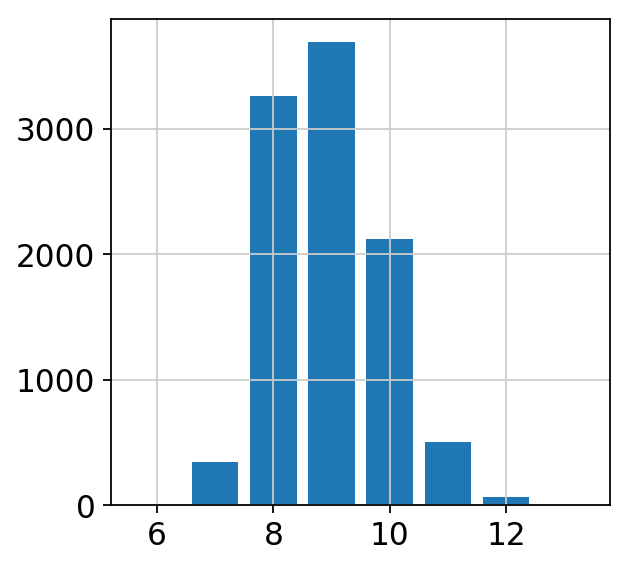

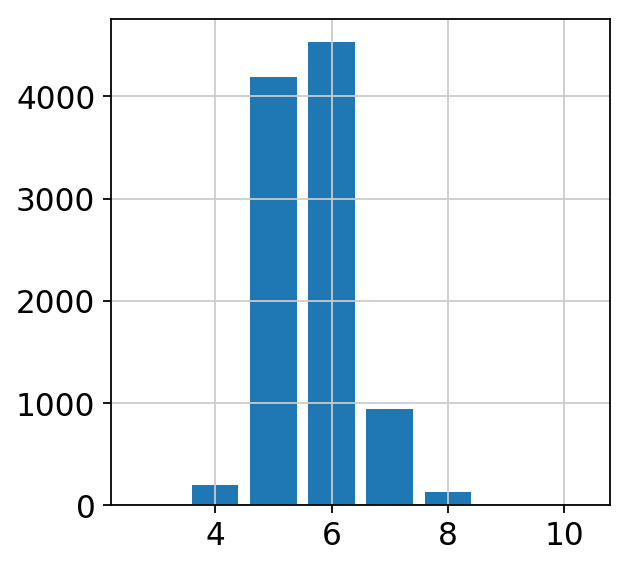

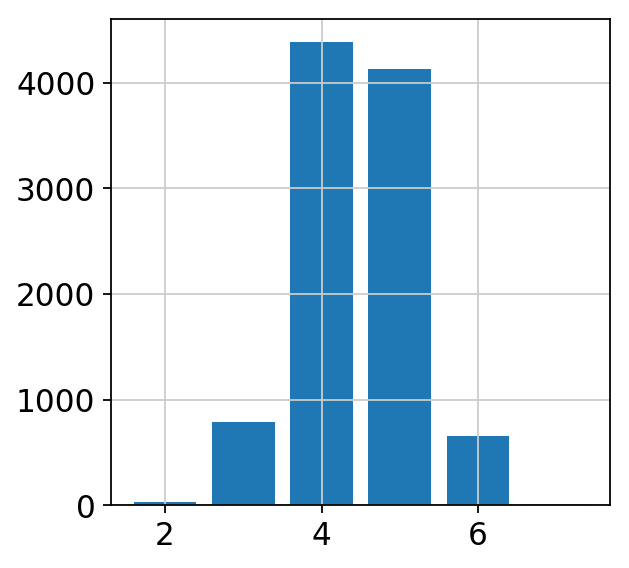

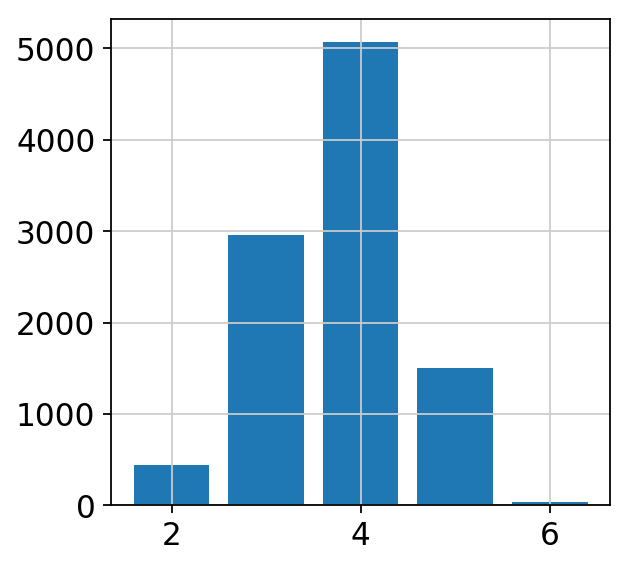

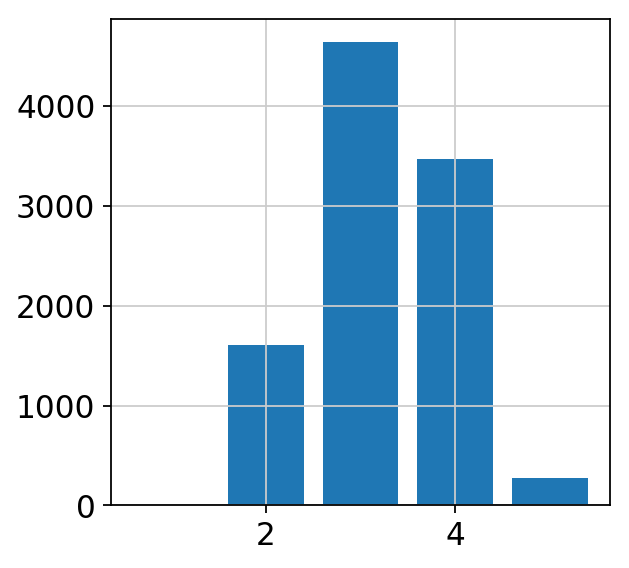

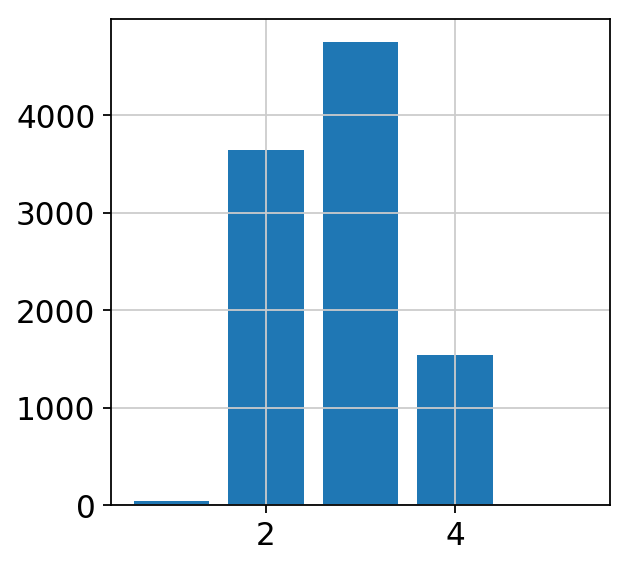

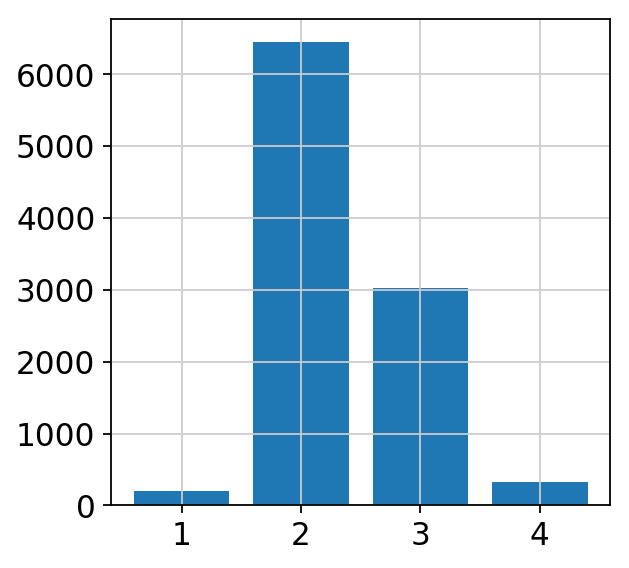

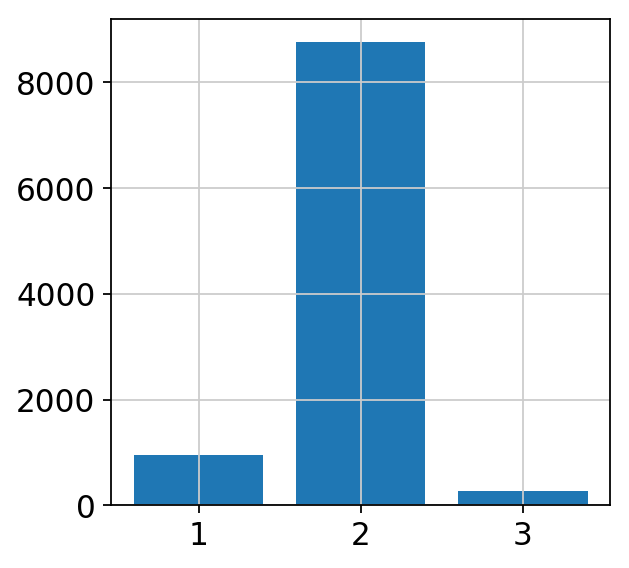

In [43]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

In [44]:
pickle.dump(state,open("pbmc/pbmc_state_c_sweep08_e.pkl",'wb'),2)
pickle.dump(h,open("pbmc/h_c_sweep08_e.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pv_c_sweep08_e.pkl",'wb'),2)

In [45]:
e_state_sweep=pickle.load( open( "pbmc/pbmc_state_c_sweep_e.pkl", "rb" ))
h_state_sweep=pickle.load( open("pbmc/h_c_sweep_e.pkl", "rb" ))
pv_state_sweep=pickle.load( open( "pbmc/pv_c_sweep_e.pkl", "rb" ))

### C3) multiflip (d=0.1) (6:00+22:00=28:00)

In [53]:
bs = state_multiflip.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_multiflip.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1
        

def collect_marginals(s):
   global pv
   pv = [sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [54]:
bs = state_multiflip.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_multiflip.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),callback=collect_info)
state

<NestedBlockState object, with base <BlockState object with 81 blocks (79 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7ffba8506b50>, at 0x7ffb9b09c990>, and 10 levels of sizes [(2638, 79), (79, 20), (20, 10), (10, 7), (7, 5), (5, 5), (5, 4), (4, 3), (3, 3), (3, 2)] at 0x7ffb9b09c950>

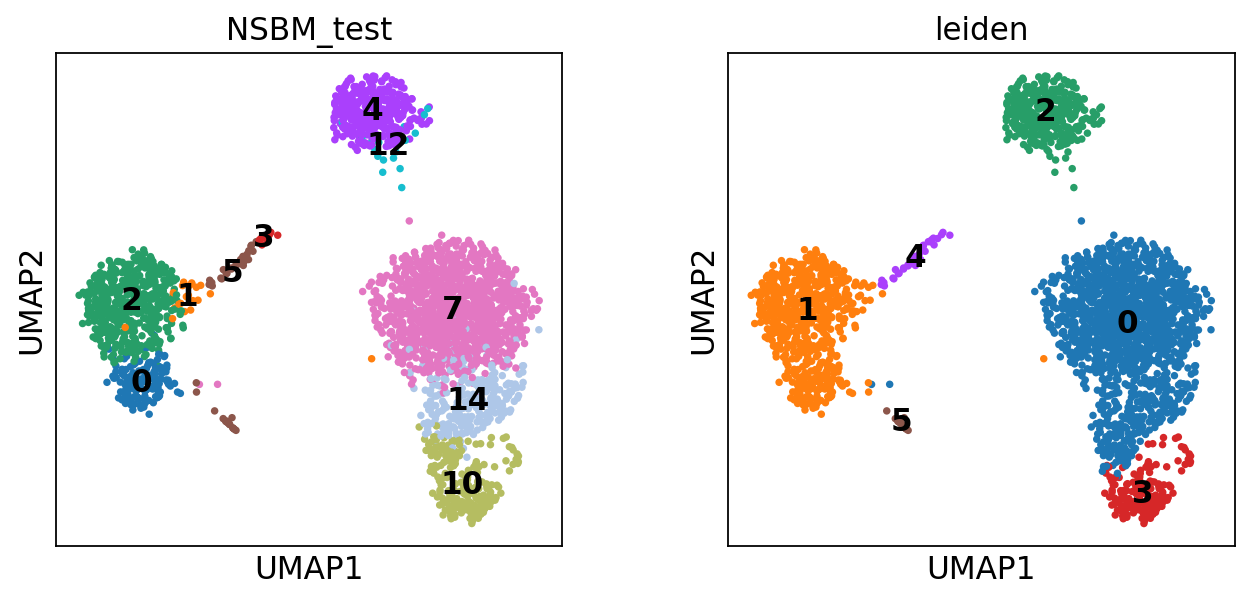

leiden        0    1    2    3   4   5
NSBM_test                             
0             0  142    0    0   0   0
1             0   22    0    0   0   0
2             0  468    0    0   0   0
3             0    0    0    0   8   0
4             0    0  323    0   0   0
5             0    2    0    0  28  13
7          1148    0    0    0   0   0
10           59    0    0  166   0   0
12            0    0   18    0   0   0
14          240    0    0    1   0   0


In [55]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

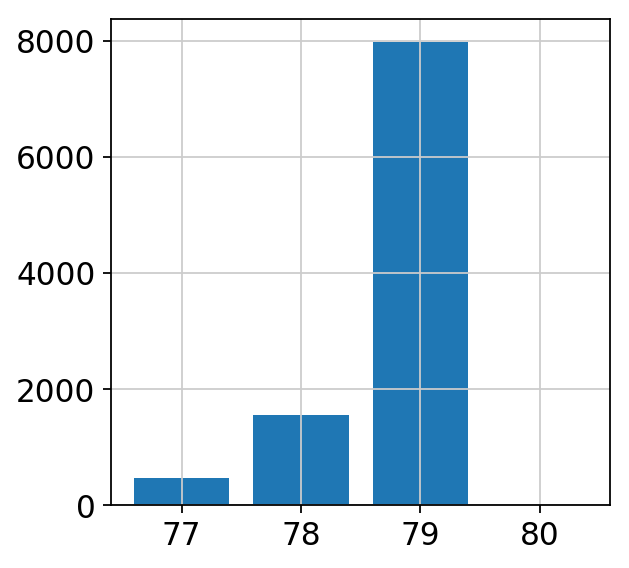

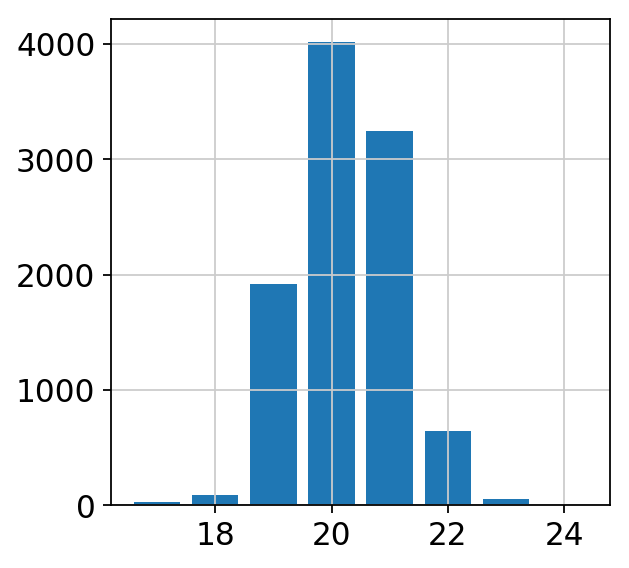

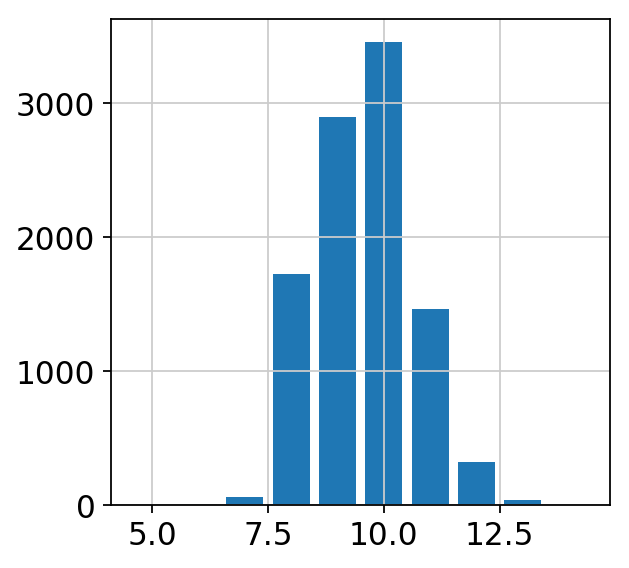

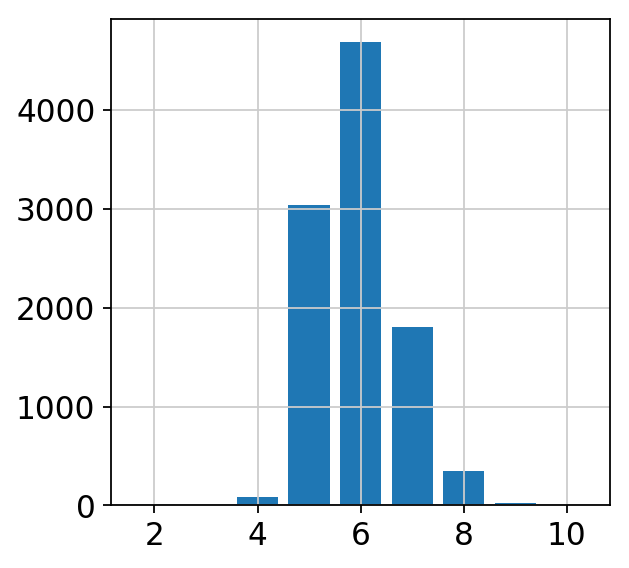

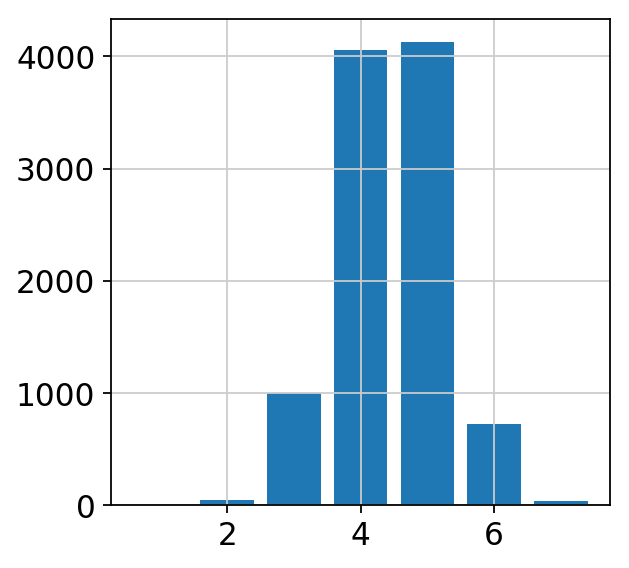

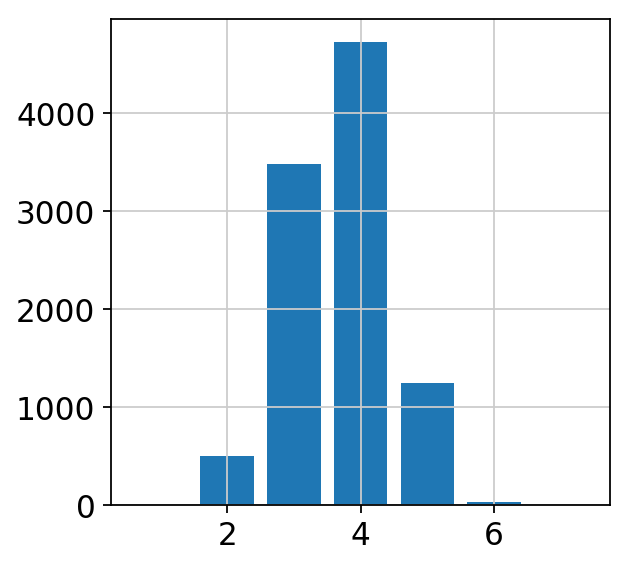

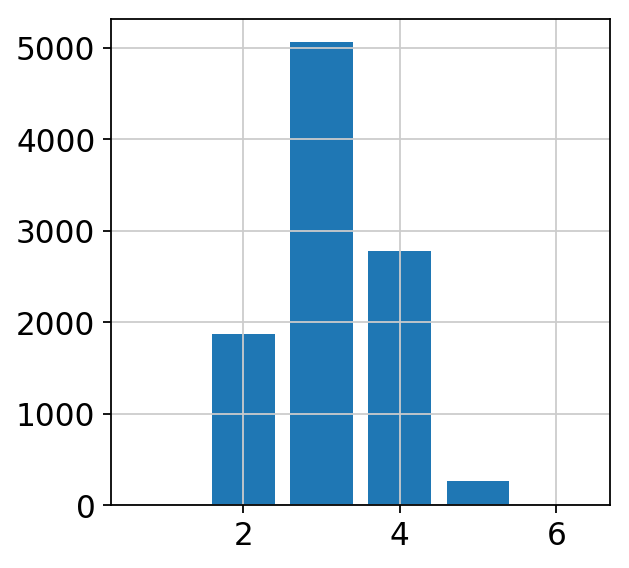

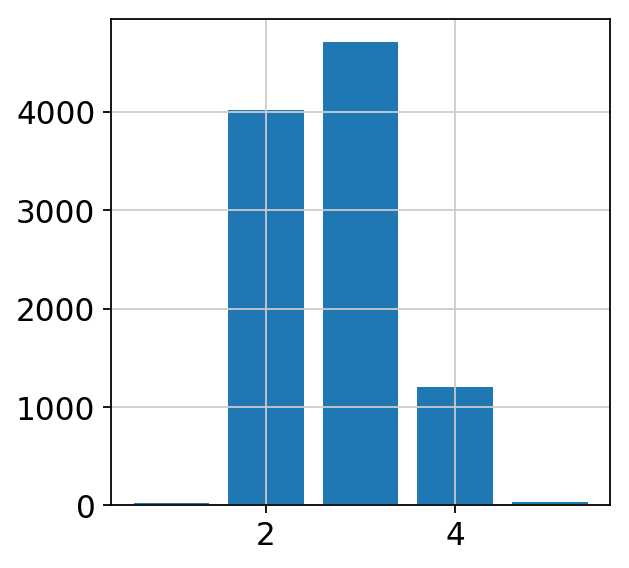

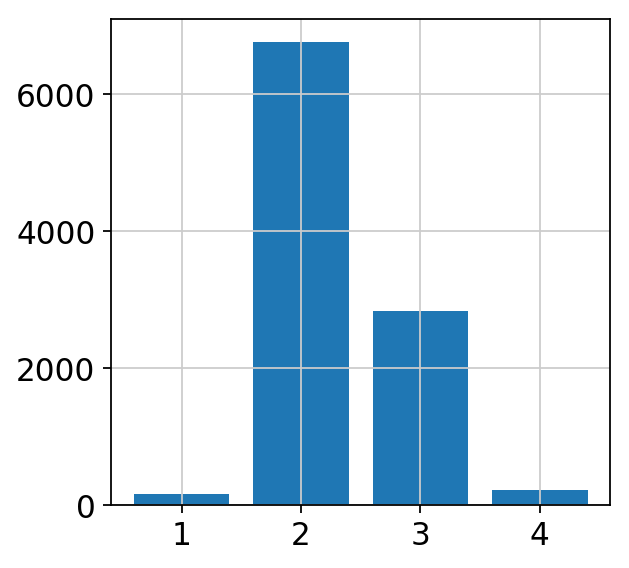

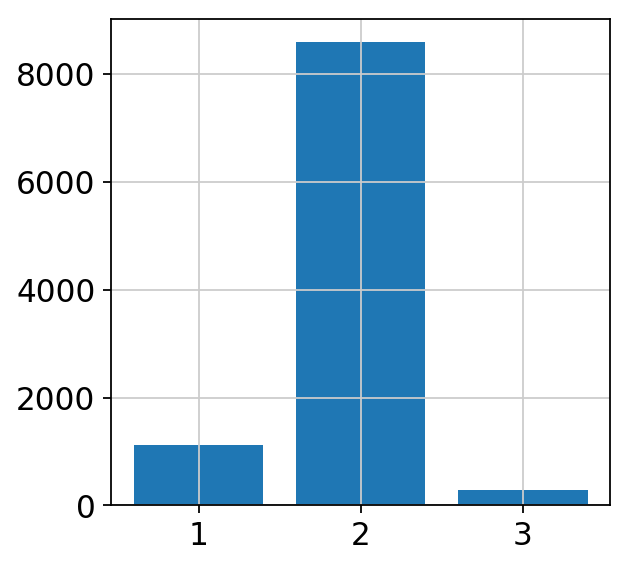

In [56]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

In [57]:
pickle.dump(state,open("pbmc/pbmc_state_c_multiflip_e.pkl",'wb'),2)
pickle.dump(h,open("pbmc/h_c_multiflip_e.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pv_c_multiflip_e.pkl",'wb'),2)

In [58]:
e_state_multiflip=pickle.load( open( "pbmc/pbmc_state_c_multiflip_e.pkl", "rb" ))
h_state_multiflip=pickle.load( open("pbmc/h_c_multiflip_e.pkl", "rb" ))
pv_state_multiflip=pickle.load( open( "pbmc/pv_c_multiflip_e.pkl", "rb" ))

### C4) multiflip (d=0.05) (6+23=29)

In [23]:
bs = state_multiflip.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_multiflip.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1
        

def collect_marginals(s):
   global pv
   pv = [sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [24]:
bs = state_multiflip.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_multiflip.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),callback=collect_info)
state

<NestedBlockState object, with base <BlockState object with 82 blocks (81 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7f568010b610>, at 0x7f567df35d50>, and 10 levels of sizes [(2638, 81), (81, 21), (21, 10), (10, 6), (6, 5), (5, 5), (5, 4), (4, 4), (4, 3), (3, 2)] at 0x7f567df35c50>

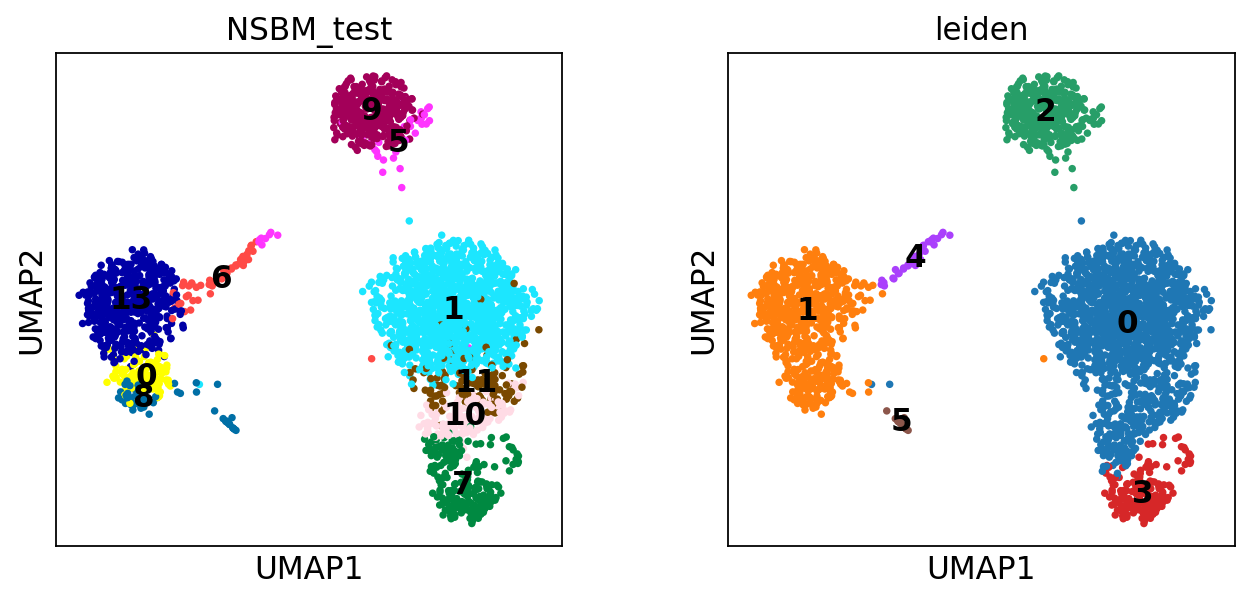

leiden        0    1    2    3   4   5
NSBM_test                             
0             0   98    0    0   0   0
1          1134    0    0    0   0   0
5             1    0   29    0   8   0
6             0   20    0    0  28   0
7            59    0    0  166   0   0
8             1   48    0    0   0  13
9             0    0  312    0   0   0
10          125    0    0    1   0   0
11          127    0    0    0   0   0
13            0  468    0    0   0   0


In [40]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

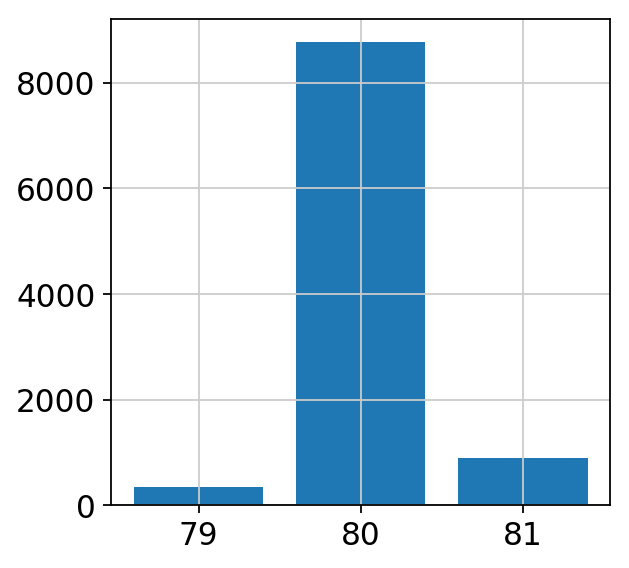

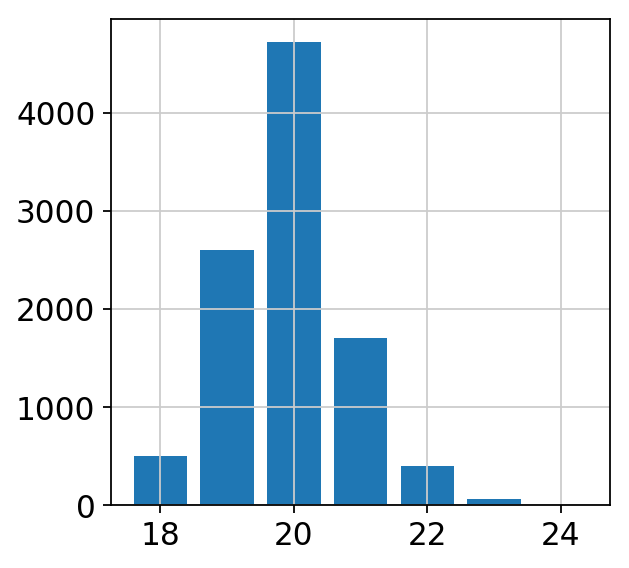

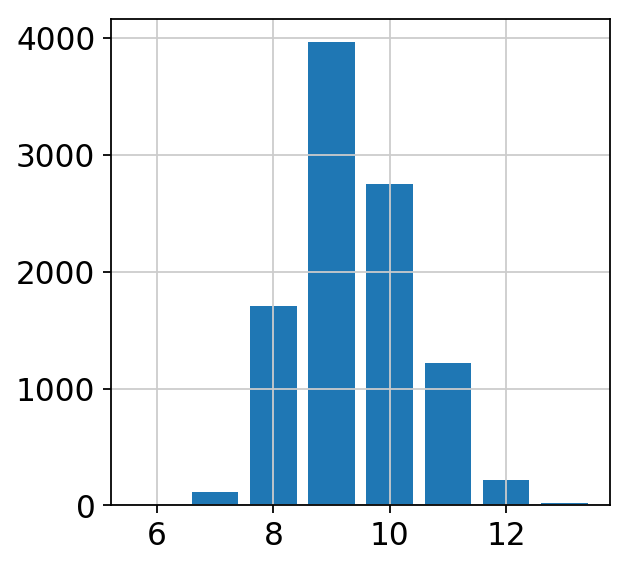

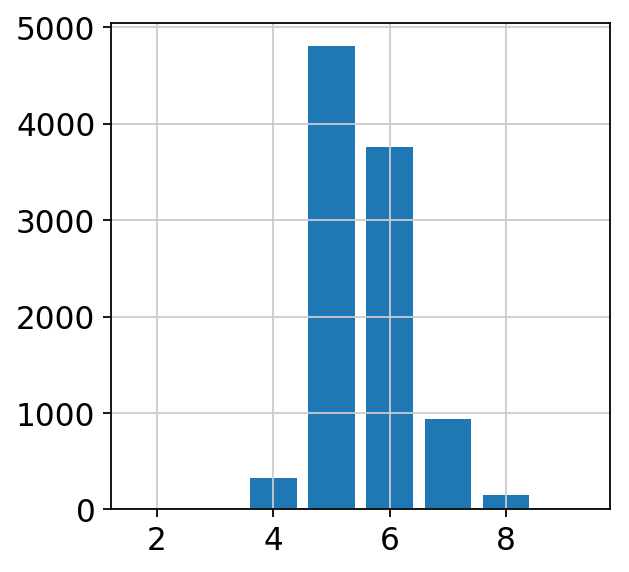

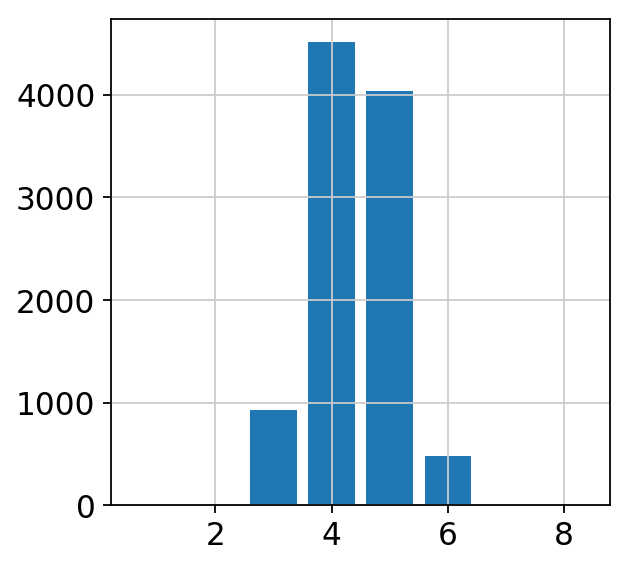

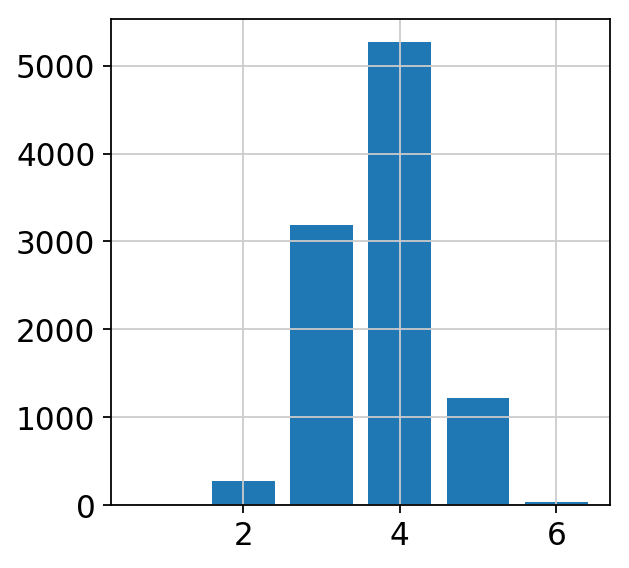

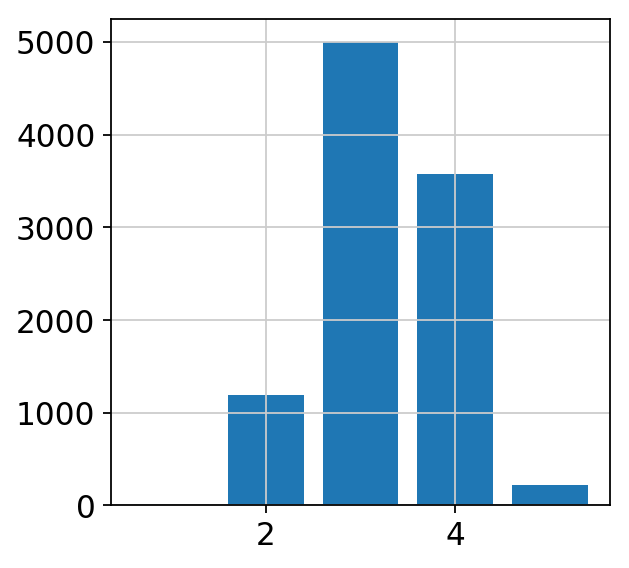

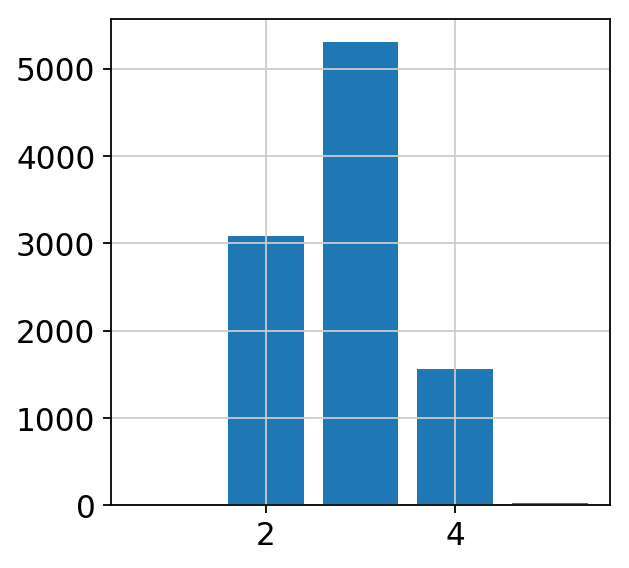

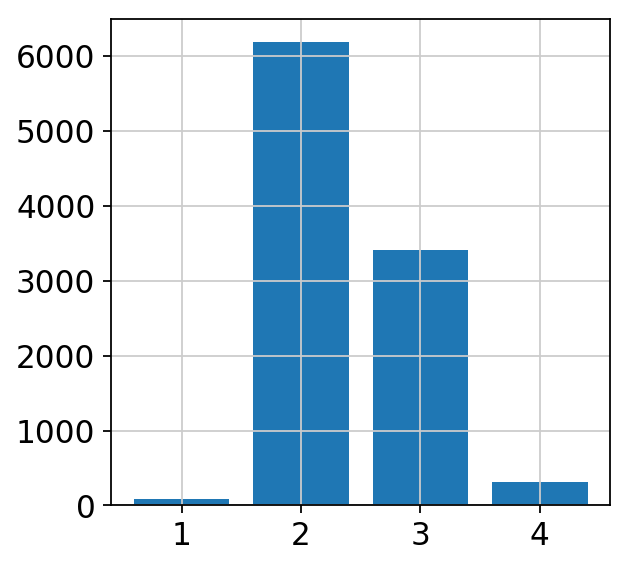

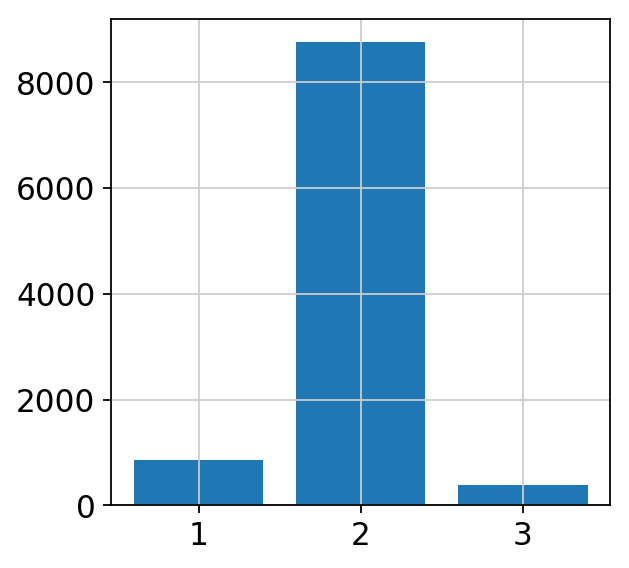

In [26]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

In [27]:
pickle.dump(state,open("pbmc/pbmc_state_c_multiflip05_e.pkl",'wb'),2)
pickle.dump(h,open("pbmc/h_c_multiflip05_e.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pv_c_multiflip05_e.pkl",'wb'),2)

In [28]:
e_state_multiflip=pickle.load( open( "pbmc/pbmc_state_c_multiflip05_e.pkl", "rb" ))
h_state_multiflip=pickle.load( open("pbmc/h_c_multiflip05_e.pkl", "rb" ))
pv_state_multiflip=pickle.load( open( "pbmc/pv_c_multiflip05_e.pkl", "rb" ))

### C5) multiflip (d=0.08) 

In [27]:
bs = state_multiflip08.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_multiflip08.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1
        

def collect_marginals(s):
   global pv
   pv = [sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [28]:
bs = state_multiflip.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_multiflip08.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),callback=collect_info)
state

<NestedBlockState object, with base <BlockState object with 86 blocks (84 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7f5945fac210>, at 0x7f5946988e90>, and 10 levels of sizes [(2638, 84), (84, 22), (22, 10), (10, 6), (6, 4), (4, 3), (3, 3), (3, 3), (3, 3), (3, 2)] at 0x7f5946988fd0>

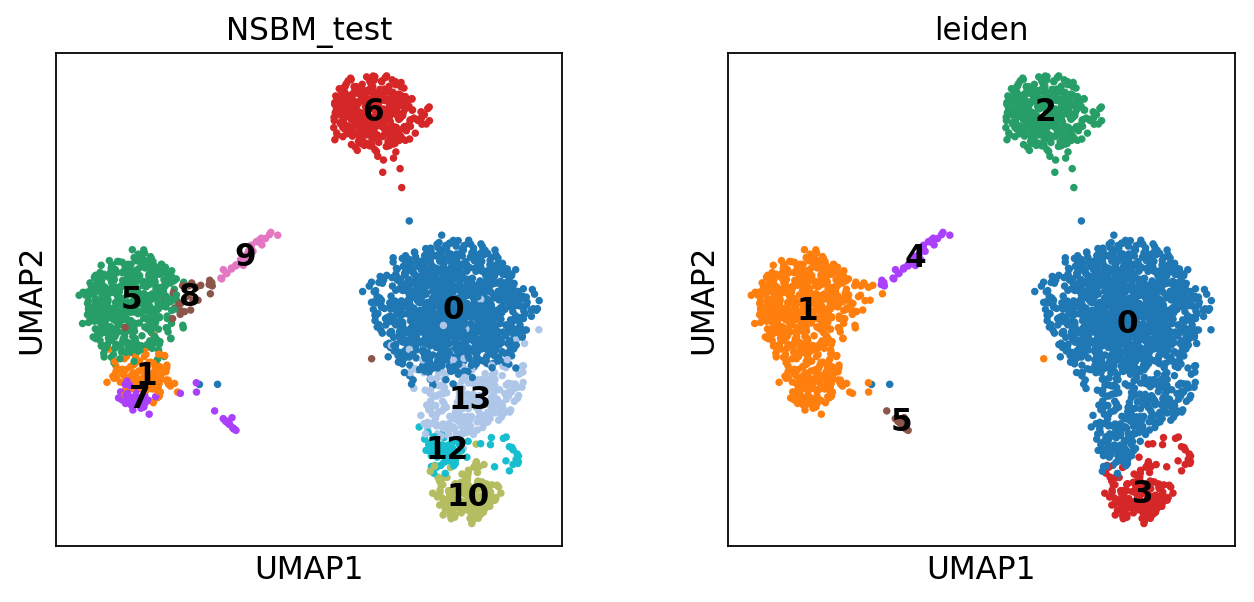

leiden        0    1    2    3   4   5
NSBM_test                             
0          1138    0    0    0   0   0
1             0   99    0    0   0   0
5             0  463    0    0   0   0
6             0    0  341    0   0   0
7             0   48    0    0   0  13
8             0   24    0    0   4   0
9             0    0    0    0  32   0
10            4    0    0  146   0   0
12           58    0    0   21   0   0
13          247    0    0    0   0   0


In [29]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))

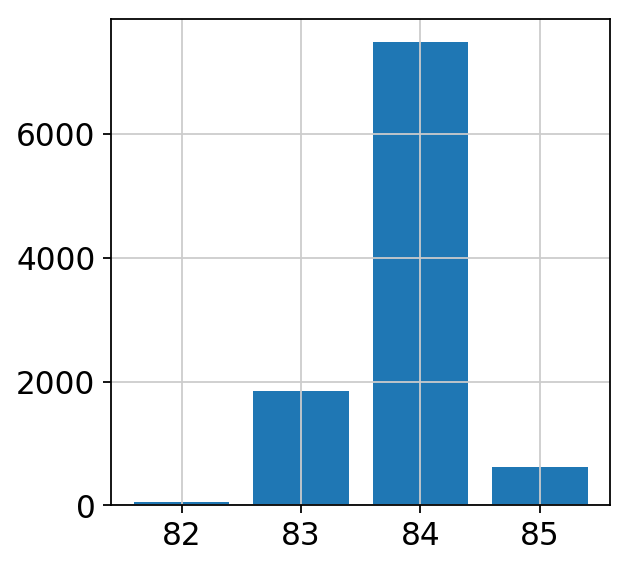

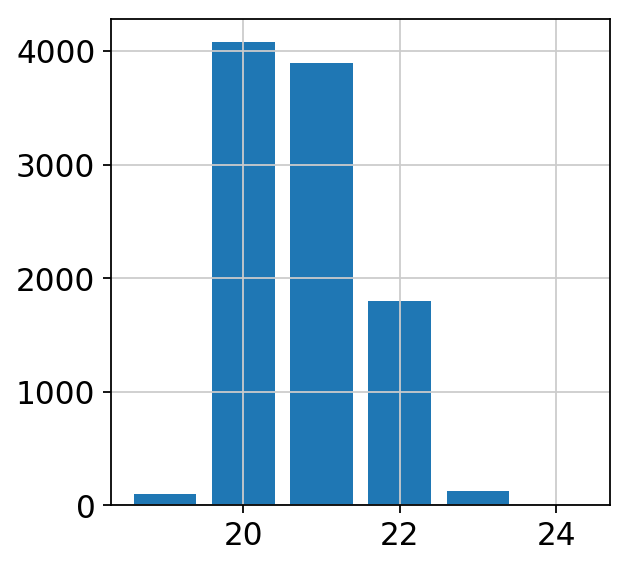

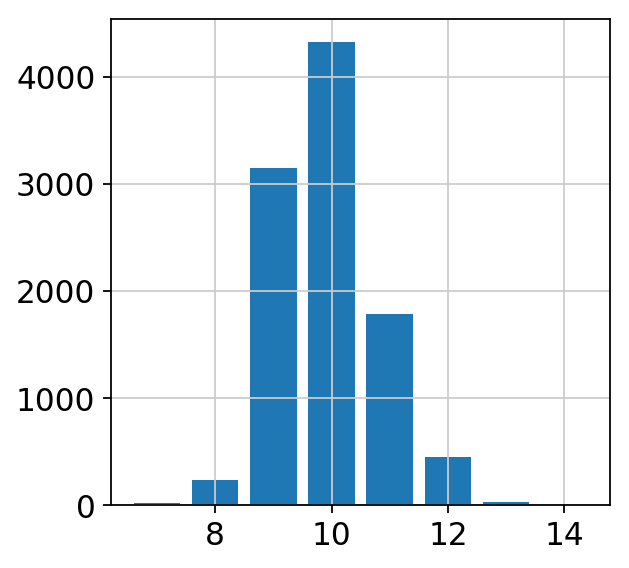

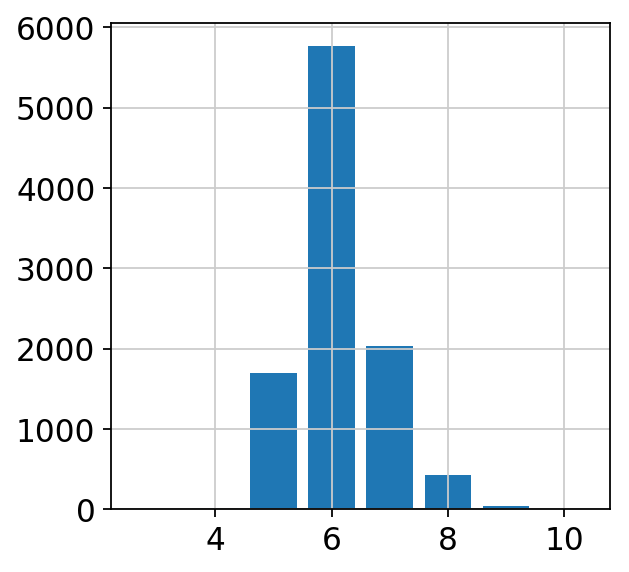

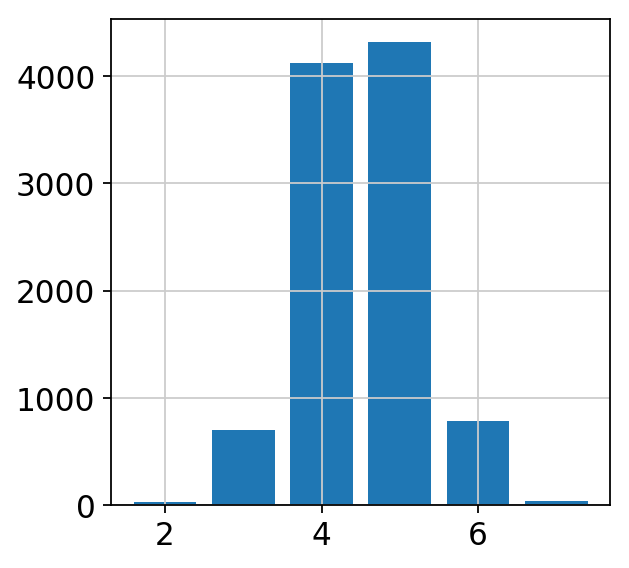

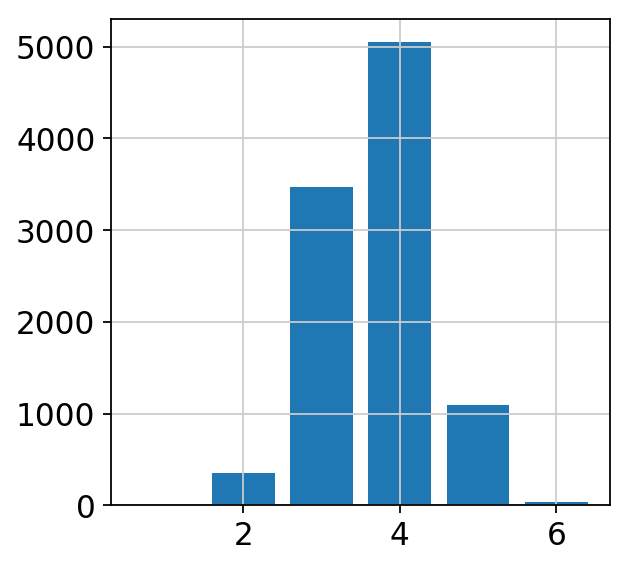

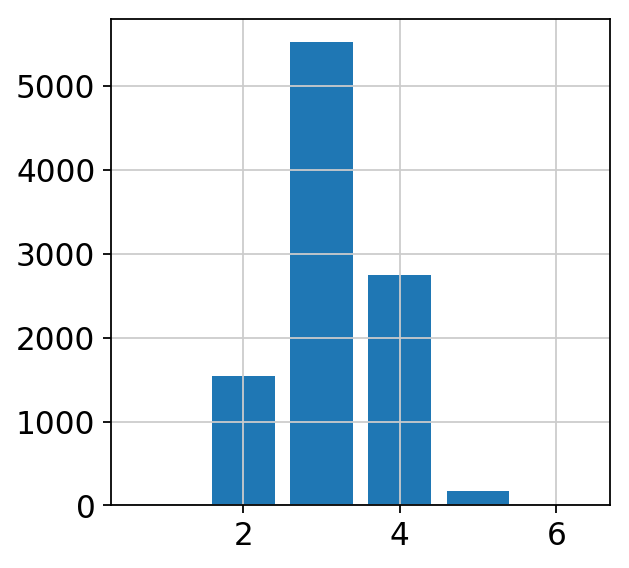

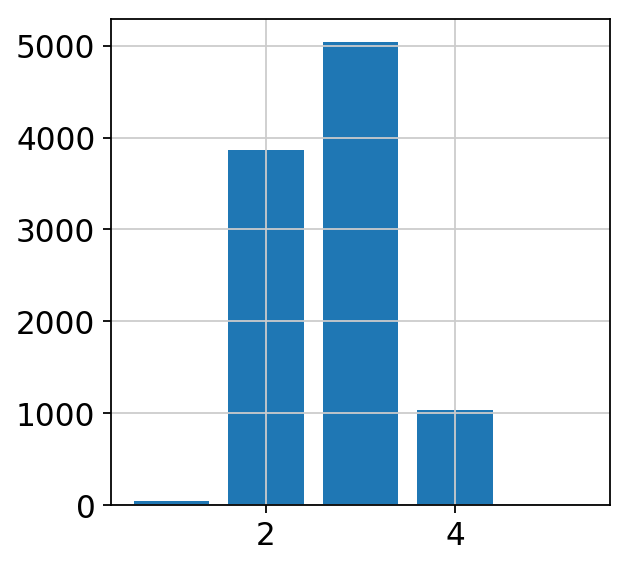

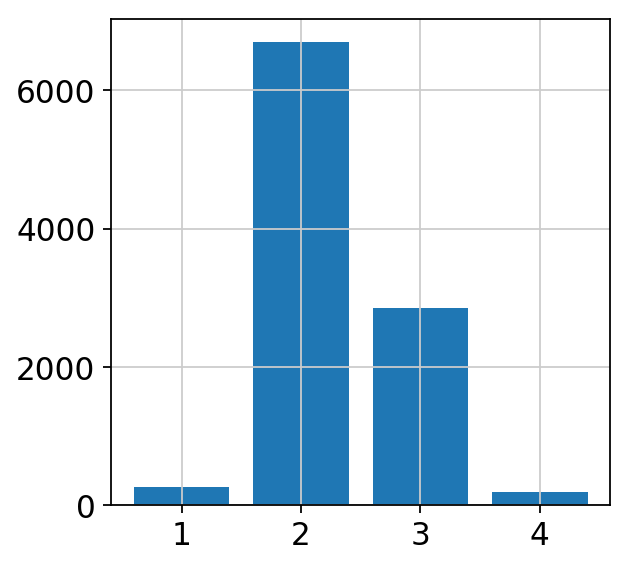

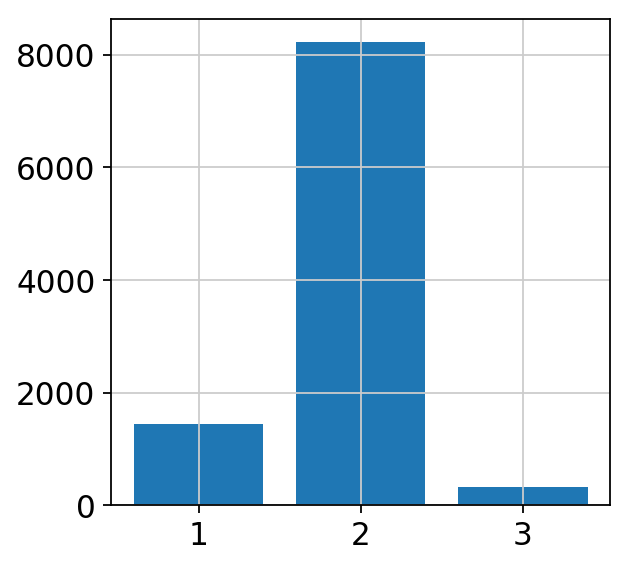

In [30]:
for l in range (0,len(bs)):
    idxs= np.where(h[l] > 0)[0]
    v = h[l][idxs]
    figure(l)
    bar(idxs, v)

In [31]:
pickle.dump(state,open("pbmc/pbmc_state_c_multiflip08_e.pkl",'wb'),2)
pickle.dump(h,open("pbmc/h_c_multiflip08_e.pkl",'wb'),2)
pickle.dump(pv,open("pbmc/pv_c_multiflip08_e.pkl",'wb'),2)

In [32]:
e_state_multiflip08=pickle.load( open( "pbmc/pbmc_state_c_multiflip08_e.pkl", "rb" ))
h_state_multiflip08=pickle.load( open("pbmc/h_c_multiflip08_e.pkl", "rb" ))
pv_state_multiflip08=pickle.load( open( "pbmc/pv_c_multiflip08_e.pkl", "rb" ))

In [61]:
bs = state_multiflip08.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_multiflip08.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, wait=10, multiflip=True,mcmc_args=dict(niter=10))
h = [np.zeros(g.num_vertices() + 1) for s in state.get_levels()]
pv = [None] * len(state.get_levels())


def collect_info(s):
    for l,sl in enumerate(s.get_levels()):
        B=sl.get_nonempty_B()
        h[l][B] +=1
        global pv
        pv=[sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

def collect_num_groups(s):
    for l, sl in enumerate(s.get_levels()):
       B = sl.get_nonempty_B()
       h[l][B] += 1
        

def collect_marginals(s):
   global pv
   pv = [sl.collect_vertex_marginals(pv[l]) for l, sl in enumerate(s.get_levels())]

In [62]:
bs = state_multiflip.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state = state_multiflip08.copy(bs=bs, sampling=True)
gt.mcmc_equilibrate(state, force_niter=10000, multiflip=True, mcmc_args=dict(niter=10),callback=collect_info)
state

<NestedBlockState object, with base <BlockState object with 128 blocks (124 nonempty), for graph <Graph object, undirected, with 2638 vertices and 20976 edges at 0x7f5945fac210>, at 0x7f5946ae6dd0>, and 10 levels of sizes [(2638, 124), (124, 22), (22, 10), (10, 5), (5, 5), (5, 5), (5, 3), (3, 2), (2, 2), (2, 1)] at 0x7f5946ae6d90>

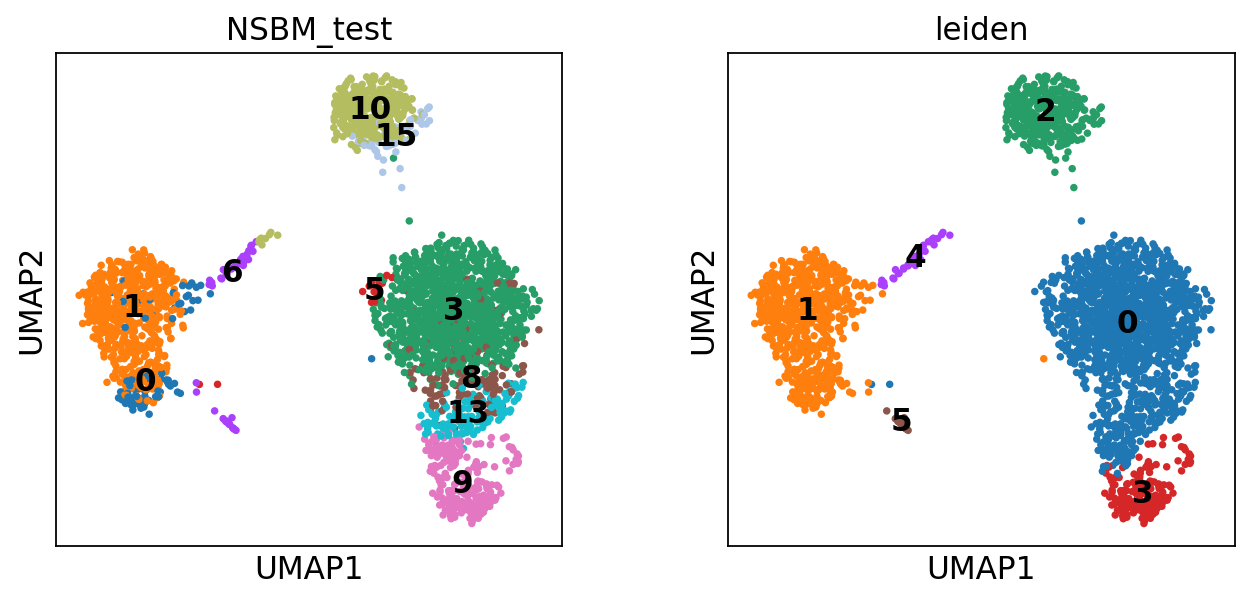

leiden        0    1    2    3   4   5
NSBM_test                             
0             0   92    0    0   0   0
1             0  540    0    0   0   0
3          1112    0    1    0   0   0
5            15    0    0    0   0   0
6             0    2    0    0  28  13
8           129    0    0    0   0   0
9            62    0    0  167   0   0
10            0    0  299    0   8   0
13          129    0    0    0   0   0
15            0    0   41    0   0   0


In [63]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
print(pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden))